# Import and Installs - run each time

Imports and installs and getting google drive ready

In [ ]:
#import the package used to read bigwig files
!pip install pyBigWig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install gffutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
#import packages we will use in the notebooks
import pyBigWig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from tqdm import tqdm  # progress bar
import glob
import hashlib
import json
from collections import defaultdict
import gffutils
import math
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

In [ ]:
#Mount Google Drive

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#PT Version

# Set up data folder
from pathlib import Path

# CHANGE TO SHARED FOLDER ONCE I HAVE ACCESS
DATA = Path("/content/drive/MyDrive/ML4fungen/Project/")

In [ ]:
#JZ Version

# Set up data folder
from pathlib import Path

# CHANGE TO SHARED FOLDER ONCE I HAVE ACCESS
DATA = Path("/content/drive/MyDrive/MyProject/")

# Webscraping and Downloading Data from cfmethdb - only need to run once and then can load data directly from google drive

Downloading the data needed

In [ ]:
#Website we are getting the data from does not give easy access to download the raw data so used ChatGPT to help with some webscraping since thats not a focus of our project nor an area of expertise for us

base_url = "https://cfmethdb.hzau.edu.cn/prod-api/api/getcfdnagsm/"
sample_types = ["Normal", "Breast cancer", "Colorectal cancer", "Esophageal cancer", "Gastric cancer", "Liver cancer", "Lung cancer", "Pancreatic cancer",]  # You can expand this if more types exist
all_records = []

for sample in sample_types:
    page = 1
    page_size = 100

    while True:
        params = {
            "bsrate": "",
            "query": "",
            "sample": sample,
            "page": page,
            "page_size": page_size,
            "sort": "-bsrate"
        }

        response = requests.get(base_url, params=params)
        data = response.json()
        records = data.get("data") or data.get("results")

        if not records:
            break

        all_records.extend(records)
        print(f"Fetched page {page} for sample type '{sample}', {len(records)} records")
        page += 1

print(f"Total records fetched: {len(all_records)}")
df = pd.DataFrame(all_records)
df.head()  # Shows the first few rows

NameError: name 'requests' is not defined

In [ ]:
#Filter based on bs and map rate cutoffs and the metadata provided from website
df['bsrate'] = df['bsrate'].astype(float)
df['maprate'] = df['maprate'].astype(float)

map_rate_cutoff = 0.9
bs_rate_cutoff = 0.98

high_quality_samples_df = df[(df['bsrate']>=bs_rate_cutoff) & (df['maprate']>=map_rate_cutoff)].copy()
high_quality_samples_df

total = 0
for x in high_quality_samples_df['sample'].unique():
  print(x, len(high_quality_samples_df[high_quality_samples_df['sample']==x]))
  total+=len(high_quality_samples_df[high_quality_samples_df['sample']==x])
print(total)

Normal 928
Breast cancer 61
Colorectal cancer 567
Esophageal cancer 20
Gastric cancer 10
Liver cancer 123
Lung cancer 263
Pancreatic cancer 59
2031


In [ ]:
bw_summary_path = DATA / 'cfmethDB.csv'

bw_summary = pd.read_csv(bw_summary_path)
bw_summary.head(10)

,web_scraper_order,web_scraper_start_url,geoid,bwid
0,1761863184-1,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
1,1761863184-2,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
2,1761863184-3,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
3,1761863184-4,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM76578...
4,1761863184-5,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
5,1761863184-6,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM76578...
6,1761863184-7,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
7,1761863184-8,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM76578...
8,1761863184-9,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
9,1761863184-10,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108\n\nSRX19223109\n\nSRX19223111\n\nG...,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...


In [ ]:
# If the number of rows isn't a multiple of 10, fix partial group
for i in range(0, len(bw_summary), 10):
    subset = bw_summary.iloc[i:i+10]
    geoids_group = bw_summary['geoid'].iloc[i].split() if isinstance(bw_summary['geoid'].iloc[i], str) else geoids
    bw_summary.loc[i:i+9, 'geoid'] = geoids_group[:len(subset)]
bw_summary.head(10)

,web_scraper_order,web_scraper_start_url,geoid,bwid
0,1761863184-1,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223108,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
1,1761863184-2,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223109,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
2,1761863184-3,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223111,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
3,1761863184-4,https://cfmethdb.hzau.edu.cn/datalist/index,GSM7657841,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM76578...
4,1761863184-5,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223113,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
5,1761863184-6,https://cfmethdb.hzau.edu.cn/datalist/index,GSM7657840,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM76578...
6,1761863184-7,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223112,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
7,1761863184-8,https://cfmethdb.hzau.edu.cn/datalist/index,GSM7657842,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM76578...
8,1761863184-9,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223114,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...
9,1761863184-10,https://cfmethdb.hzau.edu.cn/datalist/index,SRX19223110,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX19223...


In [ ]:
bw_summary.rename(columns={'geoid': 'Geoid'}, inplace=True)
metadata_df = high_quality_samples_df.merge(
    bw_summary[['Geoid', 'bwid']],
    on='Geoid',
    how='left'  # keeps all rows from high_quality_sample_df even if missing bwid
)
metadata_df.head(10)

,Geoid,sample,Bases,Instrument,Layout,Library,Organism,sra,Title,Source,Tissue,Public,Pubmed,Ftp,Md5,bsrate,studyid,maprate,bwid
0,SRX9388425,Normal,15.45Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924159,CP3,NA,NA,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/059/SRR129...,"9843ba8a02f29bb00a6d030fd5984588,fbf950bce653f...",0.9957,PRJNA672914,0.9592,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...
1,GSM2464828,Normal,5.28Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5194901,SRR5963744,SRR5963743",NC-P-49,Plasma,Plasma,2017-01-28 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR519/001/SRR519...,"e2a5fb1ec0476852a4b5a3cedb86def0,6f8277266b789...",0.9956,PRJNA315379,0.9297,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
2,GSM2464829,Normal,5.74Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5963745,SRR5963746,SRR5194902",NC-P-50,Plasma,Plasma,2017-09-30 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR596/005/SRR596...,"06781b92b08b4bfdf3c16449177e81a0,d360ebc20245d...",0.9956,PRJNA315379,0.9091,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
3,SRX9388423,Normal,14.09Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924161,CP1,NA,NA,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/061/SRR129...,"4528072131c77e2d4674694b981b32b9,a8fc6d9179ffd...",0.9956,PRJNA672914,0.9742,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...
4,SRX9388424,Normal,12.9Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924160,CP2,NA,NA,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/060/SRR129...,"3c99c3437eddffc11493ec1d30b87819,d60df3cddde3b...",0.9956,PRJNA672914,0.9804,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...
5,SRX9388426,Normal,14.85Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924158,CP4,NA,NA,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/058/SRR129...,"b086c54e2b73d75e6e8637f1c71f95bc,9e2553a9881f9...",0.9956,PRJNA672914,0.9805,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...
6,GSM2464831,Normal,5.6Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5194904,SRR5963749,SRR5963750",NC-P-52,Plasma,Plasma,2017-01-28 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR519/004/SRR519...,"f8752a788bf341c3f542d2b05771d5ef,5ce7466870920...",0.9954,PRJNA315379,0.9371,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
7,GSM2464811,Normal,2.74Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5963713,SRR5194884",NC-P-31,Plasma,Plasma,2017-09-30 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR596/003/SRR596...,"e511e5250f8fb2f22a7c362f481b98ad,25ccec2f5d7c5...",0.9951,PRJNA315379,0.9813,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
8,GSM2464827,Normal,4.44Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5194900,SRR5963742,SRR5963741",NC-P-48,Plasma,Plasma,2017-01-28 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR519/000/SRR519...,"aa8f33e5c49171bf992afa7c1cfb3760,728d3447f167f...",0.9950,PRJNA315379,0.9644,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
9,GSM2464825,Normal,4.75Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5194898,SRR5963737,SRR5963738",NC-P-46,Plasma,Plasma,2017-01-28 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR519/008/SRR519...,"2f74a807cf925d9647818b9e9c8b7107,87be2c55f9fbd...",0.9949,PRJNA315379,0.9210,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...


In [ ]:
metadata_df = metadata_df.dropna(subset=['bwid'])
metadata_df= metadata_df.drop_duplicates(subset=['bwid'])
metadata_df= metadata_df.drop_duplicates(subset=['Geoid'])

print(metadata_df)

           Geoid             sample    Bases             Instrument  Layout  \
0     SRX9388425             Normal  15.45Gb    Illumina HiSeq 4000  SINGLE   
1     GSM2464828             Normal   5.28Gb    Illumina HiSeq 2500  PAIRED   
2     GSM2464829             Normal   5.74Gb    Illumina HiSeq 2500  PAIRED   
3     SRX9388423             Normal  14.09Gb    Illumina HiSeq 4000  SINGLE   
4     SRX9388424             Normal   12.9Gb    Illumina HiSeq 4000  SINGLE   
...          ...                ...      ...                    ...     ...   
2115  GSM4502351  Pancreatic cancer   3.26Gb  Illumina NovaSeq 6000  PAIRED   
2116  GSM4502311  Pancreatic cancer   4.38Gb  Illumina NovaSeq 6000  PAIRED   
2117  GSM4502282  Pancreatic cancer   3.71Gb  Illumina NovaSeq 6000  PAIRED   
2118  GSM4502154  Pancreatic cancer    4.3Gb  Illumina NovaSeq 6000  PAIRED   
2119  GSM4502353  Pancreatic cancer   3.07Gb  Illumina NovaSeq 6000  PAIRED   

               Library      Organism               

In [ ]:
total = 0
for x in metadata_df['sample'].unique():
  print(x, len(metadata_df[metadata_df['sample']==x]))
  total+=len(metadata_df[metadata_df['sample']==x])
print(total)

Normal 928
Breast cancer 33
Colorectal cancer 514
Esophageal cancer 20
Gastric cancer 10
Liver cancer 123
Lung cancer 263
Pancreatic cancer 59
1950


In [ ]:
# Path to your desired DATA folder in Google Drive
bw_folder_path = DATA / 'bw_files/'

# Make sure the folder exists
os.makedirs(bw_folder_path, exist_ok=True)

# Loop through each row and download the BW file
for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
    geoid = str(row["Geoid"])
    bw_url = str(row["bwid"])  # already a full URL
    save_path = os.path.join(bw_folder_path, f"{geoid}.bw")

    # Skip already-downloaded files
    if os.path.exists(save_path):
        continue

    try:
        response = requests.get(bw_url, stream=True, timeout=60)
        response.raise_for_status()

        with open(save_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    except Exception as e:
        print(f"Failed to download {geoid} from {bw_url}: {e}")


  0%|          | 0/1832 [00:00<?, ?it/s]


KeyError: 'Geoid'

In [ ]:
bw_files = [f for f in os.listdir(bw_folder_path) if f.endswith(".bw")]

print(f"Total .bw files saved: {len(bw_files)}")
print("Example files:", bw_files[:5])

In [ ]:
metadata_df.set_index('Geoid', inplace=True)
metadata_df

In [ ]:
sample_name_list = []
for file in bw_files:
  sample_name = os.path.basename(file).split('.')[0]
  sample_name_list.append(sample_name)

metadata_df = metadata_df.loc[metadata_df.index.isin(sample_name_list)]

In [ ]:
metadata_path = DATA / 'metadata.csv'
metadata_df.to_csv(metadata_path)

In [ ]:
for f, chroms in chrom_lengths.items():
    if set(chroms.keys()) != set(list(chrom_lengths.values())[0].keys()):
        print(f"Different chromosome names in: {f}")

In [ ]:
chrom_lengths = {}

for path in bw_files[:100]:  # sample first 10 to test
    with pyBigWig.open(path) as bw:
        chrom_lengths[path] = bw.chroms()

# Compare sets of chromosome names
chrom_sets = [set(v.keys()) for v in chrom_lengths.values()]
consistent_chroms = all(chrom_sets[0] == s for s in chrom_sets)
print("All files have same chromosome set?", consistent_chroms)

In [ ]:
def dict_hash(d):
    """Create a short hash for a dict of chromosome: length pairs."""
    # Ensure consistent ordering for hashing
    encoded = json.dumps(d, sort_keys=True).encode()
    return hashlib.md5(encoded).hexdigest()

buckets = defaultdict(list)

for i, path in enumerate(bw_files, 1):
    try:
        with pyBigWig.open(path) as bw:
            chroms = bw.chroms()
        key = dict_hash(chroms)
        buckets[key].append((path, chroms))
    except Exception as e:
        print(f"⚠️ Error reading {path}: {e}")

    if i % 100 == 0:
        print(f"Processed {i} / {len(bw_files)}")

# Summarize the buckets
print("\n=== Summary of chromosome name/length groups ===")
for i, (h, files) in enumerate(buckets.items(), 1):
    names = list(files[0][1].keys())[:5]  # show a few chromosome names
    total = len(files)
    print(f"Group {i}: {total} files")
    print(f"  Example chromosome names: {names} ...")
    print(f"  Example lengths: {[files[0][1][n] for n in names]}\n")

In [ ]:
# --- Summarize groups ---
print("\n=== Summary of chromosome name/length groups ===")
bucket_list = list(buckets.items())

for i, (h, files) in enumerate(bucket_list, 1):
    names = list(files[0][1].keys())[:5]
    total = len(files)
    print(f"Group {i}: {total} files")
    print(f"  Example chromosome names: {names} ...")
    print(f"  Example lengths: {[files[0][1][n] for n in names]}\n")

# --- Compare each group to Group 1 ---
print("\n=== Differences from Group 1 ===")
if len(bucket_list) > 1:
    ref_chroms = bucket_list[0][1][0][1]  # chrom dict from Group 1
    ref_set = set(ref_chroms.keys())

    for i, (h, files) in enumerate(bucket_list[1:], 2):
        sample_chroms = files[0][1]
        sample_set = set(sample_chroms.keys())

        missing_in_sample = ref_set - sample_set
        extra_in_sample = sample_set - ref_set

        length_diffs = {
            chrom: (ref_chroms[chrom], sample_chroms[chrom])
            for chrom in ref_set & sample_set
            if ref_chroms[chrom] != sample_chroms[chrom]
        }

        print(f"\nGroup {i} vs Group 1:")
        print(f"  Files in group: {len(files)}")
        if missing_in_sample:
            print(f"  Chromosomes missing (present in Group 1 only): {sorted(list(missing_in_sample))[:10]}")
        if extra_in_sample:
            print(f"  Extra chromosomes (not in Group 1): {sorted(list(extra_in_sample))[:10]}")
        if length_diffs:
            print(f"  {len(length_diffs)} chromosomes differ in length, e.g.:")
            for c, (rlen, slen) in list(length_diffs.items())[:5]:
                print(f"    {c}: {rlen} vs {slen}")
        if not (missing_in_sample or extra_in_sample or length_diffs):
            print("  ✅ No differences found.")
else:
    print("Only one group found — all chromosome names/lengths identical.")

In [ ]:
import pyBigWig
import glob
import os

# Path to your folder with BigWig files
bw_folder_path = DATA / 'bw_files/'
bw_files = glob.glob(os.path.join(bw_folder_path, "*.bw"))

# Chromosomes you require
required_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX"]

deleted_files = 0

for path in bw_files:
    try:
        with pyBigWig.open(path) as bw:
            chroms = set(bw.chroms().keys())
        # Check if any required chromosome is missing
        if not all(c in chroms for c in required_chroms):
            print(f"Deleting {path} — missing chromosomes")
            os.remove(path)
            deleted_files += 1
    except Exception as e:
        print(f"Error reading {path}, deleting file. Error: {e}")
        os.remove(path)
        deleted_files += 1

print(f"Done. Deleted {deleted_files} files. Remaining files: {len(glob.glob(os.path.join(bw_folder_path, '*.bw')))}")


In [ ]:
# Set your target path
TARGET_DIR = "/content/drive/My Drive/ML4fungen/Project"

# Download the GENCODE GTF (v41) into that folder
!wget -P "{TARGET_DIR}" ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_41/gencode.v41.annotation.gtf.gz

# Unzip in place
!gunzip "{TARGET_DIR}/gencode.v41.annotation.gtf.gz"

In [ ]:
import pandas as pd

gtf_file = DATA / "gencode.v41.annotation.gtf"

# Only read gene entries
gtf = pd.read_csv(
    gtf_file,
    sep="\t",
    comment="#",
    header=None,
    names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
)

# Keep only rows where feature is 'gene'
genes = gtf[gtf['feature'] == 'gene'].copy()

# Parse gene_name from the attribute column
genes['gene_name'] = genes['attribute'].str.extract('gene_name "([^"]+)"')

# Keep only relevant columns
gene_df = genes[['chrom', 'start', 'end', 'gene_name']].reset_index(drop=True)

print(gene_df.head())
print(f"Total genes: {len(gene_df)}")

gene_df_path = DATA / "gene_df.csv"
gene_df.to_csv(gene_df_path, index=False)


# Preprocessing - do once

In [ ]:
metadata_path = DATA / 'metadata.csv'

metadata_df = pd.read_csv(metadata_path, index_col=0)
metadata_df.head()

In [ ]:
total = 0
for x in metadata_df['sample'].unique():
  print(x, len(metadata_df[metadata_df['sample']==x]))
  total+=len(metadata_df[metadata_df['sample']==x])
print(total)

In [ ]:
# Path to your desired DATA folder in Google Drive
#Note right now the folder with the data is in my Google Drive - not sure if this will work for you so if not let me know
bw_folder_path = DATA / 'bw_files/'

bw_files = sorted(glob.glob(f"{bw_folder_path}/*.bw"))
print(f"Found {len(bw_files)} bigWig files.")

bw_files[:5]

In [ ]:
# Example: read a single file
bw = pyBigWig.open(bw_files[0])
chroms = bw.chroms()
print(chroms)
values = bw.values('chr1', 0, 1000000)  # signal for first 1Mb
bw.close()

In [ ]:
gene_df_path = DATA / "gene_df.csv"

gene_df = pd.read_csv(gene_df_path)
gene_df

In [ ]:
# Adjust for regulatory regions by expand each gene region by ±2 kb
gene_df['start'] = (gene_df['start'] - 2000).clip(lower=0)
gene_df['end'] = gene_df['end'] + 2000

In [ ]:
gene_df = gene_df.set_index('gene_name')
gene_df = gene_df[~(gene_df['chrom'].isin(['chrM', 'chrY']))]

gene_df

In [ ]:
import matplotlib.pyplot as plt

# Compute gene lengths
gene_df['length'] = gene_df['end'] - gene_df['start']

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(gene_df['length'], bins=100, edgecolor='black')
plt.xlabel('Gene length (base pairs)')
plt.ylabel('Number of genes')
plt.title('Distribution of Gene Lengths (GENCODE v41)')
plt.yscale('log')  # optional: use log scale for better visualization
plt.show()

In [ ]:
gene_df.head()

In [ ]:
windows_name_list = []
chrom_start_end_windows_list = []
window_size = 20000
for index, row in gene_df.iterrows():
    count = 0
    place = 0
    while place < row['length']:
        windows_name_list.append(index + ':' + str(count))
        chrom_start_end_windows_list.append((row['chrom'], row['start'] + place, min(row['start'] + place + window_size, row['end'])))
        count += 1
        place += window_size
print(len(windows_name_list))

In [ ]:
data_df = pd.DataFrame(columns=windows_name_list, index=metadata_df.index)
data_df

In [ ]:
chrom_start_end_windows_list[:5]

In [ ]:
import pyBigWig
import numpy as np
import pandas as pd
import os

data_path = DATA / "data_20kbps_gene.csv"

samples = [os.path.basename(p).split('.')[0] for p in bw_files]
data_df = pd.DataFrame(columns=windows_name_list, index=metadata_df.index)

# Group windows by chromosome once (no need to recompute per sample)
chrom_groups = {}
for (chrom, start, end), name in zip(chrom_start_end_windows_list, windows_name_list):
    chrom_groups.setdefault(chrom, []).append((start, end, name))

count = 0
for path in bw_files:
    try:
        sample_name = os.path.basename(path).split('.')[0]
        bw = pyBigWig.open(path)

        row_dict = {}
        for chrom, regions in chrom_groups.items():
            for start, end, name in regions:
                mean_signal = bw.stats(chrom, start, end, type="mean")[0]  # single float or None
                row_dict[name] = mean_signal

        data_df.loc[sample_name] = pd.Series(row_dict)
        bw.close()

    except Exception as e:
        print(f"Failed {path}: {e}")

    if count % 10 == 0:
        print(f"Processed {count} samples")
        data_df.to_csv(data_path)
    count += 1

data_df.to_csv(data_path)
print("✅ Done processing all samples.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sample = 'SRX9388477'
row = data_df.loc[sample]

# Extract chromosome name from each column
chroms = row.index.str.split(":").str[0]

# Build DataFrame for grouping
row_df = pd.DataFrame({
    "chrom": chroms,
    "value": row.values
})

# Compute per-chromosome summary
summary = row_df.groupby("chrom").agg(
    total_windows=("value", "size"),
    empty_windows=("value", lambda x: x.isna().sum())
)
summary["fraction_empty"] = summary["empty_windows"] / summary["total_windows"]

# Print table
print(summary)

# Plot fraction empty per chromosome
plt.figure(figsize=(12,6))
plt.bar(summary.index, summary["fraction_empty"], color="skyblue")
plt.ylabel("Fraction of empty windows")
plt.xlabel("Chromosome")
plt.title(f"Sparsity of 1Mb windows for {sample}")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


In [ ]:
#data_path = DATA / "data_fixedgrid_40kbps.csv"
#data_df = pd.read_csv(data_path, index_col=0)
data_df.tail()

In [ ]:
all_nan_rows_indexes = data_df.index[data_df.isnull().all(axis=1)]
print(all_nan_rows_indexes)

In [ ]:
for path in bw_files[-5:]:
    sample_name = os.path.basename(path).split('.')
    print(sample_name)

In [ ]:
data_df['SRX9388477']

In [ ]:
df = pd.read_csv(data_path, index_col=0)
print(df.shape)
print(df.index[:10])
print(df.isnull().sum().sum())

In [ ]:
import pyBigWig
import numpy as np
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# Parameters
window_size = 40_000
data_path = DATA / "data_fixedgrid_40kbps.csv"

# Get chromosome sizes from the first file
with pyBigWig.open(bw_files[0]) as bw_sample:
    chrom_sizes = bw_sample.chroms()

# Define which chromosomes to keep (exclude Y and M)
chromosomes = [c for c in chrom_sizes.keys() if c not in ["chrY", "chrM"]]

# Precompute window metadata
chrom_bins = {
    chrom: int(np.ceil(chrom_sizes[chrom] / window_size))
    for chrom in chromosomes
}
print(f"Total windows: {sum(chrom_bins.values()):,}")

# Load dataframe
data_df = pd.read_csv(data_path, index_col=0)
all_nan_rows = data_df.index[data_df.isnull().all(axis=1)]
print(f"Samples needing processing: {len(all_nan_rows)}")
all_nan_rows_set = set(all_nan_rows)

def process_sample(path):
    """Process a single bigwig sample and return (sample_name, row_values)"""
    sample_name = os.path.basename(path).split('.')[0]
    if sample_name not in all_nan_rows_set:
        return None

    try:
        with pyBigWig.open(path) as bw:
            row_values = []
            for chrom in chromosomes:
              chrom_len = chrom_sizes[chrom]
              nBins = int(np.ceil(chrom_len / window_size))
              stats = bw.stats(chrom, 0, chrom_len, nBins=nBins, type="mean")
              row_values.extend(stats)
        return sample_name, row_values
    except Exception as e:
        print(f"❌ Failed {sample_name}: {e}")
        return None

# Parallelize across threads (I/O bound)
results = []
count = 0
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_sample, path): path for path in bw_files}
    for future in as_completed(futures):
        res = future.result()
        if res is not None:
            sample_name, row_values = res
            data_df.loc[sample_name] = row_values
            count += 1
            if count % 40 == 0:
                print(f"✅ Processed {count} samples")
                data_df.to_csv(data_path)

# Final save
data_df.to_csv(data_path)
print("🎉 Done processing remaining samples.")

In [ ]:
count

In [ ]:
import pandas as pd
import numpy as np

data_df = pd.read_csv(DATA / "data_fixedgrid_40kbps.csv", index_col=0)

# Find rows that are all NaN or all zero
nan_rows = data_df.index[data_df.isna().all(axis=1)]
zero_rows = data_df.index[(data_df == 0).all(axis=1)]
unprocessed = pd.Index(sorted(set(nan_rows) | set(zero_rows)))

print(f"Unprocessed samples detected: {len(unprocessed)}")
print(unprocessed[:10].tolist())

In [ ]:
# Get all columns and find the last chromosome column name
cols = data_df.columns.tolist()
print(f"Total columns: {len(cols)}")
print(f"First few: {cols[:5]}")
print(f"Last few: {cols[-5:]}")

In [ ]:
def last_nonnull_col(row):
    nonnull = row.first_valid_index() if row.isnull().all() else row.last_valid_index()
    return nonnull

# Check the last non-null column for each sample
last_cols = data_df.apply(lambda row: row.last_valid_index(), axis=1)

# Summarize
print("Most recent chromosome windows filled:")
print(last_cols.value_counts().head(10))

In [ ]:
partially_filled = data_df.index[data_df.notnull().any(axis=1) & data_df.isnull().any(axis=1)]
print(f"Partially filled samples: {len(partially_filled)}")

if len(partially_filled) > 0:
    print("Example last filled positions:")
    print(last_cols.loc[partially_filled].head())

# Load Data - do each time

In [ ]:
metadata_path = DATA / 'metadata.csv'

metadata_df = pd.read_csv(metadata_path, index_col=0)
metadata_df.head()

,sample,Bases,Instrument,Layout,Library,Organism,sra,Title,Source,Tissue,Public,Pubmed,Ftp,Md5,bsrate,studyid,maprate,bwid
Geoid,,,,,,,,,,,,,,,,,,
SRX9388425,Normal,15.45Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924159,CP3,NaN,NaN,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/059/SRR129...,"9843ba8a02f29bb00a6d030fd5984588,fbf950bce653f...",0.9957,PRJNA672914,0.9592,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...
GSM2464828,Normal,5.28Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5194901,SRR5963744,SRR5963743",NC-P-49,Plasma,Plasma,2017-01-28 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR519/001/SRR519...,"e2a5fb1ec0476852a4b5a3cedb86def0,6f8277266b789...",0.9956,PRJNA315379,0.9297,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
GSM2464829,Normal,5.74Gb,Illumina HiSeq 2500,PAIRED,Bisulfite-Seq,Homo sapiens,"SRR5963745,SRR5963746,SRR5194902",NC-P-50,Plasma,Plasma,2017-09-30 00:00:00,28263317,ftp.sra.ebi.ac.uk/vol1/fastq/SRR596/005/SRR596...,"06781b92b08b4bfdf3c16449177e81a0,d360ebc20245d...",0.9956,PRJNA315379,0.9091,https://cfmethdb.hzau.edu.cn/cfbwdata/GSM24648...
SRX9388423,Normal,14.09Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924161,CP1,NaN,NaN,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/061/SRR129...,"4528072131c77e2d4674694b981b32b9,a8fc6d9179ffd...",0.9956,PRJNA672914,0.9742,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...
SRX9388424,Normal,12.9Gb,Illumina HiSeq 4000,SINGLE,Targeted-Capture,Homo sapiens,SRR12924160,CP2,NaN,NaN,2021-11-02 00:00:00,N,ftp.sra.ebi.ac.uk/vol1/fastq/SRR129/060/SRR129...,"3c99c3437eddffc11493ec1d30b87819,d60df3cddde3b...",0.9956,PRJNA672914,0.9804,https://cfmethdb.hzau.edu.cn/cfbwdata/SRX93884...


In [ ]:
gene_df_path = DATA / "gene_df.csv"

gene_df = pd.read_csv(gene_df_path)
gene_df

,chrom,start,end,gene_name
0,chr1,11869,14409,DDX11L1
1,chr1,14404,29570,WASH7P
2,chr1,17369,17436,MIR6859-1
3,chr1,29554,31109,MIR1302-2HG
4,chr1,30366,30503,MIR1302-2
...,...,...,...,...
61847,chrM,14149,14673,MT-ND6
61848,chrM,14674,14742,MT-TE
61849,chrM,14747,15887,MT-CYB
61850,chrM,15888,15953,MT-TT


In [ ]:
data_path = DATA / "data_fixedgrid_40kbps.csv"

data_df = pd.read_csv(data_path, index_col=0)

data_df

,chr1:0,chr1:40000,chr1:80000,chr1:120000,chr1:160000,chr1:200000,chr1:240000,chr1:280000,chr1:320000,chr1:360000,...,chrX:155680000,chrX:155720000,chrX:155760000,chrX:155800000,chrX:155840000,chrX:155880000,chrX:155920000,chrX:155960000,chrX:156000000,chrX:156040000
GSM2090507,0.769231,-0.948718,-0.750000,0.144722,0.442980,NaN,0.083020,0.250000,NaN,NaN,...,0.051471,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090508,0.673611,NaN,NaN,0.167780,0.245006,NaN,0.041667,NaN,NaN,NaN,...,0.214815,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090509,0.911111,NaN,NaN,0.750000,0.250000,NaN,NaN,NaN,NaN,NaN,...,-0.030275,0.370837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090510,0.911111,NaN,0.000000,0.166667,0.000000,NaN,NaN,NaN,NaN,NaN,...,-0.348485,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090511,NaN,NaN,NaN,0.958333,0.666667,NaN,NaN,NaN,NaN,NaN,...,0.191301,0.527392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX9388477,1.000000,0.280392,0.026042,-0.633333,-0.522619,NaN,-0.336667,0.875000,NaN,NaN,...,-0.242713,-0.361538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRX9388478,1.000000,NaN,-0.125000,-0.307692,0.444445,-1.00,-0.494445,1.000000,NaN,NaN,...,-0.266300,-0.135586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRX9388479,0.071429,-0.014264,0.369725,-0.045455,-0.242424,NaN,-0.562500,NaN,NaN,NaN,...,0.210727,0.049914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRX9388480,0.052632,NaN,1.000000,-0.475000,-0.281313,-0.75,-0.446839,-0.184353,NaN,NaN,...,0.175758,0.435185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Align metadata rows to data_df index
metadata_df = metadata_df.loc[data_df.index]

# Make binary label (1 = cancer, 0 = Normal)
metadata_df['binary'] = (metadata_df['sample'] != 'Normal').astype(int)

# Keep just the two label columns and join to features
y_data = metadata_df[['sample', 'binary']]
data_with_labels_df = data_df.join(y_data)

In [ ]:
for y in y_data['sample'].unique():
  print(y, len(y_data[y_data['sample']==y]))

Colorectal cancer 461
Lung cancer 263
Normal 892
Liver cancer 113
Gastric cancer 6
Esophageal cancer 18
Pancreatic cancer 46
Breast cancer 33


# Scrap to check that the data_df is correct - Only do once

In [ ]:
metadata_df = metadata_df.loc[data_df.index]
metadata_df

In [ ]:
y_data = metadata_df['sample']
metadata_df['binary'] = [0 if 'Normal' == sample else 1 for sample in metadata_df['sample']]
y_data = metadata_df[['sample','binary']]
y_data

In [ ]:
print(sum(y_data['sample'].value_counts()))
print(y_data['sample'].value_counts())
print(y_data['binary'].value_counts())

In [ ]:
data_with_labels_df = data_df.join(y_data)
data_with_labels_df

In [ ]:
import matplotlib.pyplot as plt

# --- Compute NaN percentages ---
col_nan_pct = data_df.isna().mean() * 100   # percent NaN per column
row_nan_pct = data_df.isna().mean(axis=1) * 100  # percent NaN per row

# --- Plot ---
plt.figure(figsize=(12, 5))

# Histogram of column NaN%
plt.subplot(1, 2, 1)
plt.hist(col_nan_pct, bins=30, edgecolor='black')
plt.title('Percent NaN per Column')
plt.xlabel('% NaN')
plt.ylabel('Number of Columns')

# Histogram of row NaN%
plt.subplot(1, 2, 2)
plt.hist(row_nan_pct, bins=30, edgecolor='black')
plt.title('Percent NaN per Row')
plt.xlabel('% NaN')
plt.ylabel('Number of Rows')

plt.tight_layout()
plt.show()


In [ ]:
# Find rows that are entirely NaN
all_nan_rows = data_df[data_df.isna().all(axis=1)]

print(f"Number of rows with 100% NaN: {len(all_nan_rows)}")

Number of rows with 100% NaN: 0


# EDA - Only do Once

/tmp/ipython-input-1672671785.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', 7)  # 7 discrete colors


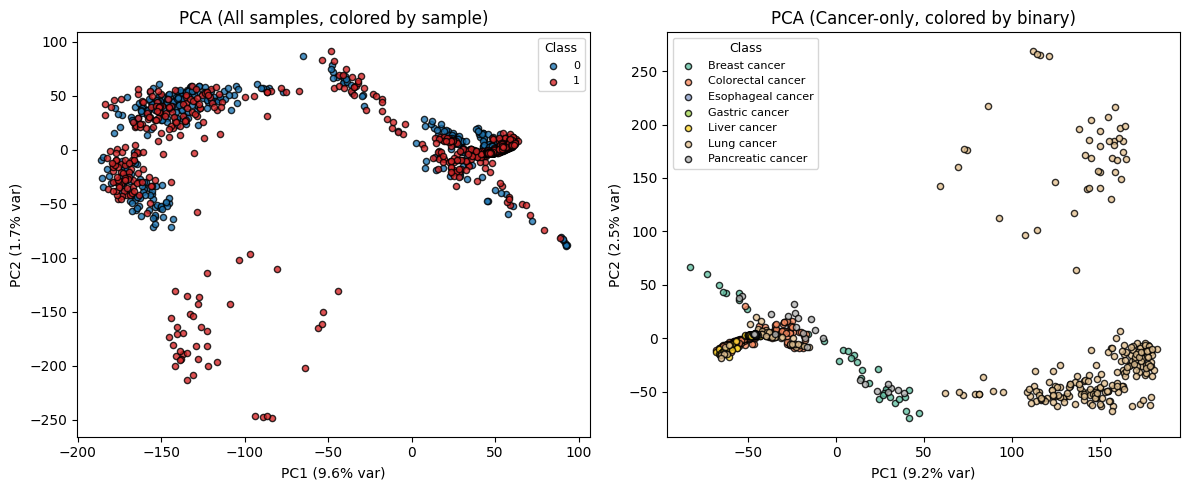

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Extract features
X = data_with_labels_df.iloc[:, :-2]

# Explicitly get labels
binary_label = data_with_labels_df.iloc[:, -1]  # second-to-last column
sample_label = data_with_labels_df.iloc[:, -2]  # last column

# Scale features
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# --- PCA 1: all samples, colored by binary variable ---
pca_all = PCA(n_components=2)
X_pca_all = pca_all.fit_transform(X_scaled)

# --- PCA 2: only cancer samples, colored by sample label ---
cancer_mask = binary_label != 0
X_cancer = X_scaled[cancer_mask]
sample_label_cancer = sample_label[cancer_mask]

pca_cancer = PCA(n_components=2)
X_pca_cancer = pca_cancer.fit_transform(X_cancer)

# --- Plotting helper ---
def plot_pca(X_pca, labels, title, ax, explained_variance):
    unique_labels = np.unique(labels)
    if len(unique_labels) == 2:
        colors = ['#1f77b4', '#d62728']  # binary
    else:
        cmap = plt.cm.get_cmap('Set2', 7)  # 7 discrete colors
        colors = [cmap(i) for i in range(7)]  # Convert to list for indexing

    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.8,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}% var)")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# --- Create side-by-side PCA plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_pca(
    X_pca_all,
    binary_label,
    f"PCA (All samples, colored by {data_with_labels_df.columns[-2]})",
    axes[0],
    pca_all.explained_variance_ratio_
)

plot_pca(
    X_pca_cancer,
    sample_label_cancer,
    f"PCA (Cancer-only, colored by {data_with_labels_df.columns[-1]})",
    axes[1],
    pca_cancer.explained_variance_ratio_
)

plt.tight_layout()
plt.show()


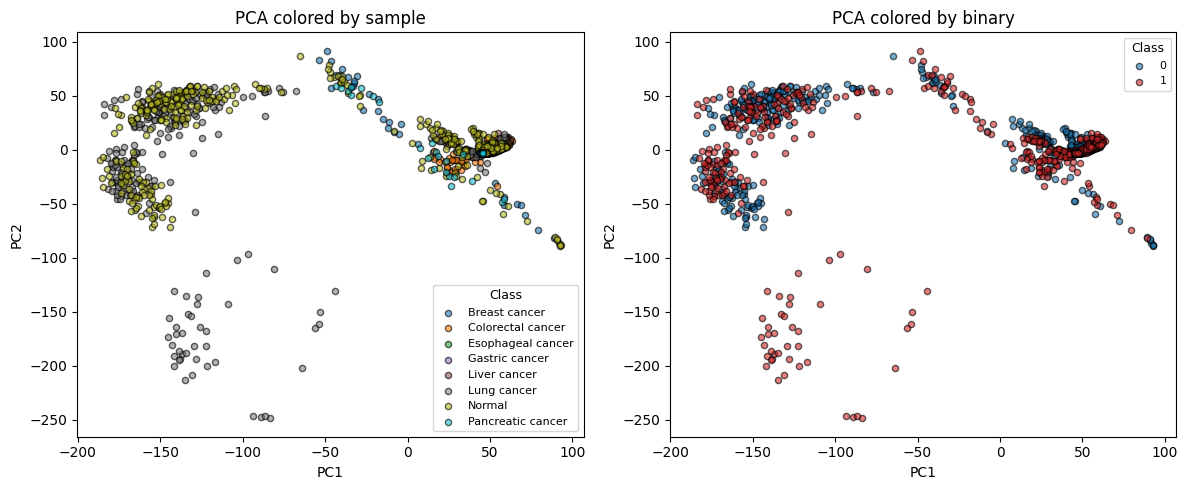

In [ ]:
#second plot has all samples not just cancer ones

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Separate features and labels
X = data_with_labels_df.iloc[:, :-2]
label_1 = data_with_labels_df.iloc[:, -2]
label_2 = data_with_labels_df.iloc[:, -1]

# Scale features (PCA is sensitive to scale)
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Compute PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Function to make a PCA scatterplot with legend
def plot_pca(X_pca, labels, title, ax):
    unique_labels = np.unique(labels)
    if len(unique_labels) == 2:
        # Binary: use clear red vs blue
        colors = ['#1f77b4', '#d62728']  # blue, red
    else:
        # Multi-class: use tab10 categorical palette
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.6,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_pca(X_pca, label_1, f"PCA colored by {data_with_labels_df.columns[-2]}", axes[0])
plot_pca(X_pca, label_2, f"PCA colored by {data_with_labels_df.columns[-1]}", axes[1])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


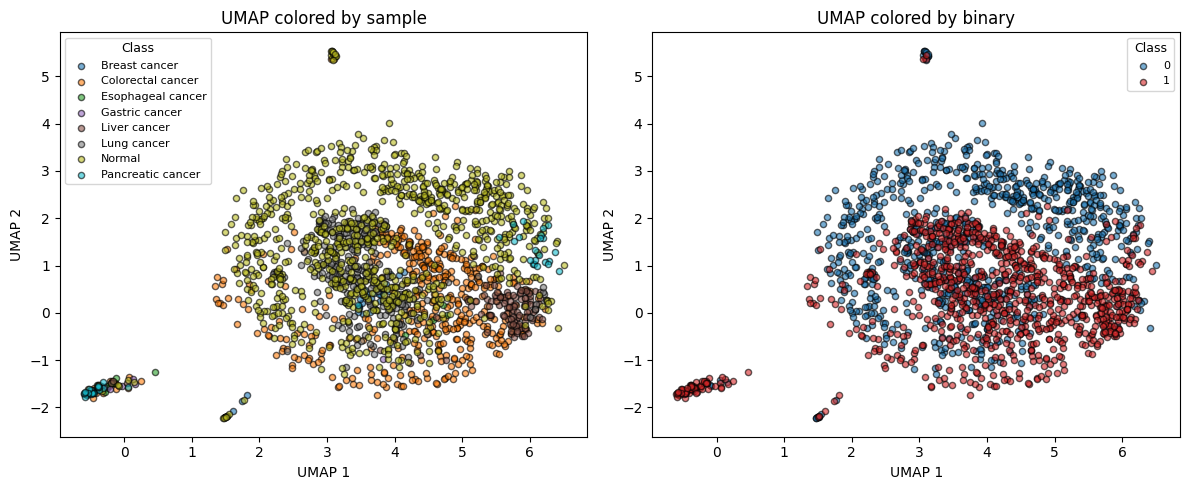

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = data_with_labels_df.iloc[:, :-2]
label_1 = data_with_labels_df.iloc[:, -2]
label_2 = data_with_labels_df.iloc[:, -1]

# Scale features before UMAP (important!)
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X_scaled)

def plot_umap(X_umap, labels, title, ax):
    unique_labels = np.unique(labels)

    # Color scheme (same logic as PCA)
    if len(unique_labels) == 2:
        colors = ['#1f77b4', '#d62728']  # blue, red
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot each label group
    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.6,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_umap(X_umap, label_1, f"UMAP colored by {data_with_labels_df.columns[-2]}", axes[0])
plot_umap(X_umap, label_2, f"UMAP colored by {data_with_labels_df.columns[-1]}", axes[1])

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


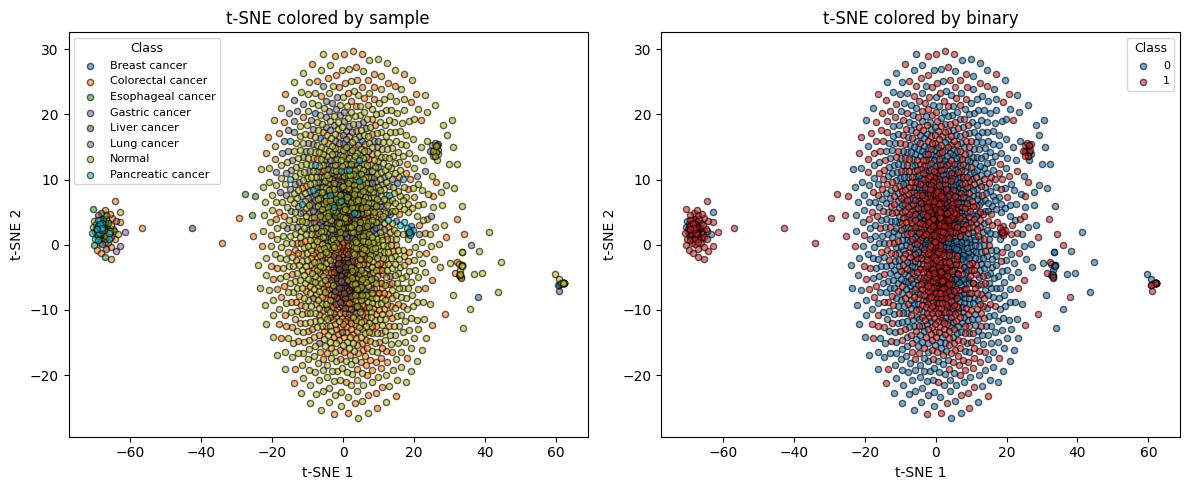

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = data_with_labels_df.iloc[:, :-2]
label_1 = data_with_labels_df.iloc[:, -2]
label_2 = data_with_labels_df.iloc[:, -1]

# Scale features before t-SNE
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Run t-SNE (this can take a few minutes on CPU)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

def plot_tsne(X_tsne, labels, title, ax):
    unique_labels = np.unique(labels)

    # Distinct colors: blue/red for binary, tab10 otherwise
    if len(unique_labels) == 2:
        colors = ['#1f77b4', '#d62728']  # blue, red
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot each label
    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.6,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_tsne(X_tsne, label_1, f"t-SNE colored by {data_with_labels_df.columns[-2]}", axes[0])
plot_tsne(X_tsne, label_2, f"t-SNE colored by {data_with_labels_df.columns[-1]}", axes[1])

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


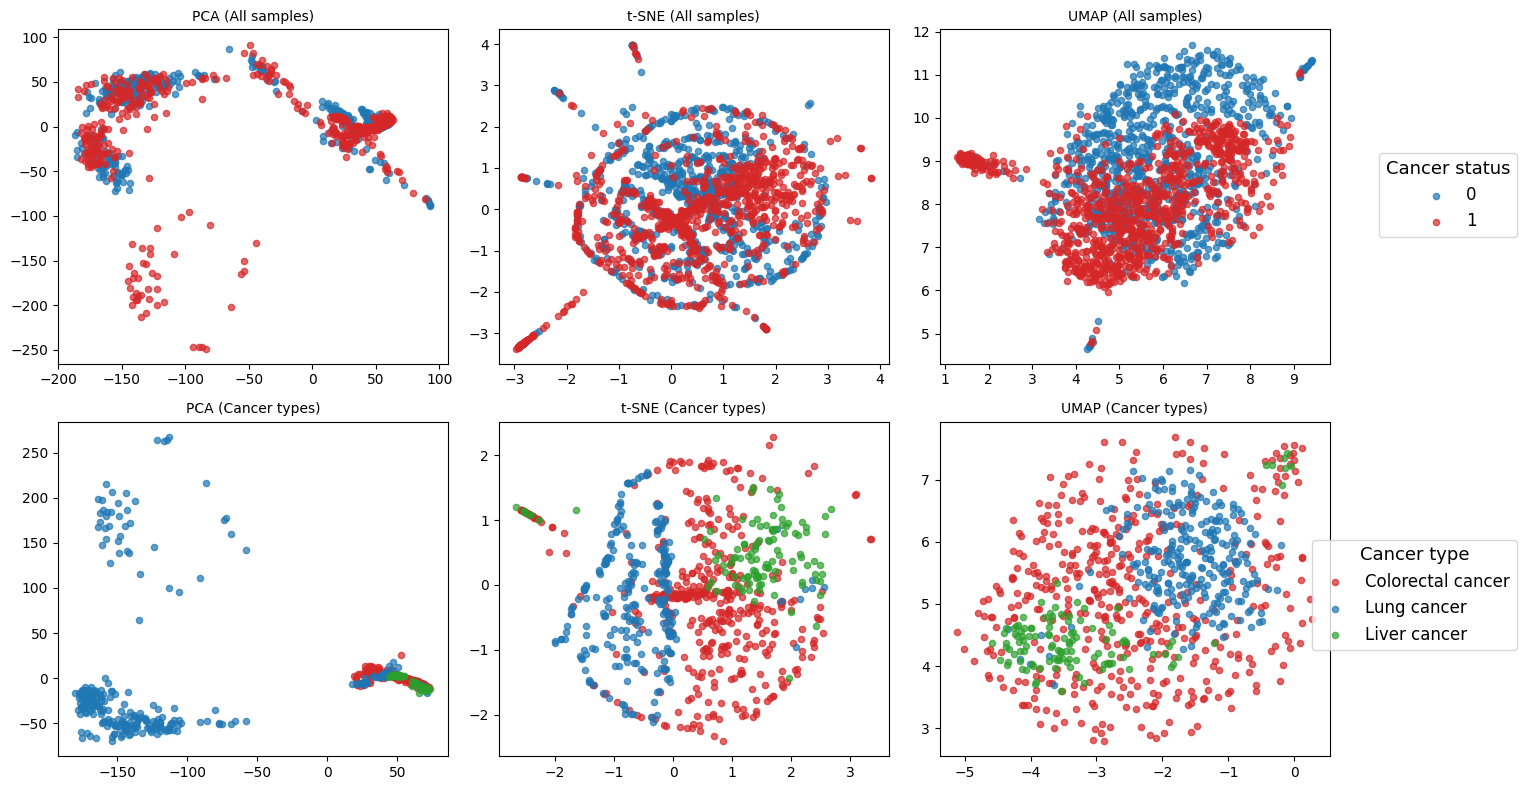

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

# --- Extract features and labels ---
X = data_with_labels_df.iloc[:, :-2]
binary_label = data_with_labels_df.iloc[:, -1]
sample_label = data_with_labels_df.iloc[:, -2]

# Scale features
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# --- Cancer mask: restrict to CRC / Lung / Liver ---
allowed_cancers = ["Colorectal cancer", "Lung cancer", "Liver cancer"]
cancer_mask = sample_label.isin(allowed_cancers)

X_cancer = X_scaled[cancer_mask]
sample_label_cancer = sample_label[cancer_mask]

# --- Compute embeddings ---
# PCA
pca_all = PCA(n_components=2).fit_transform(X_scaled)
pca_cancer = PCA(n_components=2).fit_transform(X_cancer)

# t-SNE
tsne_all = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X_scaled)
tsne_cancer = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X_cancer)

# UMAP
umap_all = umap.UMAP(n_components=2, random_state=42,
                     n_neighbors=30, min_dist=0.2).fit_transform(X_scaled)
umap_cancer = umap.UMAP(n_components=2, random_state=42,
                        n_neighbors=30, min_dist=0.2).fit_transform(X_cancer)

# --- Color maps ---
binary_colors = {
    0: "#1f77b4",  # non-cancer (blue)
    1: "#d62728",  # cancer (red)
}

cancer_type_colors = {
    "Colorectal cancer": "#d62728",  # red
    "Lung cancer": "#1f77b4",         # blue
    "Liver cancer": "#2ca02c",        # green
}

# --- Helper function (no legend here) ---
def plot_embedding(X_emb, labels, title, ax, color_map):
    for label, color in color_map.items():
        mask = labels == label
        if np.any(mask):
            ax.scatter(
                X_emb[mask, 0], X_emb[mask, 1],
                color=color,
                label=str(label),
                alpha=0.7,
                s=20
            )
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# --- Create 2x3 figure ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Top row: all samples, binary labels
plot_embedding(pca_all, binary_label, "PCA (All samples)", axes[0, 0], binary_colors)
plot_embedding(tsne_all, binary_label, "t-SNE (All samples)", axes[0, 1], binary_colors)
plot_embedding(umap_all, binary_label, "UMAP (All samples)", axes[0, 2], binary_colors)

# Bottom row: cancer-only, CRC / Lung / Liver
plot_embedding(pca_cancer, sample_label_cancer, "PCA (Cancer types)", axes[1, 0], cancer_type_colors)
plot_embedding(tsne_cancer, sample_label_cancer, "t-SNE (Cancer types)", axes[1, 1], cancer_type_colors)
plot_embedding(umap_cancer, sample_label_cancer, "UMAP (Cancer types)", axes[1, 2], cancer_type_colors)

# --- Legends: one per row ---
handles_bin, labels_bin = axes[0, 0].get_legend_handles_labels()
handles_type, labels_type = axes[1, 0].get_legend_handles_labels()

fig.legend(
    handles_bin, labels_bin,
    loc="center right",
    bbox_to_anchor=(1.10, 0.75),
    title="Cancer status",
    fontsize=12,
    title_fontsize=13
)

fig.legend(
    handles_type, labels_type,
    loc="center right",
    bbox_to_anchor=(1.10, 0.25),
    title="Cancer type",
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# --- Save figure ---
fig_path = DATA / "EDA_preftselect.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()


# Scrap work from Initial Test Downloads of a few files

In [ ]:
# IGNORE
!cp "/content/drive/MyDrive/GSM7657840.CG.dm.txt_v3.bw.cg" ./test_bc.bw
!cp "/content/drive/MyDrive/GSM2464828.CG.dm.txt_v3.bw.cg" ./test_normal.bw

bw_bc = pyBigWig.open("test_bc.bw")

bw_normal = pyBigWig.open("test_normal.bw")

In [ ]:
for chrom in list(bw.chroms().keys()):
    print(chrom)
    #if chrom == "chr1":
        #print(bw.intervals(chrom))

In [ ]:
intervals_bc = bw_bc.intervals("chr1")
df_bc = pd.DataFrame(intervals_bc, columns=['start', 'end', 'value'])
print(df_bc)

intervals_normal = bw_normal.intervals("chr1")
df_normal = pd.DataFrame(intervals_normal, columns=['start', 'end', 'value'])
print(df_normal)

In [ ]:
count=0
count_match = 0
for index, row in df_bc.iterrows():
  start = row['start']
  end = row['end']
  value = row['value']
  if not df_normal.loc[(df_normal['start'] == start) & (df_normal['end'] == end)].empty:
    count_match+=1
  count+=1
  if count == 10000:
    break
print(count_match, count)

In [ ]:
bw.close()

# Feature Selection

In [ ]:
data_df

,chr1:0,chr1:40000,chr1:80000,chr1:120000,chr1:160000,chr1:200000,chr1:240000,chr1:280000,chr1:320000,chr1:360000,...,chrX:155680000,chrX:155720000,chrX:155760000,chrX:155800000,chrX:155840000,chrX:155880000,chrX:155920000,chrX:155960000,chrX:156000000,chrX:156040000
GSM2090507,0.769231,-0.948718,-0.750000,0.144722,0.442980,NaN,0.083020,0.250000,NaN,NaN,...,0.051471,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090508,0.673611,NaN,NaN,0.167780,0.245006,NaN,0.041667,NaN,NaN,NaN,...,0.214815,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090509,0.911111,NaN,NaN,0.750000,0.250000,NaN,NaN,NaN,NaN,NaN,...,-0.030275,0.370837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090510,0.911111,NaN,0.000000,0.166667,0.000000,NaN,NaN,NaN,NaN,NaN,...,-0.348485,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2090511,NaN,NaN,NaN,0.958333,0.666667,NaN,NaN,NaN,NaN,NaN,...,0.191301,0.527392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX9388477,1.000000,0.280392,0.026042,-0.633333,-0.522619,NaN,-0.336667,0.875000,NaN,NaN,...,-0.242713,-0.361538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRX9388478,1.000000,NaN,-0.125000,-0.307692,0.444445,-1.00,-0.494445,1.000000,NaN,NaN,...,-0.266300,-0.135586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRX9388479,0.071429,-0.014264,0.369725,-0.045455,-0.242424,NaN,-0.562500,NaN,NaN,NaN,...,0.210727,0.049914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRX9388480,0.052632,NaN,1.000000,-0.475000,-0.281313,-0.75,-0.446839,-0.184353,NaN,NaN,...,0.175758,0.435185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
y_data

,sample,binary
GSM2090507,Colorectal cancer,1
GSM2090508,Colorectal cancer,1
GSM2090509,Colorectal cancer,1
GSM2090510,Colorectal cancer,1
GSM2090511,Colorectal cancer,1
...,...,...
SRX9388477,Normal,0
SRX9388478,Normal,0
SRX9388479,Pancreatic cancer,1
SRX9388480,Pancreatic cancer,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(data_df, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1282, 75788)
(368, 75788)
(182, 75788)
(1282, 2)
(368, 2)
(182, 2)


In [ ]:
y_train_binary = y_train['binary']
y_train_binary

,binary
SRX6921064,1
SRX6723694,0
SRX6943303,0
SRX6723646,0
GSM2446950,1
...,...
SRX6921089,1
SRX6942409,0
SRX6724083,0
SRX6942683,0


In [ ]:
from scipy.stats import mannwhitneyu
import pandas as pd

# Parameters
pval_threshold = 0.05

# Store results
significant_features = []
p_values = []

for col in X_train.columns:
    # Boolean masks using the binary column
    mask1 = y_train_binary == 1
    mask0 = y_train_binary == 0

    # Drop NaNs per group
    group1 = X_train.loc[mask1, col].dropna()
    group0 = X_train.loc[mask0, col].dropna()

    # Skip feature if one group has no data
    if len(group1) == 0 or len(group0) == 0:
        p_values.append(np.nan)
        continue

    # Mann–Whitney U test
    _, p = mannwhitneyu(group1, group0, alternative='two-sided')
    p_values.append(p)

    if p < pval_threshold:
        significant_features.append(col)

# Convert p-values to Series for easy inspection
p_values_series = pd.Series(p_values, index=X_train.columns)

print(f"Number of significant features (p < {pval_threshold}): {len(significant_features)}")
print("Example significant features:", significant_features[:10])


Number of significant features (p < 0.05): 17037
Example significant features: ['chr1:0', 'chr1:40000', 'chr1:160000', 'chr1:600000', 'chr1:680000', 'chr1:720000', 'chr1:800000', 'chr1:840000', 'chr1:920000', 'chr1:1000000']


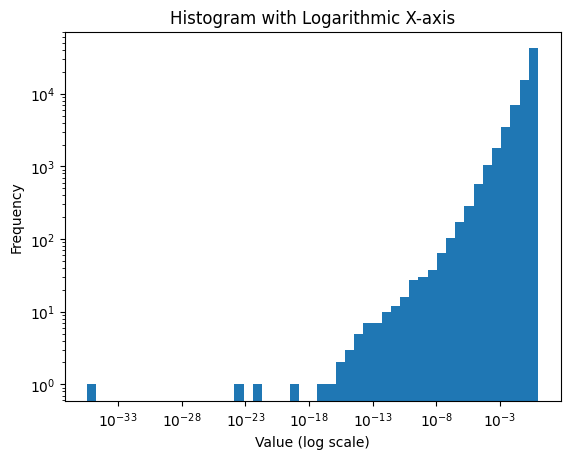

In [ ]:
# Define logarithmic bins
min_val = np.min(p_values_series[p_values_series > 0]) # Ensure positive values for log scale
max_val = np.max(p_values_series)
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

plt.hist(p_values_series, bins=log_bins, log = True)
plt.xscale('log')
plt.title("Histogram with Logarithmic X-axis")
plt.xlabel("Value (log scale)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from statsmodels.stats.multitest import multipletests

alpha = 0.01

# FDR correction
reject, pvals_corrected, _, _ = multipletests(p_values_series.fillna(1), alpha=alpha, method='fdr_bh')

# Use reject array to get feature names
significant_features_fdr = p_values_series.index[reject]

print(f"Number of significant features (FDR < {alpha}): {len(significant_features_fdr)}")



Number of significant features (FDR < 0.01): 2746


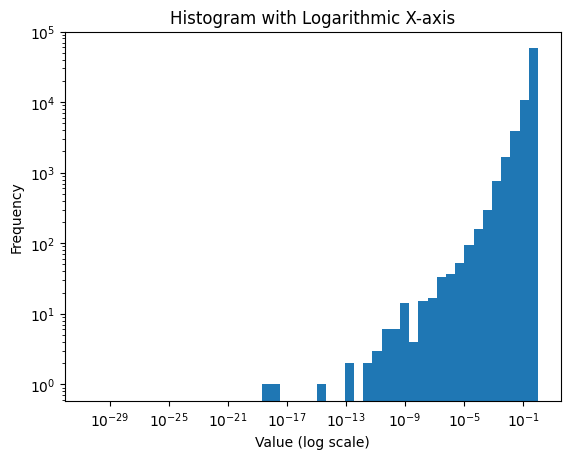

In [ ]:
# Define logarithmic bins
min_val = np.min(pvals_corrected[pvals_corrected > 0]) # Ensure positive values for log scale
max_val = np.max(pvals_corrected)
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

plt.hist(pvals_corrected, bins=log_bins, log = True)
plt.xscale('log')
plt.title("Histogram with Logarithmic X-axis")
plt.xlabel("Value (log scale)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
significant_features_fdr

Index(['chr1:800000', 'chr1:840000', 'chr1:1000000', 'chr1:1440000',
       'chr1:1800000', 'chr1:1960000', 'chr1:2040000', 'chr1:2200000',
       'chr1:2920000', 'chr1:3320000',
       ...
       'chrX:121280000', 'chrX:134040000', 'chrX:134760000', 'chrX:134840000',
       'chrX:135440000', 'chrX:146720000', 'chrX:148520000', 'chrX:151600000',
       'chrX:153840000', 'chrX:155600000'],
      dtype='object', length=2746)

In [ ]:
sig_features_path = DATA / 'sig_features.csv'
pd.Series(significant_features_fdr, name='feature').to_csv(sig_features_path, index=False)

In [ ]:
sig_features_path = DATA / 'sig_features.csv'
significant_features_fdr = pd.read_csv(sig_features_path)['feature'].astype(str).values

# Repeat EDA after feature selection

In [ ]:
data_with_labels_postft_df = data_with_labels_df.copy()[significant_features_fdr]
data_with_labels_postft_df = data_with_labels_postft_df.join(y_data)

data_with_labels_postft_df

,chr1:800000,chr1:840000,chr1:1000000,chr1:1440000,chr1:1800000,chr1:1960000,chr1:2040000,chr1:2200000,chr1:2920000,chr1:3320000,...,chrX:134760000,chrX:134840000,chrX:135440000,chrX:146720000,chrX:148520000,chrX:151600000,chrX:153840000,chrX:155600000,sample,binary
GSM2090507,-0.041120,-0.026826,0.015720,-0.029046,0.015435,0.047034,0.044247,-0.002827,0.229083,-0.087147,...,-0.108492,-0.071484,-0.064918,-0.074074,0.109091,0.077933,-0.031640,-0.183698,Colorectal cancer,1
GSM2090508,0.018468,-0.031749,0.015337,0.007621,-0.071695,0.082584,0.082733,0.037202,0.097179,-0.053027,...,-0.048883,0.280678,0.070129,-0.035425,-0.027713,0.033340,-0.009747,-0.076656,Colorectal cancer,1
GSM2090509,-0.102679,-0.060606,-0.038721,-0.063039,-0.104033,0.097654,0.011951,-0.006578,0.088208,-0.038671,...,-0.221698,0.249689,0.012561,1.000000,-0.087953,-0.098581,0.009443,0.609352,Colorectal cancer,1
GSM2090510,-0.016413,-0.083134,0.018411,-0.024514,-0.186146,0.039183,-0.040700,-0.007231,0.027810,0.023975,...,0.107150,-0.064746,0.251373,0.090909,0.040733,0.328148,0.000224,-0.227355,Colorectal cancer,1
GSM2090511,0.047619,-0.024854,-0.029379,-0.066761,-0.111288,-0.142089,-0.002053,0.011381,0.086379,-0.088507,...,0.579917,0.106441,0.059067,-0.500000,-0.056889,-0.215856,0.013389,0.229688,Colorectal cancer,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX9388477,-0.020689,-0.050946,0.099030,0.072154,-0.113906,-0.087894,0.170072,0.120405,0.266878,0.234959,...,0.097188,-0.117727,0.022714,-0.214925,0.112744,0.100083,-0.062805,0.116545,Normal,0
SRX9388478,0.177456,0.263902,0.032843,0.028515,-0.078418,-0.085725,0.037719,0.054510,0.110511,0.158549,...,0.105863,0.057882,-0.266685,-0.112853,0.126225,-0.143868,-0.142712,0.124709,Normal,0
SRX9388479,0.269565,0.109785,0.000472,0.224934,0.009598,-0.276747,0.186232,0.130286,-0.083134,0.028117,...,-0.009805,0.070586,0.015042,0.314228,0.109760,0.261177,-0.000989,-0.309524,Pancreatic cancer,1
SRX9388480,0.029767,0.121945,0.087585,0.173263,0.003402,-0.163906,0.269003,0.112531,0.107981,0.041110,...,-0.127804,0.050719,-0.083476,-0.062227,0.006664,-0.152896,0.004121,-0.257094,Pancreatic cancer,1


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1240244709.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', 7)  # 7 discrete colors


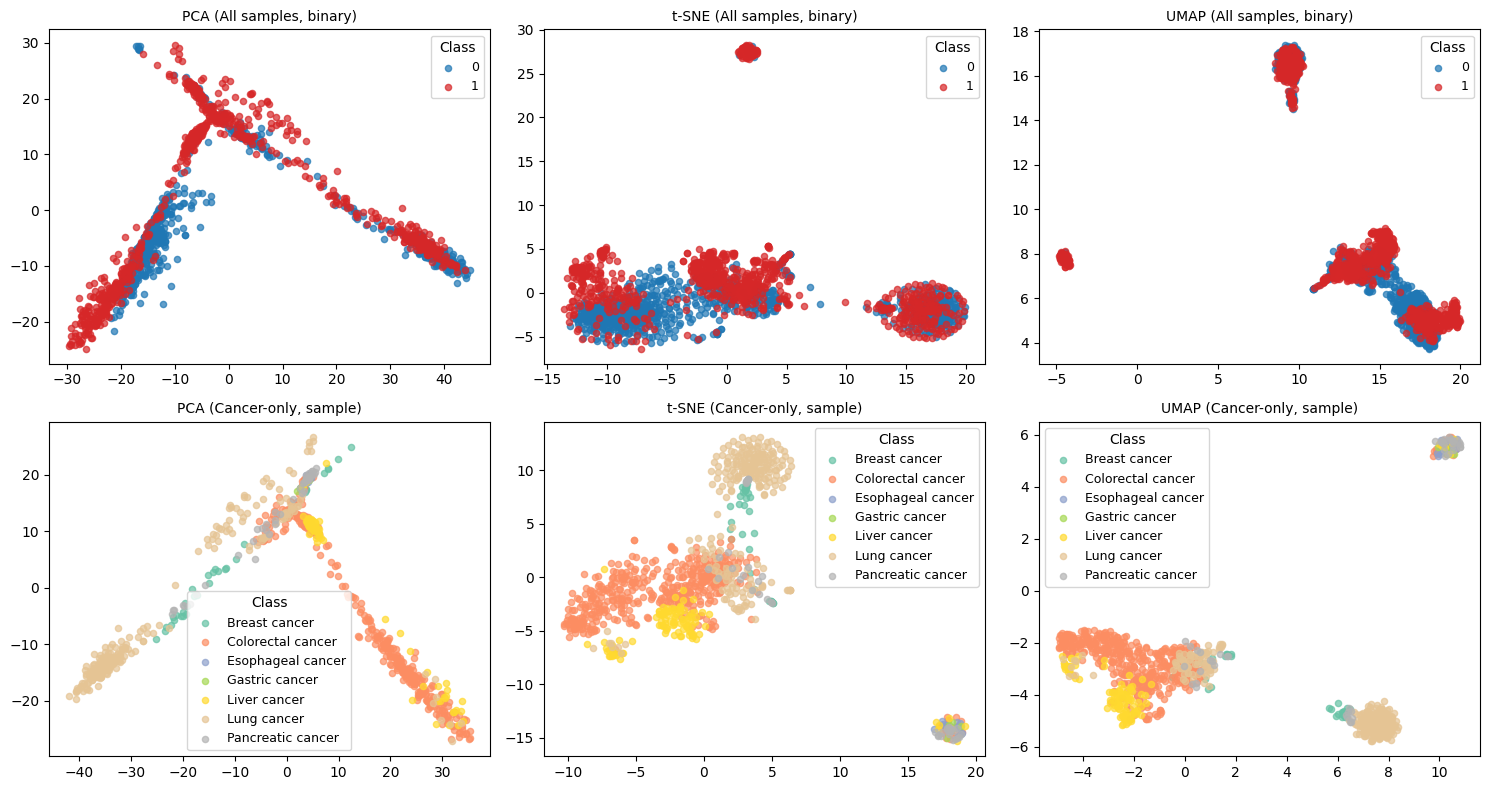

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

# --- Extract features and labels ---
X = data_with_labels_postft_df.iloc[:, :-2]
binary_label = data_with_labels_postft_df.iloc[:, -1]
sample_label = data_with_labels_postft_df.iloc[:, -2]

# Scale features
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Cancer mask
cancer_mask = binary_label != 0
X_cancer = X_scaled[cancer_mask]
sample_label_cancer = sample_label[cancer_mask]

# --- Compute embeddings ---
# PCA
pca_all = PCA(n_components=2).fit_transform(X_scaled)
pca_cancer = PCA(n_components=2).fit_transform(X_cancer)

# t-SNE
tsne_all = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X_scaled)
tsne_cancer = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X_cancer)

# UMAP
umap_all = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.2).fit_transform(X_scaled)
umap_cancer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.2).fit_transform(X_cancer)

# --- Helper function for plotting ---
def plot_embedding(X_emb, labels, title, ax):
    unique_labels = np.unique(labels)
    if len(unique_labels) == 2:
        colors = ['#1f77b4', '#d62728']  # binary
    else:
        cmap = plt.cm.get_cmap('Set2', 7)  # 7 discrete colors
        colors = [cmap(i) for i in range(7)]  # Convert to list for indexing
    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_emb[mask, 0], X_emb[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.7,
                   #edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(title="Class", fontsize=9, title_fontsize=10, frameon=True)

# --- Create 3x2 figure ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Top row: all samples, colored by binary
plot_embedding(pca_all, binary_label, "PCA (All samples, binary)", axes[0,0])
plot_embedding(tsne_all, binary_label, "t-SNE (All samples, binary)", axes[0,1])
plot_embedding(umap_all, binary_label, "UMAP (All samples, binary)", axes[0,2])

# Bottom row: cancer-only, colored by sample type
plot_embedding(pca_cancer, sample_label_cancer, "PCA (Cancer-only, sample)", axes[1,0])
plot_embedding(tsne_cancer, sample_label_cancer, "t-SNE (Cancer-only, sample)", axes[1,1])
plot_embedding(umap_cancer, sample_label_cancer, "UMAP (Cancer-only, sample)", axes[1,2])

plt.tight_layout()

# --- Save figure ---
fig_path = DATA / "EDA_postftselect.png"  # adjust file type if needed (e.g., .pdf)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

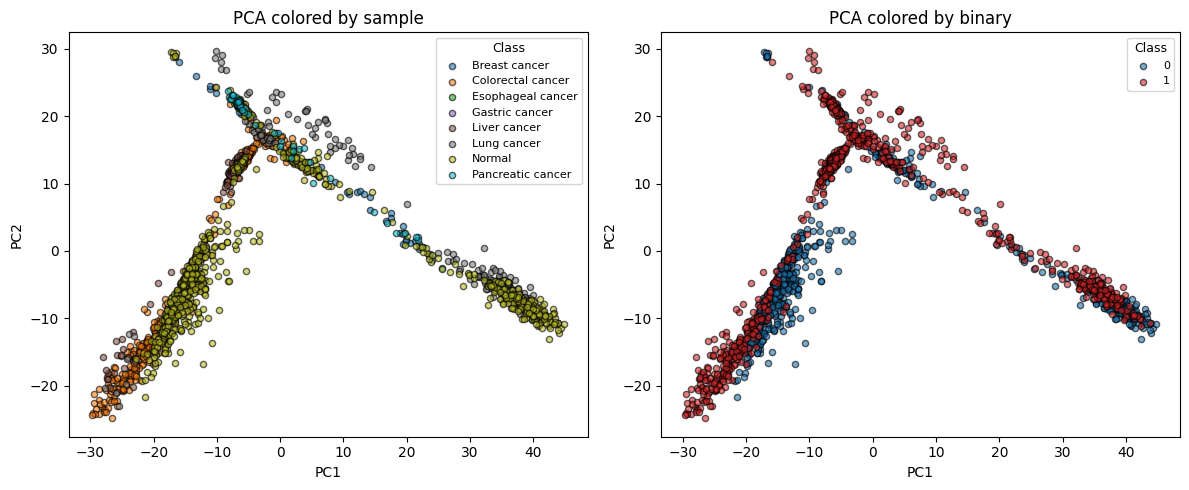

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Separate features and labels
X = data_with_labels_postft_df.iloc[:, :-2]
label_1 = data_with_labels_postft_df.iloc[:, -2]
label_2 = data_with_labels_postft_df.iloc[:, -1]

# Scale features (PCA is sensitive to scale)
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Compute PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Function to make a PCA scatterplot with legend
def plot_pca(X_pca, labels, title, ax):
    unique_labels = np.unique(labels)
    if len(unique_labels) == 2:
        # Binary: use clear red vs blue
        colors = ['#1f77b4', '#d62728']  # blue, red
    else:
        # Multi-class: use tab10 categorical palette
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.6,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_pca(X_pca, label_1, f"PCA colored by {data_with_labels_postft_df.columns[-2]}", axes[0])
plot_pca(X_pca, label_2, f"PCA colored by {data_with_labels_postft_df.columns[-1]}", axes[1])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


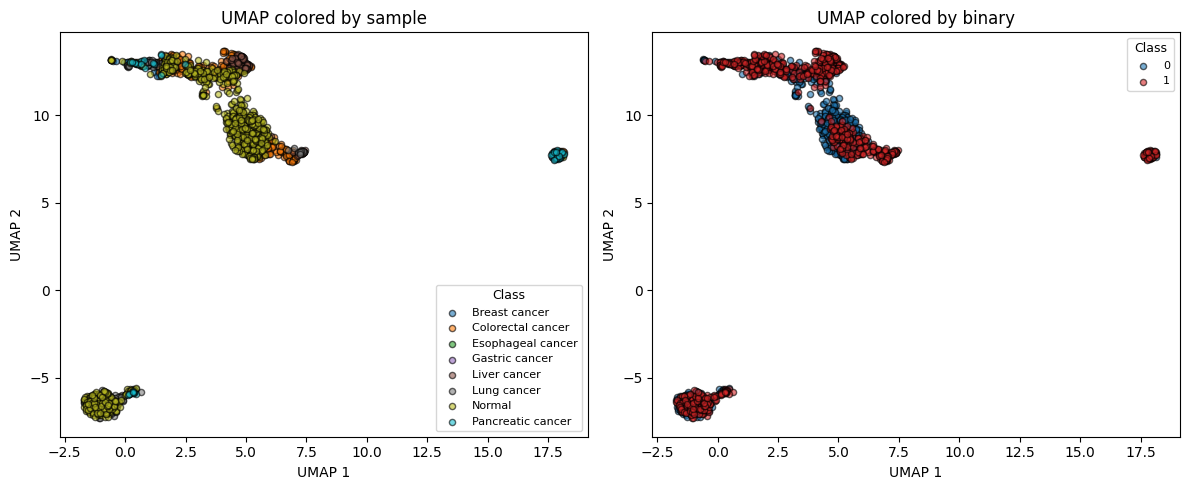

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = data_with_labels_postft_df.iloc[:, :-2]
label_1 = data_with_labels_postft_df.iloc[:, -2]
label_2 = data_with_labels_postft_df.iloc[:, -1]

# Scale features before UMAP (important!)
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X_scaled)

def plot_umap(X_umap, labels, title, ax):
    unique_labels = np.unique(labels)

    # Color scheme (same logic as PCA)
    if len(unique_labels) == 2:
        colors = ['#1f77b4', '#d62728']  # blue, red
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot each label group
    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.6,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_umap(X_umap, label_1, f"UMAP colored by {data_with_labels_postft_df.columns[-2]}", axes[0])
plot_umap(X_umap, label_2, f"UMAP colored by {data_with_labels_postft_df.columns[-1]}", axes[1])

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


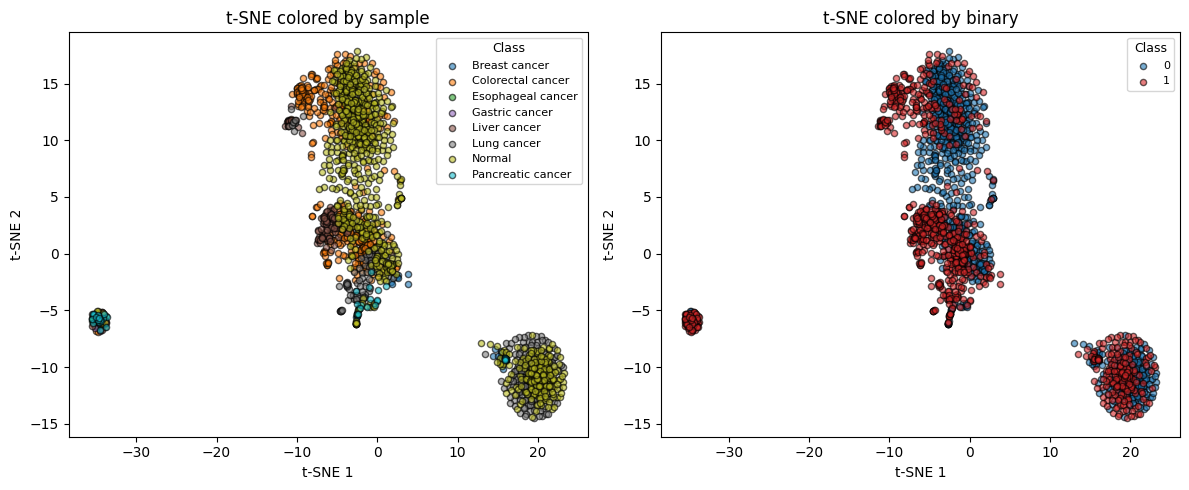

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = data_with_labels_postft_df.iloc[:, :-2]
label_1 = data_with_labels_postft_df.iloc[:, -2]
label_2 = data_with_labels_postft_df.iloc[:, -1]

# Scale features before t-SNE
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# Run t-SNE (this can take a few minutes on CPU)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

def plot_tsne(X_tsne, labels, title, ax):
    unique_labels = np.unique(labels)

    # Distinct colors: blue/red for binary, tab10 otherwise
    if len(unique_labels) == 2:
        colors = ['#1f77b4', '#d62728']  # blue, red
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot each label
    for i, ul in enumerate(unique_labels):
        mask = labels == ul
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   color=colors[i],
                   label=str(ul),
                   alpha=0.6,
                   edgecolor='k',
                   s=20)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(title="Class", fontsize=8, title_fontsize=9, frameon=True)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_tsne(X_tsne, label_1, f"t-SNE colored by {data_with_labels_postft_df.columns[-2]}", axes[0])
plot_tsne(X_tsne, label_2, f"t-SNE colored by {data_with_labels_postft_df.columns[-1]}", axes[1])

plt.tight_layout()
plt.show()


# New Load Data

In [ ]:
X_train_postft = pd.read_csv(DATA / 'X_train_postft.csv')
X_val_postft = pd.read_csv(DATA / 'X_val_postft.csv')
X_test_postft = pd.read_csv(DATA / 'X_test_postft.csv')
X_train_postlasso = pd.read_csv(DATA / 'X_train_postlasso.csv')
X_val_postlasso = pd.read_csv(DATA / 'X_val_postlasso.csv')
X_test_postlasso = pd.read_csv(DATA / 'X_test_postlasso.csv')

In [ ]:
y_train = pd.read_csv(DATA / 'y_train.csv')
y_val = pd.read_csv(DATA / 'y_val.csv')
y_test = pd.read_csv(DATA / 'y_test.csv')

In [ ]:
gene_df_path = DATA / "gene_df.csv"

gene_df = pd.read_csv(gene_df_path)

# Lasso Regression



In [ ]:
X_train_postft = X_train[significant_features_fdr]
X_val_postft = X_val[significant_features_fdr]
X_test_postft = X_test[significant_features_fdr]
print(X_train_postft.shape)
print(X_val_postft.shape)
print(X_test_postft.shape)

(1282, 2746)
(368, 2746)
(182, 2746)


In [ ]:
X_train_postft.to_csv(DATA / 'X_train_postft.csv', index=False)
X_val_postft.to_csv(DATA / 'X_val_postft.csv', index=False)
X_test_postft.to_csv(DATA / 'X_test_postft.csv', index=False)

In [ ]:
y_train.to_csv(DATA / 'y_train.csv', index=False)
y_val.to_csv(DATA / 'y_val.csv', index=False)
y_test.to_csv(DATA / 'y_test.csv', index=False)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

lasso = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=10000, n_jobs=-1)
)

lasso.fit(X_train_postft, y_train['binary'])
y_val_pred = lasso.predict_proba(X_val_postft)[:, 1]

print("Validation Lasso AUROC:", roc_auc_score(y_val['binary'], y_val_pred))
print("Validation Lasso AUPR :", average_precision_score(y_val['binary'], y_val_pred))

Validation Lasso AUROC: 0.8701214287824622
Validation Lasso AUPR : 0.8572980460063097


In [ ]:
y_test_pred = lasso.predict_proba(X_test_postft)[:, 1]

print("Test Lasso AUROC:", roc_auc_score(y_test['binary'], y_test_pred))
print("Test Lasso AUPR :", average_precision_score(y_test['binary'], y_test_pred))

Test Lasso AUROC: 0.9069739235900546
Test Lasso AUPR : 0.8831853329957444


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# 1. Get predicted probabilities and predicted classes
y_val_pred_proba = lasso.predict_proba(X_val_postft)[:, 1]
y_val_pred_class = (y_val_pred_proba >= 0.5).astype(int)  # threshold 0.5

# 2. Print classification report (per-class performance)
print("Classification report:")
print(classification_report(y_val['binary'], y_val_pred_class, target_names=['Normal', 'Cancer']))

# 3. Extract non-zero coefficients from Lasso
# The pipeline has steps: SimpleImputer, StandardScaler, LogisticRegression
coef = lasso.named_steps['logisticregression'].coef_.ravel()  # shape = (n_features,)

# 4. Count non-zero coefficients
nonzero_count = np.sum(coef != 0)
print(f"Number of non-zero features: {nonzero_count} / {len(coef)}")

# 5. Create a DataFrame of feature names and coefficients
feature_importance = pd.DataFrame({
    'feature': X_train_postft.columns,
    'coef': coef
})

# Sort by absolute value to see most impactful features
feature_importance['abs_coef'] = np.abs(feature_importance['coef'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

print("Top 10 features by absolute weight:")
print(feature_importance.head(10))


Classification report:
              precision    recall  f1-score   support

      Normal       0.81      0.78      0.79       187
      Cancer       0.78      0.82      0.80       181

    accuracy                           0.80       368
   macro avg       0.80      0.80      0.80       368
weighted avg       0.80      0.80      0.80       368

Number of non-zero features: 715 / 2746
Top 10 features by absolute weight:
              feature      coef  abs_coef
1541   chr2:239040000  0.623379  0.623379
1175   chr17:82400000  0.565817  0.565817
2467   chr7:157960000  0.479590  0.479590
1859   chr3:197400000  0.452217  0.452217
672   chr12:124440000 -0.376097  0.376097
2092   chr5:132960000 -0.331118  0.331118
1087   chr17:26760000  0.326746  0.326746
848    chr15:28920000 -0.326363  0.326363
2533    chr8:48200000 -0.326110  0.326110
2719    chrX:45040000  0.324450  0.324450


In [ ]:
# 1. Predicted probabilities and classes on the test set
y_test_pred_proba = lasso.predict_proba(X_test_postft)[:, 1]
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # threshold 0.5

# 2. AUROC and AUPR
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))

# 3. Classification report
print("\nClassification report on test set:")
print(classification_report(
    y_test['binary'],
    y_test_pred_class,
    target_names=['Normal', 'Cancer']
))


Test AUROC: 0.907
Test AUPR : 0.883

Classification report on test set:
              precision    recall  f1-score   support

      Normal       0.81      0.84      0.82        97
      Cancer       0.80      0.78      0.79        85

    accuracy                           0.81       182
   macro avg       0.81      0.81      0.81       182
weighted avg       0.81      0.81      0.81       182



In [ ]:
feature_importance.head(10)['feature'].values

array(['chr2:239040000', 'chr17:82400000', 'chr7:157960000',
       'chr3:197400000', 'chr12:124440000', 'chr5:132960000',
       'chr17:26760000', 'chr15:28920000', 'chr8:48200000',
       'chrX:45040000'], dtype=object)

In [ ]:
# Assuming:
# - lasso_top_features is a list of top 10 features from your LASSO model
# - gene_df has columns ['chrom', 'start', 'end', 'gene_name']

top_features = feature_importance.head(10)['feature'].values
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr2:239040000 (chr2:239040000-239080000)
Overlapping genes:
   HDAC4
   MIR4440

Feature: chr17:82400000 (chr17:82400000-82440000)
Overlapping genes:
   OGFOD3
   ENSG00000264812
   Y_RNA
   HEXD
   HEXD-IT1

Feature: chr7:157960000 (chr7:157960000-158000000)
Overlapping genes:
   PTPRN2
   ENSG00000285821

Feature: chr3:197400000 (chr3:197400000-197440000)
Overlapping genes:
   ENSG00000289828

Feature: chr12:124440000 (chr12:124440000-124480000)
Overlapping genes:
   NCOR2

Feature: chr5:132960000 (chr5:132960000-133000000)
Overlapping genes:
   AFF4
   AFF4-DT
   ENSG00000229738
   Y_RNA
   ZCCHC10

Feature: chr17:26760000 (chr17:26760000-26800000)
  No overlapping genes

Feature: chr15:28920000 (chr15:28920000-28960000)
Overlapping genes:
   APBA2

Feature: chr8:48200000 (chr8:48200000-48240000)
  No overlapping genes

Feature: chrX:45040000 (chrX:45040000-45080000)
Overlapping genes:
   KDM6A


In [ ]:
lasso_sig_features_fdr = feature_importance[feature_importance['coef']!=0]['feature'].astype(str).values

In [ ]:
X_train_postlasso = X_train[lasso_sig_features_fdr]
X_val_postlasso = X_val[lasso_sig_features_fdr]
X_test_postlasso = X_test[lasso_sig_features_fdr]
print(X_train_postlasso.shape)
print(X_train_postlasso.shape)
print(X_train_postlasso.shape)

(1282, 715)
(1282, 715)
(1282, 715)


In [ ]:
X_train_postlasso.to_csv(DATA / 'X_train_postlasso.csv', index=False)
X_val_postlasso.to_csv(DATA / 'X_val_postlasso.csv', index=False)
X_test_postlasso.to_csv(DATA / 'X_test_postlasso.csv', index=False)

# Random Forest Pre-Lasso

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Pipeline: median imputation for NaNs, then Random Forest
rf_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
)

# Fit model
rf_pipeline.fit(X_train_postft, y_train['binary'])

# Predict probabilities for validation set
y_val_pred_proba = rf_pipeline.predict_proba(X_val_postft)[:, 1]

# Predict class labels
y_val_pred = rf_pipeline.predict(X_val_postft)

# Metrics
print("Validation AUROC:", roc_auc_score(y_val['binary'], y_val_pred_proba))
print("Validation AUPR :", average_precision_score(y_val['binary'], y_val_pred_proba))
print("\nClassification Report:\n", classification_report(y_val['binary'], y_val_pred))

# Feature importances
rf_model = rf_pipeline.named_steps['randomforestclassifier']
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_postft.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\nTop 10 features by importance:\n", feature_importances.head(10))


Validation AUROC: 0.9024728927231365
Validation AUPR : 0.8959891083817315

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77       187
           1       0.74      0.87      0.80       181

    accuracy                           0.79       368
   macro avg       0.79      0.79      0.78       368
weighted avg       0.80      0.79      0.78       368


Top 10 features by importance:
 chr8:24680000      0.006152
chr1:151120000     0.006098
chr3:157480000     0.006016
chr19:11360000     0.005954
chr1:184240000     0.005508
chr3:74080000      0.005508
chr9:112080000     0.005194
chr12:108760000    0.005012
chr5:173320000     0.004603
chr10:112600000    0.004504
dtype: float64


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd

# Define parameter grids (small for speed)
max_depth_grid = [5, 15, 45, None]
n_estimators_grid = [100, 500, 2500]

# Store results
results = []

for max_depth in max_depth_grid:
    for n_estimators in n_estimators_grid:
        # Build pipeline
        rf_pipeline = make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler(with_mean=True, with_std=True),
            RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=42
            )
        )

        # Fit once on training
        rf_pipeline.fit(X_train_postft, y_train['binary'])

        # Predict on validation
        y_val_pred = rf_pipeline.predict_proba(X_val_postft)[:, 1]

        # Compute metrics
        val_auroc = roc_auc_score(y_val['binary'], y_val_pred)
        val_aupr = average_precision_score(y_val['binary'], y_val_pred)

        # Store results
        results.append({
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'val_auroc': val_auroc,
            'val_aupr': val_aupr,
            'pipeline': rf_pipeline  # store pipeline for later if needed
        })
        print(f"Done: max_depth={max_depth}, n_estimators={n_estimators}, AUROC={val_auroc:.3f}, AUPR={val_aupr:.3f}")

# Convert results to DataFrame for review
results_df = pd.DataFrame(results)

# Find best model (highest AUROC for example)
best_idx = results_df['val_auroc'].idxmax()
best_model = results_df.loc[best_idx, 'pipeline']
print("\nBest parameters:")
print(results_df.loc[best_idx, ['max_depth', 'n_estimators', 'val_auroc', 'val_aupr']])

# Feature importances for best model
rf_model = best_model.named_steps['randomforestclassifier']
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_postft.columns)
print("\nTop 10 features by importance:")
print(feature_importances.sort_values(ascending=False).head(10))

# Optional: classification report
from sklearn.metrics import classification_report
y_val_pred_class = best_model.predict(X_val_postft)
print("\nClassification report on validation set:")
print(classification_report(y_val['binary'], y_val_pred_class))


Done: max_depth=5, n_estimators=100, AUROC=0.892, AUPR=0.883
Done: max_depth=5, n_estimators=500, AUROC=0.897, AUPR=0.891
Done: max_depth=5, n_estimators=2500, AUROC=0.898, AUPR=0.890
Done: max_depth=15, n_estimators=100, AUROC=0.895, AUPR=0.877
Done: max_depth=15, n_estimators=500, AUROC=0.901, AUPR=0.892
Done: max_depth=15, n_estimators=2500, AUROC=0.903, AUPR=0.897
Done: max_depth=45, n_estimators=100, AUROC=0.897, AUPR=0.889
Done: max_depth=45, n_estimators=500, AUROC=0.906, AUPR=0.899
Done: max_depth=45, n_estimators=2500, AUROC=0.904, AUPR=0.899
Done: max_depth=None, n_estimators=100, AUROC=0.897, AUPR=0.889
Done: max_depth=None, n_estimators=500, AUROC=0.906, AUPR=0.899
Done: max_depth=None, n_estimators=2500, AUROC=0.904, AUPR=0.899

Best parameters:
max_depth           45.0
n_estimators         500
val_auroc       0.905708
val_aupr        0.899106
Name: 7, dtype: object

Top 10 features by importance:
chr8:24680000      0.006545
chr3:157480000     0.006023
chr1:151120000     0

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Predict probabilities and classes on the test set
y_test_pred_proba = best_model.predict_proba(X_test_postft)[:, 1]
y_test_pred_class = best_model.predict(X_test_postft)

# AUROC and AUPR
test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))
print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred_class))


Test AUROC: 0.901
Test AUPR : 0.848

Classification report on test set:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        97
           1       0.77      0.84      0.80        85

    accuracy                           0.81       182
   macro avg       0.81      0.81      0.81       182
weighted avg       0.81      0.81      0.81       182



In [ ]:
feature_importances.sort_values(ascending=False).head(10).index

Index(['chr8:24680000', 'chr3:157480000', 'chr1:151120000', 'chr1:184240000',
       'chr19:11360000', 'chr3:74080000', 'chr12:108760000', 'chr8:9360000',
       'chr9:112080000', 'chr19:1320000'],
      dtype='object')

In [ ]:

top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr8:24680000 (chr8:24680000-24720000)
Overlapping genes:
   ADAM7-AS1

Feature: chr3:157480000 (chr3:157480000-157520000)
Overlapping genes:
   VEPH1

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr19:11360000 (chr19:11360000-11400000)
Overlapping genes:
   PLPPR2
   ENSG00000267277
   SWSAP1
   EPOR
   RGL3

Feature: chr3:74080000 (chr3:74080000-74120000)
Overlapping genes:
   ENSG00000223738

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr8:9360000 (chr8:9360000-9400000)
Overlapping genes:
   PPP1R3B-DT
   ENSG00000254237
   RNU6-526P

Feature: chr9:112080000 (chr9:112080000-112120000)
Overlapping genes:
   SUSD1

Feature: chr19:1320000 (chr19:1320000-1360000)
Overlapping genes:
   ENSG0000026

# Random Forest Post-Lasso

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Pipeline: median imputation for NaNs, then Random Forest
rf_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
)

# Fit model
rf_pipeline.fit(X_train_postlasso, y_train['binary'])

# Predict probabilities for validation set
y_val_pred_proba = rf_pipeline.predict_proba(X_val_postlasso)[:, 1]

# Predict class labels
y_val_pred = rf_pipeline.predict(X_val_postlasso)

# Metrics
print("Validation AUROC:", roc_auc_score(y_val['binary'], y_val_pred_proba))
print("Validation AUPR :", average_precision_score(y_val['binary'], y_val_pred_proba))
print("\nClassification Report:\n", classification_report(y_val['binary'], y_val_pred))

# Feature importances
rf_model = rf_pipeline.named_steps['randomforestclassifier']
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_postlasso.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\nTop 10 features by importance:\n", feature_importances.head(10))


Validation AUROC: 0.8984695837149526
Validation AUPR : 0.8939983052184356

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76       187
           1       0.73      0.85      0.79       181

    accuracy                           0.77       368
   macro avg       0.78      0.78      0.77       368
weighted avg       0.78      0.77      0.77       368


Top 10 features by importance:
 chr1:151120000     0.012632
chr7:1800000       0.011147
chr19:11360000     0.009945
chr11:66320000     0.009500
chr12:108760000    0.009304
chr1:184240000     0.009175
chr16:85760000     0.008989
chr19:1320000      0.008851
chr13:110880000    0.008648
chr9:4280000       0.008461
dtype: float64


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd

# Define parameter grids (small for speed)
max_depth_grid = [5, 15, 45, None]
n_estimators_grid = [100, 500, 2500]

# Store results
results = []

for max_depth in max_depth_grid:
    for n_estimators in n_estimators_grid:
        # Build pipeline
        rf_pipeline = make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler(with_mean=True, with_std=True),
            RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=42
            )
        )

        # Fit once on training
        rf_pipeline.fit(X_train_postlasso, y_train['binary'])

        # Predict on validation
        y_val_pred = rf_pipeline.predict_proba(X_val_postlasso)[:, 1]

        # Compute metrics
        val_auroc = roc_auc_score(y_val['binary'], y_val_pred)
        val_aupr = average_precision_score(y_val['binary'], y_val_pred)

        # Store results
        results.append({
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'val_auroc': val_auroc,
            'val_aupr': val_aupr,
            'pipeline': rf_pipeline  # store pipeline for later if needed
        })
        print(f"Done: max_depth={max_depth}, n_estimators={n_estimators}, AUROC={val_auroc:.3f}, AUPR={val_aupr:.3f}")

# Convert results to DataFrame for review
results_df = pd.DataFrame(results)

# Find best model (highest AUROC for example)
best_idx = results_df['val_auroc'].idxmax()
best_model = results_df.loc[best_idx, 'pipeline']
print("\nBest parameters:")
print(results_df.loc[best_idx, ['max_depth', 'n_estimators', 'val_auroc', 'val_aupr']])

# Feature importances for best model
rf_model = best_model.named_steps['randomforestclassifier']
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_postlasso.columns)
print("\nTop 10 features by importance:")
print(feature_importances.sort_values(ascending=False).head(10))

# Optional: classification report
from sklearn.metrics import classification_report
y_val_pred_class = best_model.predict(X_val_postlasso)
print("\nClassification report on validation set:")
print(classification_report(y_val['binary'], y_val_pred_class))


Done: max_depth=5, n_estimators=100, AUROC=0.892, AUPR=0.883
Done: max_depth=5, n_estimators=500, AUROC=0.896, AUPR=0.892
Done: max_depth=5, n_estimators=2500, AUROC=0.898, AUPR=0.894
Done: max_depth=15, n_estimators=100, AUROC=0.904, AUPR=0.896
Done: max_depth=15, n_estimators=500, AUROC=0.900, AUPR=0.895
Done: max_depth=15, n_estimators=2500, AUROC=0.901, AUPR=0.896
Done: max_depth=45, n_estimators=100, AUROC=0.897, AUPR=0.887
Done: max_depth=45, n_estimators=500, AUROC=0.896, AUPR=0.890
Done: max_depth=45, n_estimators=2500, AUROC=0.901, AUPR=0.896
Done: max_depth=None, n_estimators=100, AUROC=0.897, AUPR=0.887
Done: max_depth=None, n_estimators=500, AUROC=0.896, AUPR=0.890
Done: max_depth=None, n_estimators=2500, AUROC=0.901, AUPR=0.896

Best parameters:
max_depth           15.0
n_estimators         100
val_auroc       0.903921
val_aupr        0.895887
Name: 3, dtype: object

Top 10 features by importance:
chr1:184240000     0.012161
chr1:151120000     0.012115
chr3:57560000      0

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Predict probabilities and classes on the test set
y_test_pred_proba = best_model.predict_proba(X_test_postlasso)[:, 1]
y_test_pred_class = best_model.predict(X_test_postlasso)

# AUROC and AUPR
test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))
print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred_class))


Test AUROC: 0.899
Test AUPR : 0.851

Classification report on test set:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        97
           1       0.74      0.80      0.77        85

    accuracy                           0.77       182
   macro avg       0.78      0.78      0.77       182
weighted avg       0.78      0.77      0.77       182



In [ ]:
feature_importances.sort_values(ascending=False).head(10).index

Index(['chr1:184240000', 'chr1:151120000', 'chr3:57560000', 'chr12:108760000',
       'chr19:21200000', 'chr7:1800000', 'chr3:61400000', 'chr3:157480000',
       'chr11:66320000', 'chr13:110880000'],
      dtype='object')

In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr3:57560000 (chr3:57560000-57600000)
Overlapping genes:
   PDE12
   ARF4
   ARF4-AS1

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr19:21200000 (chr19:21200000-21240000)
Overlapping genes:
   ENSG00000268892
   ENSG00000269839
   RPL36AP51

Feature: chr7:1800000 (chr7:1800000-1840000)
Overlapping genes:
   MAD1L1
   ENSG00000286192
   ENSG00000176349

Feature: chr3:61400000 (chr3:61400000-61440000)
  No overlapping genes

Feature: chr3:157480000 (chr3:157480000-157520000)
Overlapping genes:
   VEPH1

Feature: chr11:66320000 (chr11:66320000-66360000)
Overlapping genes:
   RIN1
   ENSG00000254756
   BRMS1
   B4GAT1
   B4GAT1-DT

Feature: chr13:110880000 (chr13:

# Gradient Boosting Tree Pre-Lasso

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import pandas as pd
import itertools
import numpy as np

# Hyperparameter grid (16 total combos)
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'max_depth': [2, 3]
}

# Cartesian product of all parameter combinations
grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth']
))

results = []

print(f"Running {len(grid)} hyperparameter combinations...\n")

for n_est, lr, depth in grid:

    gb_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        GradientBoostingClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            random_state=42
        )
    )

    # Fit model
    gb_pipeline.fit(X_train_postft, y_train['binary'])

    # Predict val probabilities
    y_val_pred_proba = gb_pipeline.predict_proba(X_val_postft)[:, 1]
    val_auroc = roc_auc_score(y_val['binary'], y_val_pred_proba)
    val_aupr = average_precision_score(y_val['binary'], y_val_pred_proba)

    results.append({
        'n_estimators': n_est,
        'learning_rate': lr,
        'max_depth': depth,
        'val_auroc': val_auroc,
        'val_aupr': val_aupr
    })

    print(f"n={n_est}, lr={lr}, depth={depth} → AUROC={val_auroc:.4f}, AUPR={val_aupr:.4f}")


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pick best model (AUROC primary, AUPR as tiebreaker)
best_row = results_df.sort_values(
    by=["val_auroc", "val_aupr"],
    ascending=False
).iloc[0]

print("\nBest hyperparameters:")
print(best_row)

# --- Refit best model on training set ---

best_model = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingClassifier(
        n_estimators=int(best_row['n_estimators']),
        learning_rate=float(best_row['learning_rate']),
        max_depth=int(best_row['max_depth']),
        random_state=42
    )
)

best_model.fit(X_train_postft, y_train['binary'])

# ----- Evaluate on test set -----
y_test_pred_proba = best_model.predict_proba(X_test_postft)[:, 1]
y_test_pred = best_model.predict(X_test_postft)

print("\nTest AUROC:", roc_auc_score(y_test['binary'], y_test_pred_proba))
print("Test AUPR :", average_precision_score(y_test['binary'], y_test_pred_proba))

print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred))

# Feature importances
gb_model = best_model.named_steps['gradientboostingclassifier']
feature_importances = pd.Series(gb_model.feature_importances_, index=X_train_postft.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\nTop 10 Gradient Boosting features:")
print(feature_importances.head(10))


Running 16 hyperparameter combinations...

n=200, lr=0.03, depth=2 → AUROC=0.8975, AUPR=0.9005
n=200, lr=0.03, depth=3 → AUROC=0.9101, AUPR=0.9107
n=200, lr=0.05, depth=2 → AUROC=0.8980, AUPR=0.9010
n=200, lr=0.05, depth=3 → AUROC=0.9121, AUPR=0.9128
n=200, lr=0.1, depth=2 → AUROC=0.8949, AUPR=0.8972
n=200, lr=0.1, depth=3 → AUROC=0.9111, AUPR=0.9119
n=200, lr=0.2, depth=2 → AUROC=0.8962, AUPR=0.8956
n=200, lr=0.2, depth=3 → AUROC=0.9080, AUPR=0.9085
n=400, lr=0.03, depth=2 → AUROC=0.8967, AUPR=0.8997
n=400, lr=0.03, depth=3 → AUROC=0.9112, AUPR=0.9121
n=400, lr=0.05, depth=2 → AUROC=0.8990, AUPR=0.9010
n=400, lr=0.05, depth=3 → AUROC=0.9126, AUPR=0.9134
n=400, lr=0.1, depth=2 → AUROC=0.8969, AUPR=0.8979
n=400, lr=0.1, depth=3 → AUROC=0.9120, AUPR=0.9125
n=400, lr=0.2, depth=2 → AUROC=0.8995, AUPR=0.8968
n=400, lr=0.2, depth=3 → AUROC=0.9148, AUPR=0.9135

Best hyperparameters:
n_estimators     400.000000
learning_rate      0.200000
max_depth          3.000000
val_auroc          0.91479

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Predict probabilities and classes on the test set
y_test_pred_proba = best_model.predict_proba(X_test_postft)[:, 1]
y_test_pred_class = best_model.predict(X_test_postft)

# AUROC and AUPR
test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))
print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred_class))


Test AUROC: 0.92
Test AUPR : 0.904

Classification report on test set:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        97
           1       0.80      0.81      0.81        85

    accuracy                           0.82       182
   macro avg       0.82      0.82      0.82       182
weighted avg       0.82      0.82      0.82       182



In [ ]:
feature_importances.sort_values(ascending=False).head(10).index

Index(['chr1:184240000', 'chr1:151120000', 'chr12:108760000', 'chr11:60480000',
       'chr1:235640000', 'chr7:1800000', 'chr8:24680000', 'chr1:36960000',
       'chr11:7920000', 'chr1:149360000'],
      dtype='object')

In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr1:235640000 (chr1:235640000-235680000)
Overlapping genes:
   GNG4
   LYST

Feature: chr7:1800000 (chr7:1800000-1840000)
Overlapping genes:
   MAD1L1
   ENSG00000286192
   ENSG00000176349

Feature: chr8:24680000 (chr8:24680000-24720000)
Overlapping genes:
   ADAM7-AS1

Feature: chr1:36960000 (chr1:36960000-37000000)
Overlapping genes:
   GRIK3

Feature: chr11:7920000 (chr11:7920000-7960000)
Overlapping genes:
   OR10A6
   OR10A3
   ENSG00000289714
   NLRP10

Feature: chr1:149360000 (chr1:149360000-149400000)
Overlapping genes:
   NOTCH2N

# Gradient Boosting Tree Post-Lasso

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import pandas as pd
import itertools
import numpy as np

# Hyperparameter grid (16 total combos)
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'max_depth': [2, 3]
}

# Cartesian product of all parameter combinations
grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth']
))

results = []

print(f"Running {len(grid)} hyperparameter combinations...\n")

for n_est, lr, depth in grid:

    gb_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        GradientBoostingClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            random_state=42
        )
    )

    # Fit model
    gb_pipeline.fit(X_train_postlasso, y_train['binary'])

    # Predict val probabilities
    y_val_pred_proba = gb_pipeline.predict_proba(X_val_postlasso)[:, 1]
    val_auroc = roc_auc_score(y_val['binary'], y_val_pred_proba)
    val_aupr = average_precision_score(y_val['binary'], y_val_pred_proba)

    results.append({
        'n_estimators': n_est,
        'learning_rate': lr,
        'max_depth': depth,
        'val_auroc': val_auroc,
        'val_aupr': val_aupr
    })

    print(f"n={n_est}, lr={lr}, depth={depth} → AUROC={val_auroc:.4f}, AUPR={val_aupr:.4f}")


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pick best model (AUROC primary, AUPR as tiebreaker)
best_row = results_df.sort_values(
    by=["val_auroc", "val_aupr"],
    ascending=False
).iloc[0]

print("\nBest hyperparameters:")
print(best_row)

# --- Refit best model on training set ---

best_model = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingClassifier(
        n_estimators=int(best_row['n_estimators']),
        learning_rate=float(best_row['learning_rate']),
        max_depth=int(best_row['max_depth']),
        random_state=42
    )
)

best_model.fit(X_train_postlasso, y_train['binary'])

# ----- Evaluate on test set -----
y_test_pred_proba = best_model.predict_proba(X_test_postlasso)[:, 1]
y_test_pred = best_model.predict(X_test_postlasso)

print("\nTest AUROC:", roc_auc_score(y_test['binary'], y_test_pred_proba))
print("Test AUPR :", average_precision_score(y_test['binary'], y_test_pred_proba))

print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred))

# Feature importances
gb_model = best_model.named_steps['gradientboostingclassifier']
feature_importances = pd.Series(gb_model.feature_importances_, index=X_train_postlasso.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\nTop 10 Gradient Boosting features:")
print(feature_importances.head(10))


Running 16 hyperparameter combinations...

n=200, lr=0.03, depth=2 → AUROC=0.8947, AUPR=0.8938
n=200, lr=0.03, depth=3 → AUROC=0.9027, AUPR=0.9003
n=200, lr=0.05, depth=2 → AUROC=0.8942, AUPR=0.8924
n=200, lr=0.05, depth=3 → AUROC=0.9111, AUPR=0.9099
n=200, lr=0.1, depth=2 → AUROC=0.8952, AUPR=0.8933
n=200, lr=0.1, depth=3 → AUROC=0.9140, AUPR=0.9110
n=200, lr=0.2, depth=2 → AUROC=0.9008, AUPR=0.9013
n=200, lr=0.2, depth=3 → AUROC=0.9128, AUPR=0.9151
n=400, lr=0.03, depth=2 → AUROC=0.8994, AUPR=0.8984
n=400, lr=0.03, depth=3 → AUROC=0.9074, AUPR=0.9060
n=400, lr=0.05, depth=2 → AUROC=0.8969, AUPR=0.8968
n=400, lr=0.05, depth=3 → AUROC=0.9151, AUPR=0.9144
n=400, lr=0.1, depth=2 → AUROC=0.9024, AUPR=0.9008
n=400, lr=0.1, depth=3 → AUROC=0.9170, AUPR=0.9141
n=400, lr=0.2, depth=2 → AUROC=0.9078, AUPR=0.9111
n=400, lr=0.2, depth=3 → AUROC=0.9144, AUPR=0.9155

Best hyperparameters:
n_estimators     400.000000
learning_rate      0.100000
max_depth          3.000000
val_auroc          0.91703

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import pandas as pd
import itertools
import numpy as np

# Hyperparameter grid (16 total combos)
param_grid = {
    'n_estimators': [400],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3,5]
}

# Cartesian product of all parameter combinations
grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth']
))

results = []

print(f"Running {len(grid)} hyperparameter combinations...\n")

for n_est, lr, depth in grid:

    gb_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        GradientBoostingClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            random_state=42
        )
    )

    # Fit model
    gb_pipeline.fit(X_train_postlasso, y_train['binary'])

    # Predict val probabilities
    y_val_pred_proba = gb_pipeline.predict_proba(X_val_postlasso)[:, 1]
    val_auroc = roc_auc_score(y_val['binary'], y_val_pred_proba)
    val_aupr = average_precision_score(y_val['binary'], y_val_pred_proba)

    results.append({
        'n_estimators': n_est,
        'learning_rate': lr,
        'max_depth': depth,
        'val_auroc': val_auroc,
        'val_aupr': val_aupr
    })

    print(f"n={n_est}, lr={lr}, depth={depth} → AUROC={val_auroc:.4f}, AUPR={val_aupr:.4f}")


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pick best model (AUROC primary, AUPR as tiebreaker)
best_row = results_df.sort_values(
    by=["val_auroc", "val_aupr"],
    ascending=False
).iloc[0]

print("\nBest hyperparameters:")
print(best_row)

# --- Refit best model on training set ---

best_model = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingClassifier(
        n_estimators=int(best_row['n_estimators']),
        learning_rate=float(best_row['learning_rate']),
        max_depth=int(best_row['max_depth']),
        random_state=42
    )
)

best_model.fit(X_train_postlasso, y_train['binary'])

# ----- Evaluate on test set -----
y_test_pred_proba = best_model.predict_proba(X_test_postlasso)[:, 1]
y_test_pred = best_model.predict(X_test_postlasso)

print("\nTest AUROC:", roc_auc_score(y_test['binary'], y_test_pred_proba))
print("Test AUPR :", average_precision_score(y_test['binary'], y_test_pred_proba))

print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred))

# Feature importances
gb_model = best_model.named_steps['gradientboostingclassifier']
feature_importances = pd.Series(gb_model.feature_importances_, index=X_train_postlasso.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\nTop 10 Gradient Boosting features:")
print(feature_importances.head(10))


Running 4 hyperparameter combinations...

n=400, lr=0.1, depth=3 → AUROC=0.9170, AUPR=0.9141
n=400, lr=0.1, depth=5 → AUROC=0.9192, AUPR=0.9185
n=400, lr=0.2, depth=3 → AUROC=0.9144, AUPR=0.9155
n=400, lr=0.2, depth=5 → AUROC=0.9201, AUPR=0.9187

Best hyperparameters:
n_estimators     400.000000
learning_rate      0.200000
max_depth          5.000000
val_auroc          0.920052
val_aupr           0.918721
Name: 3, dtype: float64

Test AUROC: 0.9188599151000606
Test AUPR : 0.9021782498712086

Classification report on test set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        97
           1       0.80      0.82      0.81        85

    accuracy                           0.82       182
   macro avg       0.82      0.82      0.82       182
weighted avg       0.82      0.82      0.82       182


Top 10 Gradient Boosting features:
chr1:184240000     0.162897
chr1:151120000     0.080132
chr7:23400000      0.041895
chr11:60480000     0.

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Predict probabilities and classes on the test set
y_test_pred_proba = best_model.predict_proba(X_test_postlasso)[:, 1]
y_test_pred_class = best_model.predict(X_test_postlasso)

# AUROC and AUPR
test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))
print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred_class))

Test AUROC: 0.919
Test AUPR : 0.902

Classification report on test set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        97
           1       0.80      0.82      0.81        85

    accuracy                           0.82       182
   macro avg       0.82      0.82      0.82       182
weighted avg       0.82      0.82      0.82       182



In [ ]:
feature_importances.sort_values(ascending=False).head(10).index

Index(['chr1:184240000', 'chr1:151120000', 'chr7:23400000', 'chr11:60480000',
       'chr1:235640000', 'chr12:108760000', 'chr7:1800000', 'chr19:11360000',
       'chr1:51440000', 'chr3:143800000'],
      dtype='object')

In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr7:23400000 (chr7:23400000-23440000)
Overlapping genes:
   IGF2BP3

Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr1:235640000 (chr1:235640000-235680000)
Overlapping genes:
   GNG4
   LYST

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr7:1800000 (chr7:1800000-1840000)
Overlapping genes:
   MAD1L1
   ENSG00000286192
   ENSG00000176349

Feature: chr19:11360000 (chr19:11360000-11400000)
Overlapping genes:
   PLPPR2
   ENSG00000267277
   SWSAP1
   EPOR
   RGL3

Feature: chr1:51440000 (chr1:51440000-51480000)
Overlapping genes:
   EPS15
   ENSG00000238140

Feature: chr3:143800000 (chr3:143800000-143840000)
Ove

# GBT Pre-Lasso XGBoost

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import pandas as pd
import itertools
import numpy as np

# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Cartesian product of grid
grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

results = []
print(f"Running {len(grid)} hyperparameter combinations...\n")

# ---------------- GRID SEARCH LOOP ----------------
for n_est, lr, depth, subs, colsample in grid:

    xgb_pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        XGBClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            subsample=subs,
            colsample_bytree=colsample,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",     # fastest CPU mode
            n_jobs=-1,
            random_state=42
        )
    )

    # Fit
    xgb_pipe.fit(X_train_postft, y_train["binary"])

    # Validation metrics
    y_val_pred = xgb_pipe.predict_proba(X_val_postft)[:, 1]
    val_auroc = roc_auc_score(y_val["binary"], y_val_pred)
    val_aupr = average_precision_score(y_val["binary"], y_val_pred)

    results.append({
        "n_estimators": n_est,
        "learning_rate": lr,
        "max_depth": depth,
        "subsample": subs,
        "colsample_bytree": colsample,
        "val_auroc": val_auroc,
        "val_aupr": val_aupr
    })

    print(f"n={n_est}, lr={lr}, depth={depth}, subs={subs}, colsample={colsample} "
          f"→ AUROC={val_auroc:.4f}, AUPR={val_aupr:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Best hyperparameters
best_row = results_df.sort_values(
    by=["val_auroc", "val_aupr"], ascending=False
).iloc[0]

print("\nBest hyperparameters:")
print(best_row)

# ---------------- REFIT BEST MODEL ----------------
best_model = make_pipeline(
    SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=int(best_row["n_estimators"]),
        learning_rate=float(best_row["learning_rate"]),
        max_depth=int(best_row["max_depth"]),
        subsample=float(best_row["subsample"]),
        colsample_bytree=float(best_row["colsample_bytree"]),
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
)

best_model.fit(X_train_postft, y_train["binary"])

# ---------------- TEST SET PERFORMANCE ----------------
y_test_pred_proba = best_model.predict_proba(X_test_postft)[:, 1]
y_test_pred = best_model.predict(X_test_postft)

print("\nTest AUROC:", roc_auc_score(y_test["binary"], y_test_pred_proba))
print("Test AUPR :", average_precision_score(y_test["binary"], y_test_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test["binary"], y_test_pred))

# ---------------- FEATURE IMPORTANCE ----------------
xgb_model = best_model.named_steps["xgbclassifier"]
feature_importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_postft.columns
).sort_values(ascending=False)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))

Running 48 hyperparameter combinations...

n=300, lr=0.05, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9160, AUPR=0.9184
n=300, lr=0.05, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9136, AUPR=0.9164
n=300, lr=0.05, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9152, AUPR=0.9183
n=300, lr=0.05, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9094, AUPR=0.9144
n=300, lr=0.05, depth=5, subs=0.8, colsample=0.8 → AUROC=0.9149, AUPR=0.9200
n=300, lr=0.05, depth=5, subs=0.8, colsample=1.0 → AUROC=0.9241, AUPR=0.9267
n=300, lr=0.05, depth=5, subs=1.0, colsample=0.8 → AUROC=0.9169, AUPR=0.9201
n=300, lr=0.05, depth=5, subs=1.0, colsample=1.0 → AUROC=0.9190, AUPR=0.9223
n=300, lr=0.1, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9162, AUPR=0.9192
n=300, lr=0.1, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9163, AUPR=0.9199
n=300, lr=0.1, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9220, AUPR=0.9251
n=300, lr=0.1, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9147, AUPR=0.9184
n=300, lr=0.1, depth=5, subs=0.8, col

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

y_test_pred_proba = best_model.predict_proba(X_test_postft)[:, 1]
y_test_pred_class = best_model.predict(X_test_postft)

test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))
print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred_class))


Test AUROC: 0.92
Test AUPR : 0.905

Classification report on test set:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        97
           1       0.81      0.86      0.83        85

    accuracy                           0.84       182
   macro avg       0.84      0.84      0.84       182
weighted avg       0.84      0.84      0.84       182



In [ ]:
feature_importances.sort_values(ascending=False).head(10).index

Index(['chr2:10000000', 'chr4:154400000', 'chr1:151120000', 'chr10:31800000',
       'chr12:108760000', 'chr6:138840000', 'chr11:60480000', 'chr20:38640000',
       'chr1:36960000', 'chr15:58680000'],
      dtype='object')

In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr2:10000000 (chr2:10000000-10040000)
Overlapping genes:
   GRHL1
   ENSG00000289033
   ENSG00000188525
   ENSG00000260476
   ENSG00000260077

Feature: chr4:154400000 (chr4:154400000-154440000)
Overlapping genes:
   DCHS2

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr10:31800000 (chr10:31800000-31840000)
Overlapping genes:
   ARHGAP12

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr6:138840000 (chr6:138840000-138880000)
Overlapping genes:
   ECT2L
   ENSG00000220600

Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr20:38640000 (chr20:38640000-38680000)
Overlapping genes:
   ARHGAP40

Feature: chr1:36960000 (chr1:36960000-37000000)
Overlapping genes:
   GRIK3

Feature: chr15:58680000 (chr15:58680000-58720000)
Overla

# GBT Post-Lasso XGBoost

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import pandas as pd
import itertools
import numpy as np

# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Cartesian product of grid
grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

results = []
print(f"Running {len(grid)} hyperparameter combinations...\n")

# ---------------- GRID SEARCH LOOP ----------------
for n_est, lr, depth, subs, colsample in grid:

    xgb_pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        XGBClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            subsample=subs,
            colsample_bytree=colsample,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",     # fastest CPU mode
            n_jobs=-1,
            random_state=42
        )
    )

    # Fit
    xgb_pipe.fit(X_train_postlasso, y_train["binary"])

    # Validation metrics
    y_val_pred = xgb_pipe.predict_proba(X_val_postlasso)[:, 1]
    val_auroc = roc_auc_score(y_val["binary"], y_val_pred)
    val_aupr = average_precision_score(y_val["binary"], y_val_pred)

    results.append({
        "n_estimators": n_est,
        "learning_rate": lr,
        "max_depth": depth,
        "subsample": subs,
        "colsample_bytree": colsample,
        "val_auroc": val_auroc,
        "val_aupr": val_aupr
    })

    print(f"n={n_est}, lr={lr}, depth={depth}, subs={subs}, colsample={colsample} "
          f"→ AUROC={val_auroc:.4f}, AUPR={val_aupr:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Best hyperparameters
best_row = results_df.sort_values(
    by=["val_auroc", "val_aupr"], ascending=False
).iloc[0]

print("\nBest hyperparameters:")
print(best_row)

# ---------------- REFIT BEST MODEL ----------------
best_model = make_pipeline(
    SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=int(best_row["n_estimators"]),
        learning_rate=float(best_row["learning_rate"]),
        max_depth=int(best_row["max_depth"]),
        subsample=float(best_row["subsample"]),
        colsample_bytree=float(best_row["colsample_bytree"]),
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
)

best_model.fit(X_train_postlasso, y_train["binary"])

# ---------------- TEST SET PERFORMANCE ----------------
y_test_pred_proba = best_model.predict_proba(X_test_postlasso)[:, 1]
y_test_pred = best_model.predict(X_test_postlasso)

print("\nTest AUROC:", roc_auc_score(y_test["binary"], y_test_pred_proba))
print("Test AUPR :", average_precision_score(y_test["binary"], y_test_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test["binary"], y_test_pred))

# ---------------- FEATURE IMPORTANCE ----------------
xgb_model = best_model.named_steps["xgbclassifier"]
feature_importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_postlasso.columns
).sort_values(ascending=False)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))


Running 48 hyperparameter combinations...

n=300, lr=0.05, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9170, AUPR=0.9213
n=300, lr=0.05, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9148, AUPR=0.9191
n=300, lr=0.05, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9076, AUPR=0.9093
n=300, lr=0.05, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9056, AUPR=0.9070
n=300, lr=0.05, depth=5, subs=0.8, colsample=0.8 → AUROC=0.9084, AUPR=0.9122
n=300, lr=0.05, depth=5, subs=0.8, colsample=1.0 → AUROC=0.9151, AUPR=0.9192
n=300, lr=0.05, depth=5, subs=1.0, colsample=0.8 → AUROC=0.9160, AUPR=0.9212
n=300, lr=0.05, depth=5, subs=1.0, colsample=1.0 → AUROC=0.9188, AUPR=0.9231
n=300, lr=0.1, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9095, AUPR=0.9121
n=300, lr=0.1, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9120, AUPR=0.9149
n=300, lr=0.1, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9079, AUPR=0.9101
n=300, lr=0.1, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9110, AUPR=0.9119
n=300, lr=0.1, depth=5, subs=0.8, col

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

y_test_pred_proba = best_model.predict_proba(X_test_postlasso)[:, 1]
y_test_pred_class = best_model.predict(X_test_postlasso)

test_auroc = roc_auc_score(y_test['binary'], y_test_pred_proba)
test_aupr  = average_precision_score(y_test['binary'], y_test_pred_proba)

print("Test AUROC:", round(test_auroc, 3))
print("Test AUPR :", round(test_aupr, 3))
print("\nClassification report on test set:")
print(classification_report(y_test['binary'], y_test_pred_class))


Test AUROC: 0.916
Test AUPR : 0.902

Classification report on test set:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        97
           1       0.79      0.85      0.82        85

    accuracy                           0.82       182
   macro avg       0.82      0.83      0.82       182
weighted avg       0.83      0.82      0.82       182



In [ ]:
feature_importances.sort_values(ascending=False).head(10).index

Index(['chr1:151120000', 'chr1:184240000', 'chr11:60480000', 'chr12:108760000',
       'chr19:1320000', 'chr1:235640000', 'chr16:85760000', 'chr11:74600000',
       'chr14:37120000', 'chr7:23400000'],
      dtype='object')

In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr19:1320000 (chr19:1320000-1360000)
Overlapping genes:
   ENSG00000267372
   PWWP3A

Feature: chr1:235640000 (chr1:235640000-235680000)
Overlapping genes:
   GNG4
   LYST

Feature: chr16:85760000 (chr16:85760000-85800000)
Overlapping genes:
   EMC8
   RNU1-103P
   ENSG00000270184
   ENSG00000270159
   COX4I1

Feature: chr11:74600000 (chr11:74600000-74640000)
Overlapping genes:
   POLD3

Feature: chr14:37120000 (chr14:37120000-37160000)
Overlapping genes:
   SLC25A21

Feature: chr7:23400000 (chr7:23400000-23440000)
Overlapping genes:
   I

# Focal Loss Pre-Lasso XGBosst

In [ ]:
def focal_loss(preds, dtrain, alpha=0.5, gamma=1.0):
    """
    Custom focal loss for XGBoost with numerically stable gradient + hessian.
    preds: raw logits
    """
    y = dtrain.get_label()
    eps = 1e-9  # safety

    # Convert logits to probabilities
    p = 1 / (1 + np.exp(-preds))
    p = np.clip(p, eps, 1 - eps)

    # Gradient
    grad = alpha * (p - y) * ((y * (1 - p) + (1 - y) * p) ** gamma)

    # Hessian
    hess = alpha * ((y * (1 - p) + (1 - y) * p) ** gamma) * (p * (1 - p))

    return grad, hess

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# ============================
# Load data into DMatrices
# ============================
dtrain = xgb.DMatrix(X_train_postft, label=y_train['binary'])
dval   = xgb.DMatrix(X_val_postft,   label=y_val['binary'])
dtest  = xgb.DMatrix(X_test_postft,  label=y_test['binary'])


# ============================
# Hyperparameter grid
# ============================
alpha_list = [0.25, 0.5, 0.75]
gamma_list = [0.0, 0.5, 1.0]

results = []

print("Running focal loss grid search...\n")

# ============================
# Grid search loop
# ============================
for alpha in alpha_list:
    for gamma in gamma_list:

        def focal_loss_wrapper(preds, dtrain, alpha=alpha, gamma=gamma):
            return focal_loss(preds, dtrain, alpha=alpha, gamma=gamma)

        params = {
            "max_depth": 5,
            "eta": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 1.0,
            "objective": "binary:logitraw",
            "eval_metric": "auc",
            "tree_method": "hist",
            "random_state": 42
        }

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=300,
            obj=focal_loss_wrapper,
            evals=[(dval, "validation")],
            verbose_eval=False
        )

        # Evaluate on validation set
        val_logits = model.predict(dval)
        val_probs = 1 / (1 + np.exp(-val_logits))
        val_auroc = roc_auc_score(y_val['binary'], val_probs)

        results.append({
            "alpha": alpha,
            "gamma": gamma,
            "val_auroc": val_auroc
        })

        print(f"alpha={alpha}, gamma={gamma} → AUROC={val_auroc:.4f}")

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest focal loss hyperparameters:")
print(best_row)


Running focal loss grid search...

alpha=0.25, gamma=0.0 → AUROC=0.9168
alpha=0.25, gamma=0.5 → AUROC=0.9182
alpha=0.25, gamma=1.0 → AUROC=0.9197
alpha=0.5, gamma=0.0 → AUROC=0.9161
alpha=0.5, gamma=0.5 → AUROC=0.9165
alpha=0.5, gamma=1.0 → AUROC=0.9110
alpha=0.75, gamma=0.0 → AUROC=0.9168
alpha=0.75, gamma=0.5 → AUROC=0.9169
alpha=0.75, gamma=1.0 → AUROC=0.9177

Best focal loss hyperparameters:
alpha        0.250000
gamma        1.000000
val_auroc    0.919668
Name: 2, dtype: float64


In [ ]:
best_alpha = best_row['alpha']
best_gamma = best_row['gamma']

def focal_loss_best(preds, dtrain):
    return focal_loss(preds, dtrain, alpha=best_alpha, gamma=best_gamma)

best_focal_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    obj=focal_loss_best,
    evals=[(dval, "validation")],
    verbose_eval=False
)

In [ ]:
test_logits = best_focal_model.predict(dtest)
test_probs = 1 / (1 + np.exp(-test_logits))

print("Test AUROC:", roc_auc_score(y_test['binary'], test_probs))
print("Test AUPR :", average_precision_score(y_test['binary'], test_probs))

Test AUROC: 0.9129169193450576
Test AUPR : 0.8959408786743033


In [ ]:
raw_scores = best_focal_model.get_score(importance_type='gain')

feature_importances = pd.Series(raw_scores)

top10 = feature_importances.sort_values(ascending=False).head(10)
print(top10)


chr7:2280000      11.010759
chr11:60480000     6.864628
chr1:36960000      6.459506
chr9:85480000      6.170742
chr20:840000       5.820606
chr8:25680000      5.637447
chr17:62800000     5.324806
chr17:79000000     4.671846
chr11:45480000     4.635334
chr6:17120000      4.341795
dtype: float64


In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr7:2280000 (chr7:2280000-2320000)
Overlapping genes:
   SNX8
   IMMP1LP3

Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr1:36960000 (chr1:36960000-37000000)
Overlapping genes:
   GRIK3

Feature: chr9:85480000 (chr9:85480000-85520000)
Overlapping genes:
   STK33P1

Feature: chr20:840000 (chr20:840000-880000)
Overlapping genes:
   FAM110A
   ANGPT4

Feature: chr8:25680000 (chr8:25680000-25720000)
Overlapping genes:
   ENSG00000253100

Feature: chr17:62800000 (chr17:62800000-62840000)
Overlapping genes:
   MARCHF10
   MARCHF10-DT

Feature: chr17:79000000 (chr17:79000000-79040000)
Overlapping genes:
   CANT1
   C1QTNF1-AS1
   C1QTNF1

Feature: chr11:45480000 (chr11:45480000-45520000)
Overlapping genes:
   ENSG00000255041
   ENSG00000254746
   ENSG00000255519

Feature: chr6:17120000 (chr6:17120000-17160000)
Overlapping genes:
   STMND1


# Focal Loss Post-Lasso XGBosst

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# ============================
# Load data into DMatrices
# ============================
dtrain = xgb.DMatrix(X_train_postlasso, label=y_train['binary'])
dval   = xgb.DMatrix(X_val_postlasso,   label=y_val['binary'])
dtest  = xgb.DMatrix(X_test_postlasso,  label=y_test['binary'])


# ============================
# Hyperparameter grid
# ============================
alpha_list = [0.25, 0.5, 0.75]
gamma_list = [0.0, 0.5, 1.0]

results = []

print("Running focal loss grid search...\n")

# ============================
# Grid search loop
# ============================
for alpha in alpha_list:
    for gamma in gamma_list:

        def focal_loss_wrapper(preds, dtrain, alpha=alpha, gamma=gamma):
            return focal_loss(preds, dtrain, alpha=alpha, gamma=gamma)

        params = {
            "max_depth": 5,
            "eta": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 1.0,
            "objective": "binary:logitraw",
            "eval_metric": "auc",
            "tree_method": "hist",
            "random_state": 42
        }

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=300,
            obj=focal_loss_wrapper,
            evals=[(dval, "validation")],
            verbose_eval=False
        )

        # Evaluate on validation set
        val_logits = model.predict(dval)
        val_probs = 1 / (1 + np.exp(-val_logits))
        val_auroc = roc_auc_score(y_val['binary'], val_probs)

        results.append({
            "alpha": alpha,
            "gamma": gamma,
            "val_auroc": val_auroc
        })

        print(f"alpha={alpha}, gamma={gamma} → AUROC={val_auroc:.4f}")

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest focal loss hyperparameters:")
print(best_row)


Running focal loss grid search...

alpha=0.25, gamma=0.0 → AUROC=0.9159
alpha=0.25, gamma=0.5 → AUROC=0.9152
alpha=0.25, gamma=1.0 → AUROC=0.9100
alpha=0.5, gamma=0.0 → AUROC=0.9224
alpha=0.5, gamma=0.5 → AUROC=0.9146
alpha=0.5, gamma=1.0 → AUROC=0.9167
alpha=0.75, gamma=0.0 → AUROC=0.9164
alpha=0.75, gamma=0.5 → AUROC=0.9175
alpha=0.75, gamma=1.0 → AUROC=0.9119

Best focal loss hyperparameters:
alpha        0.500000
gamma        0.000000
val_auroc    0.922445
Name: 3, dtype: float64


In [ ]:
best_alpha = best_row['alpha']
best_gamma = best_row['gamma']

def focal_loss_best(preds, dtrain):
    return focal_loss(preds, dtrain, alpha=best_alpha, gamma=best_gamma)

best_focal_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    obj=focal_loss_best,
    evals=[(dval, "validation")],
    verbose_eval=False
)

In [ ]:
test_logits = best_focal_model.predict(dtest)
test_probs = 1 / (1 + np.exp(-test_logits))

print("Test AUROC:", roc_auc_score(y_test['binary'], test_probs))
print("Test AUPR :", average_precision_score(y_test['binary'], test_probs))

Test AUROC: 0.9256519102486356
Test AUPR : 0.913433797749519


In [ ]:
raw_scores = best_focal_model.get_score(importance_type='gain')

feature_importances = pd.Series(raw_scores)

top10 = feature_importances.sort_values(ascending=False).head(10)
print(top10)


chr11:60480000     21.583317
chr12:55720000     17.594896
chr16:85760000     15.091643
chr7:1800000       12.104362
chr12:108760000    10.558013
chr1:151120000      9.742383
chr1:184240000      9.580715
chr2:18200000       9.539742
chr20:36840000      8.546190
chr14:64400000      8.186200
dtype: float64


In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr12:55720000 (chr12:55720000-55760000)
Overlapping genes:
   ENSG00000258311
   BLOC1S1
   RDH5
   CD63
   CD63-AS1
   Metazoa_SRP
   ENSG00000257384
   GDF11
   SARNP
   ENSG00000257390

Feature: chr16:85760000 (chr16:85760000-85800000)
Overlapping genes:
   EMC8
   RNU1-103P
   ENSG00000270184
   ENSG00000270159
   COX4I1

Feature: chr7:1800000 (chr7:1800000-1840000)
Overlapping genes:
   MAD1L1
   ENSG00000286192
   ENSG00000176349

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr2:18200000 (chr2:18200000-18240000)
Overlapping genes:
   KCNS3

Feature: chr20:36840000 (c

# Label Smooted Cross Entropy Loss Pre-Lasso XGBoost

In [ ]:
import numpy as np

def label_smoothing_loss(epsilon=0.1):
    def _loss(preds, dtrain):
        """
        preds: raw logits (not probabilities)
        dtrain: DMatrix with labels
        """
        y = dtrain.get_label()

        # Convert logits to probabilities
        p = 1.0 / (1.0 + np.exp(-preds))

        # Smooth the labels
        y_smooth = y * (1 - epsilon) + 0.5 * epsilon

        # Gradient of BCE with label smoothing
        grad = p - y_smooth

        # Hessian of logistic loss
        hess = p * (1 - p)

        return grad, hess

    return _loss


In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score

# ============================
# Load data into DMatrices
# ============================
dtrain = xgb.DMatrix(X_train_postft, label=y_train['binary'])
dval   = xgb.DMatrix(X_val_postft,   label=y_val['binary'])
dtest  = xgb.DMatrix(X_test_postft,  label=y_test['binary'])

# ============================
# Hyperparameter grid
# ============================
epsilon_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

results = []

print("Running label smoothing grid search...\n")

# ============================
# Grid search loop
# ============================
for epsilon in epsilon_list:

    params = {
        "max_depth": 5,
        "eta": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 1.0,
        "objective": "binary:logitraw",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42
    }

    # Train with custom loss
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        obj=label_smoothing_loss(epsilon),
        evals=[(dval, "validation")],
        verbose_eval=False
    )

    # Evaluate on validation set
    val_logits = model.predict(dval)
    val_probs = 1 / (1 + np.exp(-val_logits))
    val_auroc = roc_auc_score(y_val['binary'], val_probs)

    results.append({
        "epsilon": epsilon,
        "val_auroc": val_auroc
    })

    print(f"epsilon={epsilon} → AUROC={val_auroc:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]
print("\nBest label smoothing hyperparameters:")
print(best_row)


Running label smoothing grid search...

epsilon=0.01 → AUROC=0.9227
epsilon=0.05 → AUROC=0.9208
epsilon=0.1 → AUROC=0.9193
epsilon=0.15 → AUROC=0.9218
epsilon=0.2 → AUROC=0.9222
epsilon=0.25 → AUROC=0.9217

Best label smoothing hyperparameters:
epsilon      0.010000
val_auroc    0.922711
Name: 0, dtype: float64


In [ ]:
best_epsilon = best_row['epsilon']

best_smooth_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        obj=label_smoothing_loss(best_epsilon),
        evals=[(dval, "validation")],
        verbose_eval=False
    )

In [ ]:
test_logits = best_smooth_model.predict(dtest)
test_probs = 1 / (1 + np.exp(-test_logits))

print("Test AUROC:", roc_auc_score(y_test['binary'], test_probs))
print("Test AUPR :", average_precision_score(y_test['binary'], test_probs))

Test AUROC: 0.9272286234081262
Test AUPR : 0.9162947265262341


In [ ]:
raw_scores = best_smooth_model.get_score(importance_type='gain')

feature_importances = pd.Series(raw_scores)

top10 = feature_importances.sort_values(ascending=False).head(10)
print(top10)

chr7:2280000      84.454597
chr5:173320000    63.788910
chr2:53920000     44.970711
chr1:94320000     36.309322
chr6:145080000    35.123970
chr6:92280000     32.428345
chr8:140960000    31.325813
chr9:85480000     29.475655
chr16:34040000    28.711868
chr1:36960000     25.586935
dtype: float64


In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr7:2280000 (chr7:2280000-2320000)
Overlapping genes:
   SNX8
   IMMP1LP3

Feature: chr5:173320000 (chr5:173320000-173360000)
Overlapping genes:
   STC2
   MIR8056

Feature: chr2:53920000 (chr2:53920000-53960000)
Overlapping genes:
   PSME4

Feature: chr1:94320000 (chr1:94320000-94360000)
Overlapping genes:
   ARHGAP29-AS1
   ENSG00000236098

Feature: chr6:145080000 (chr6:145080000-145120000)
  No overlapping genes

Feature: chr6:92280000 (chr6:92280000-92320000)
  No overlapping genes

Feature: chr8:140960000 (chr8:140960000-141000000)
Overlapping genes:
   PTK2

Feature: chr9:85480000 (chr9:85480000-85520000)
Overlapping genes:
   STK33P1

Feature: chr16:34040000 (chr16:34040000-34080000)
Overlapping genes:
   ENSG00000261197

Feature: chr1:36960000 (chr1:36960000-37000000)
Overlapping genes:
   GRIK3


# Label Smooted Cross Entropy Loss Post-Lasso XGBoost

In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score

# ============================
# Load data into DMatrices
# ============================
dtrain = xgb.DMatrix(X_train_postlasso, label=y_train['binary'])
dval   = xgb.DMatrix(X_val_postlasso,   label=y_val['binary'])
dtest  = xgb.DMatrix(X_test_postlasso,  label=y_test['binary'])

# ============================
# Hyperparameter grid
# ============================
epsilon_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

results = []

print("Running label smoothing grid search...\n")

# ============================
# Grid search loop
# ============================
for epsilon in epsilon_list:

    params = {
        "max_depth": 5,
        "eta": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 1.0,
        "objective": "binary:logitraw",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42
    }

    # Train with custom loss
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        obj=label_smoothing_loss(epsilon),
        evals=[(dval, "validation")],
        verbose_eval=False
    )

    # Evaluate on validation set
    val_logits = model.predict(dval)
    val_probs = 1 / (1 + np.exp(-val_logits))
    val_auroc = roc_auc_score(y_val['binary'], val_probs)

    results.append({
        "epsilon": epsilon,
        "val_auroc": val_auroc
    })

    print(f"epsilon={epsilon} → AUROC={val_auroc:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]
print("\nBest label smoothing hyperparameters:")
print(best_row)


Running label smoothing grid search...

epsilon=0.01 → AUROC=0.9211
epsilon=0.05 → AUROC=0.9193
epsilon=0.1 → AUROC=0.9176
epsilon=0.15 → AUROC=0.9139
epsilon=0.2 → AUROC=0.9188
epsilon=0.25 → AUROC=0.9209

Best label smoothing hyperparameters:
epsilon      0.010000
val_auroc    0.921116
Name: 0, dtype: float64


In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score

# ============================
# Load data into DMatrices
# ============================
dtrain = xgb.DMatrix(X_train_postlasso, label=y_train['binary'])
dval   = xgb.DMatrix(X_val_postlasso,   label=y_val['binary'])
dtest  = xgb.DMatrix(X_test_postlasso,  label=y_test['binary'])

# ============================
# Hyperparameter grid
# ============================
epsilon_list = [0.0, 0.001, 0.005, 0.01, 0.02]     # 5 values
eta_list      = [0.03, 0.05, 0.07]                 # 3 values
depth_list    = [4, 5, 6]                          # 3 values

results = []

print("Running 45-experiment label smoothing grid search...\n")

# ============================
# Grid Search (5 × 3 × 3 = 45 runs)
# ============================
for epsilon in epsilon_list:
    for eta in eta_list:
        for depth in depth_list:

            params = {
                "max_depth": depth,
                "eta": eta,
                "subsample": 0.8,
                "colsample_bytree": 1.0,
                "objective": "binary:logitraw",
                "eval_metric": "auc",
                "tree_method": "hist",
                "random_state": 42
            }

            # Train with custom loss
            model = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=300,
                obj=label_smoothing_loss(epsilon),
                evals=[(dval, "validation")],
                verbose_eval=False
            )

            # Evaluate on validation set
            val_logits = model.predict(dval)
            val_probs = 1 / (1 + np.exp(-val_logits))
            val_auroc = roc_auc_score(y_val['binary'], val_probs)

            results.append({
                "epsilon": epsilon,
                "eta": eta,
                "max_depth": depth,
                "val_auroc": val_auroc
            })

            print(f"epsilon={epsilon:>5}, eta={eta}, depth={depth} → AUROC={val_auroc:.4f}")

# ============================
# Convert to DataFrame
# ============================
results_df = pd.DataFrame(results)

best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\n==============================")
print(" BEST LABEL SMOOTHING MODEL ")
print("==============================")
print(best_row)


Running 45-experiment label smoothing grid search...

epsilon=  0.0, eta=0.03, depth=4 → AUROC=0.9162
epsilon=  0.0, eta=0.03, depth=5 → AUROC=0.9141
epsilon=  0.0, eta=0.03, depth=6 → AUROC=0.9138
epsilon=  0.0, eta=0.05, depth=4 → AUROC=0.9129
epsilon=  0.0, eta=0.05, depth=5 → AUROC=0.9157
epsilon=  0.0, eta=0.05, depth=6 → AUROC=0.9148
epsilon=  0.0, eta=0.07, depth=4 → AUROC=0.9136
epsilon=  0.0, eta=0.07, depth=5 → AUROC=0.9158
epsilon=  0.0, eta=0.07, depth=6 → AUROC=0.9211
epsilon=0.001, eta=0.03, depth=4 → AUROC=0.9183
epsilon=0.001, eta=0.03, depth=5 → AUROC=0.9137
epsilon=0.001, eta=0.03, depth=6 → AUROC=0.9164
epsilon=0.001, eta=0.05, depth=4 → AUROC=0.9119
epsilon=0.001, eta=0.05, depth=5 → AUROC=0.9160
epsilon=0.001, eta=0.05, depth=6 → AUROC=0.9184
epsilon=0.001, eta=0.07, depth=4 → AUROC=0.9140
epsilon=0.001, eta=0.07, depth=5 → AUROC=0.9185
epsilon=0.001, eta=0.07, depth=6 → AUROC=0.9189
epsilon=0.005, eta=0.03, depth=4 → AUROC=0.9179
epsilon=0.005, eta=0.03, depth=5 →

In [ ]:
best_epsilon = best_row['epsilon']

best_smooth_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        obj=label_smoothing_loss(best_epsilon),
        evals=[(dval, "validation")],
        verbose_eval=False
    )

In [ ]:
test_logits = best_smooth_model.predict(dtest)
test_probs = 1 / (1 + np.exp(-test_logits))

print("Test AUROC:", roc_auc_score(y_test['binary'], test_probs))
print("Test AUPR :", average_precision_score(y_test['binary'], test_probs))

Test AUROC: 0.9308671922377199
Test AUPR : 0.9212187131897938


In [ ]:
raw_scores = best_smooth_model.get_score(importance_type='gain')

feature_importances = pd.Series(raw_scores)

top10 = feature_importances.sort_values(ascending=False).head(10)
print(top10)

chr11:60480000     40.805946
chr16:85760000     33.892899
chr12:55720000     30.175461
chr12:108760000    25.616114
chr2:18200000      24.053831
chr1:151120000     19.229662
chr7:1800000       18.868404
chr1:184240000     18.676609
chr4:184960000     18.221474
chr20:36840000     16.245949
dtype: float64


In [ ]:
top_features = feature_importances.sort_values(ascending=False).head(10).index
window_size = 40000  # 40 Kbps

for feature in top_features:
    chrom, start_str = feature.split(':')
    start = int(start_str)
    end = start + window_size

    # Find overlapping genes
    overlaps = gene_df[
        (gene_df['chrom'].str.lower() == chrom.lower()) &  # match chromosome
        (gene_df['start'] <= end) &                        # gene start before window end
        (gene_df['end'] >= start)                          # gene end after window start
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")
    if not overlaps.empty:
        print("Overlapping genes:")
        for gene_name in overlaps['gene_name']:
            print("  ", gene_name)
    else:
        print("  No overlapping genes")


Feature: chr11:60480000 (chr11:60480000-60520000)
Overlapping genes:
   MS4A12
   MS4A13

Feature: chr16:85760000 (chr16:85760000-85800000)
Overlapping genes:
   EMC8
   RNU1-103P
   ENSG00000270184
   ENSG00000270159
   COX4I1

Feature: chr12:55720000 (chr12:55720000-55760000)
Overlapping genes:
   ENSG00000258311
   BLOC1S1
   RDH5
   CD63
   CD63-AS1
   Metazoa_SRP
   ENSG00000257384
   GDF11
   SARNP
   ENSG00000257390

Feature: chr12:108760000 (chr12:108760000-108800000)
Overlapping genes:
   ENSG00000273499
   SSH1
   ENSG00000280110

Feature: chr2:18200000 (chr2:18200000-18240000)
Overlapping genes:
   KCNS3

Feature: chr1:151120000 (chr1:151120000-151160000)
Overlapping genes:
   GABPB2
   ENSG00000261168
   SEMA6C
   ENSG00000289288
   TNFAIP8L2
   SCNM1
   LYSMD1

Feature: chr7:1800000 (chr7:1800000-1840000)
Overlapping genes:
   MAD1L1
   ENSG00000286192
   ENSG00000176349

Feature: chr1:184240000 (chr1:184240000-184280000)
  No overlapping genes

Feature: chr4:184960000 (c

# Neural Net Pre-Lasso

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


In [ ]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1)   # binary logit
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


In [ ]:
# Median imputation
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_postft)
X_val_imp   = imputer.transform(X_val_postft)
X_test_imp  = imputer.transform(X_test_postft)

y_train_bin = y_train["binary"]
y_val_bin   = y_val["binary"]
y_test_bin  = y_test["binary"]


In [ ]:
batch_size = 256

train_ds = TabularDataset(X_train_imp, y_train_bin)
val_ds   = TabularDataset(X_val_imp, y_val_bin)
test_ds  = TabularDataset(X_test_imp, y_test_bin)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=X_train_imp.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=7e-4,
    weight_decay=3e-4
)

best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
n_epochs = 100

train_loss_history = []
val_loss_history = []
val_auc_history = []
val_aupr_history = []

for epoch in range(n_epochs):
    # =====================
    # Training
    # =====================
    model.train()
    train_losses = []

    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # =====================
    # Validation
    # =====================
    model.eval()
    val_logits = []
    val_targets = []
    val_losses = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            logits = model(Xb)
            loss = criterion(logits, yb)

            val_logits.append(logits.cpu())
            val_targets.append(yb.cpu())
            val_losses.append(loss.item())

    val_logits = torch.cat(val_logits).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_probs = 1.0 / (1.0 + np.exp(-val_logits))

    val_loss = np.mean(val_losses)
    val_auc = roc_auc_score(val_targets, val_probs)
    val_aupr = average_precision_score(val_targets, val_probs)

    # =====================
    # Logging
    # =====================
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    val_auc_history.append(val_auc)
    val_aupr_history.append(val_aupr)

    print(
        f"Epoch {epoch:03d} | "
        f"Train loss={avg_train_loss:.4f} | "
        f"Val loss={val_loss:.4f} | "
        f"Val AUROC={val_auc:.4f} | "
        f"Val AUPR={val_aupr:.4f}"
    )

    # =====================
    # Early stopping (on AUROC)
    # =====================
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
print("Best val AUROC:", best_val_auc, "at epoch", best_epoch)

Epoch 000 | Train loss=0.7019 | Val loss=0.6539 | Val AUROC=0.8209 | Val AUPR=0.8208
Epoch 001 | Train loss=0.6113 | Val loss=0.6158 | Val AUROC=0.8399 | Val AUPR=0.8013
Epoch 002 | Train loss=0.6034 | Val loss=0.5779 | Val AUROC=0.8728 | Val AUPR=0.8539
Epoch 003 | Train loss=0.5962 | Val loss=0.5537 | Val AUROC=0.8812 | Val AUPR=0.8702
Epoch 004 | Train loss=0.5307 | Val loss=0.5522 | Val AUROC=0.8754 | Val AUPR=0.8556
Epoch 005 | Train loss=0.4721 | Val loss=0.5296 | Val AUROC=0.8844 | Val AUPR=0.8757
Epoch 006 | Train loss=0.4729 | Val loss=0.5039 | Val AUROC=0.8801 | Val AUPR=0.8759
Epoch 007 | Train loss=0.4946 | Val loss=0.4855 | Val AUROC=0.8816 | Val AUPR=0.8741
Epoch 008 | Train loss=0.5664 | Val loss=0.4654 | Val AUROC=0.8816 | Val AUPR=0.8670
Epoch 009 | Train loss=0.4524 | Val loss=0.4659 | Val AUROC=0.8742 | Val AUPR=0.8554
Epoch 010 | Train loss=0.3483 | Val loss=0.4955 | Val AUROC=0.8814 | Val AUPR=0.8676
Early stopping triggered.
Best val AUROC: 0.8843619818595444 at e

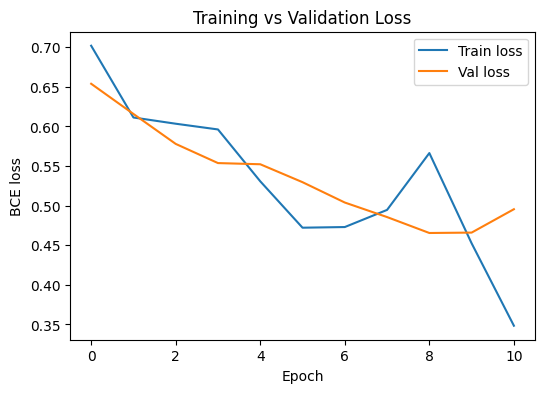

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_loss_history, label="Train loss")
plt.plot(val_loss_history, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.load_state_dict(best_state)
model.eval()

test_logits = []
test_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        test_logits.append(logits.cpu())
        test_targets.append(yb)

test_logits = torch.cat(test_logits).numpy()
test_targets = torch.cat(test_targets).numpy()
test_probs = 1 / (1 + np.exp(-test_logits))
test_preds = (test_probs >= 0.5).astype(int)

print("\nTest AUROC:", roc_auc_score(test_targets, test_probs))
print("Test AUPR :", average_precision_score(test_targets, test_probs))
print("\nClassification Report:")
print(classification_report(test_targets, test_preds))



Test AUROC: 0.8912067919951485
Test AUPR : 0.8598091073657287

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.67      0.76        97
         1.0       0.71      0.91      0.79        85

    accuracy                           0.78       182
   macro avg       0.80      0.79      0.78       182
weighted avg       0.80      0.78      0.78       182



# Neural net Post-Lasso

In [ ]:
# Median imputation
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_postlasso)
X_val_imp   = imputer.transform(X_val_postlasso)
X_test_imp  = imputer.transform(X_test_postlasso)

y_train_bin = y_train["binary"]
y_val_bin   = y_val["binary"]
y_test_bin  = y_test["binary"]


In [ ]:
batch_size = 256

train_ds = TabularDataset(X_train_imp, y_train_bin)
val_ds   = TabularDataset(X_val_imp, y_val_bin)
test_ds  = TabularDataset(X_test_imp, y_test_bin)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=X_train_imp.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=7e-4,
    weight_decay=3e-4
)

best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
n_epochs = 100

train_loss_history = []
val_loss_history = []
val_auc_history = []
val_aupr_history = []

for epoch in range(n_epochs):
    # =====================
    # Training
    # =====================
    model.train()
    train_losses = []

    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # =====================
    # Validation
    # =====================
    model.eval()
    val_logits = []
    val_targets = []
    val_losses = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            logits = model(Xb)
            loss = criterion(logits, yb)

            val_logits.append(logits.cpu())
            val_targets.append(yb.cpu())
            val_losses.append(loss.item())

    val_logits = torch.cat(val_logits).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_probs = 1.0 / (1.0 + np.exp(-val_logits))

    val_loss = np.mean(val_losses)
    val_auc = roc_auc_score(val_targets, val_probs)
    val_aupr = average_precision_score(val_targets, val_probs)

    # =====================
    # Logging
    # =====================
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    val_auc_history.append(val_auc)
    val_aupr_history.append(val_aupr)

    print(
        f"Epoch {epoch:03d} | "
        f"Train loss={avg_train_loss:.4f} | "
        f"Val loss={val_loss:.4f} | "
        f"Val AUROC={val_auc:.4f} | "
        f"Val AUPR={val_aupr:.4f}"
    )

    # =====================
    # Early stopping (on AUROC)
    # =====================
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
print("Best val AUROC:", best_val_auc, "at epoch", best_epoch)

Epoch 000 | Train loss=0.6887 | Val loss=0.6756 | Val AUROC=0.8026 | Val AUPR=0.8249
Epoch 001 | Train loss=0.6718 | Val loss=0.6584 | Val AUROC=0.8294 | Val AUPR=0.8520
Epoch 002 | Train loss=0.6349 | Val loss=0.6366 | Val AUROC=0.8422 | Val AUPR=0.8569
Epoch 003 | Train loss=0.6048 | Val loss=0.6056 | Val AUROC=0.8646 | Val AUPR=0.8733
Epoch 004 | Train loss=0.5524 | Val loss=0.5748 | Val AUROC=0.8731 | Val AUPR=0.8808
Epoch 005 | Train loss=0.4929 | Val loss=0.5447 | Val AUROC=0.8807 | Val AUPR=0.8828
Epoch 006 | Train loss=0.4609 | Val loss=0.5253 | Val AUROC=0.8787 | Val AUPR=0.8774
Epoch 007 | Train loss=0.4273 | Val loss=0.5067 | Val AUROC=0.8818 | Val AUPR=0.8741
Epoch 008 | Train loss=0.3939 | Val loss=0.4744 | Val AUROC=0.8835 | Val AUPR=0.8704
Epoch 009 | Train loss=0.3415 | Val loss=0.4573 | Val AUROC=0.8847 | Val AUPR=0.8731
Epoch 010 | Train loss=0.3582 | Val loss=0.4439 | Val AUROC=0.8870 | Val AUPR=0.8794
Epoch 011 | Train loss=0.2851 | Val loss=0.4402 | Val AUROC=0.889

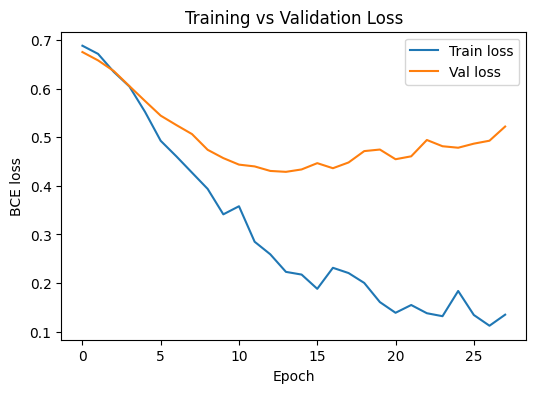

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_loss_history, label="Train loss")
plt.plot(val_loss_history, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.load_state_dict(best_state)
model.eval()

test_logits = []
test_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        test_logits.append(logits.cpu())
        test_targets.append(yb)

test_logits = torch.cat(test_logits).numpy()
test_targets = torch.cat(test_targets).numpy()
test_probs = 1 / (1 + np.exp(-test_logits))
test_preds = (test_probs >= 0.5).astype(int)

print("\nTest AUROC:", roc_auc_score(test_targets, test_probs))
print("Test AUPR :", average_precision_score(test_targets, test_probs))
print("\nClassification Report:")
print(classification_report(test_targets, test_preds))



Test AUROC: 0.8929047907822922
Test AUPR : 0.8657353632456132

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81        97
         1.0       0.76      0.86      0.81        85

    accuracy                           0.81       182
   macro avg       0.81      0.81      0.81       182
weighted avg       0.81      0.81      0.81       182



# Feature Selection Multi-Class

In [ ]:
y_cancer_data = y_data[y_data['binary'] == 1]

In [ ]:
y_cancer_data = y_cancer_data[y_cancer_data['sample'].isin(['Colorectal cancer','Lung cancer','Liver cancer'])]

In [ ]:
label_map = {"Colorectal cancer":0, "Lung cancer":1, "Liver cancer":2}
y_cancer_encoded = y_cancer_data['sample'].map(label_map)

In [ ]:
y_cancer_encoded[y_cancer_encoded==2]

,sample
GSM2446531,2
GSM2446701,2
GSM2446709,2
GSM2446718,2
GSM2446719,2
...,...
GSM4502155,2
GSM4502156,2
GSM4502164,2
GSM4502174,2


In [ ]:
x_data_cancer = data_df[data_df.index.isin(y_cancer_encoded.index)]

In [ ]:
from sklearn.model_selection import train_test_split

X_train_canc, X_temp_canc, y_train_canc, y_temp_canc = train_test_split(x_data_cancer, y_cancer_encoded, test_size=0.4, random_state=42)
X_val_canc, X_test_canc, y_val_canc, y_test_canc = train_test_split(X_temp_canc, y_temp_canc, test_size=0.5, random_state=42)

In [ ]:
print(X_train_canc.shape)
print(X_val_canc.shape)
print(X_test_canc.shape)
print(y_train_canc.shape)
print(y_val_canc.shape)
print(y_test_canc.shape)

(502, 75788)
(167, 75788)
(168, 75788)
(502,)
(167,)
(168,)


In [ ]:
X_train_canc.to_csv(DATA / 'X_train_canc.csv', index=False)
X_val_canc.to_csv(DATA / 'X_val_canc.csv', index=False)
X_test_canc.to_csv(DATA / 'X_test_canc.csv', index=False)
y_train_canc.to_csv(DATA / 'y_train_canc.csv', index=False)
y_val_canc.to_csv(DATA / 'y_val_canc.csv', index=False)
y_test_canc.to_csv(DATA / 'y_test_canc.csv', index=False)

In [ ]:
valid_cols = []

for col in X_train_canc.columns:
    ok = True
    for c in [0,1,2]:
        if X_train_canc.loc[y_train_canc == c, col].notna().mean() < 0.10:
            ok = False
    if ok:
        valid_cols.append(col)

X_train_canc_filtered = X_train_canc[valid_cols]

In [ ]:
print(X_train_canc_filtered.shape)

(502, 7711)


In [ ]:
from scipy.stats import kruskal
import numpy as np

pvals = []

for col in X_train_canc_filtered.columns:

    # Extract per-class groups
    groups = [X_train_canc_filtered.loc[y_train_canc == c, col].dropna()
              for c in [0, 1, 2]]

    # Skip if any group has fewer than 3 samples
    if any(len(g) < 3 for g in groups):
        pvals.append(np.nan)
        continue

    # Skip if no variance across entire column
    all_vals = pd.concat(groups)
    if all_vals.nunique() <= 1:
        pvals.append(np.nan)
        continue

    # Skip if every group has identical value (zero variance within groups)
    if all(g.nunique() <= 1 for g in groups):
        pvals.append(np.nan)
        continue

    # Safe to run Kruskal–Wallis
    stat, p = kruskal(*groups)
    pvals.append(p)

pvals = np.array(pvals)


In [ ]:
pvals

array([2.73689750e-09, 7.62563561e-38, 5.92721833e-07, ...,
       7.69141642e-10, 9.77990037e-09, 3.01269858e-11])

In [ ]:
from statsmodels.stats.multitest import multipletests

pvals_fdr = multipletests(pvals, method='fdr_bh')[1]
sig_features = X_train_canc_filtered.columns[pvals_fdr < 0.001]


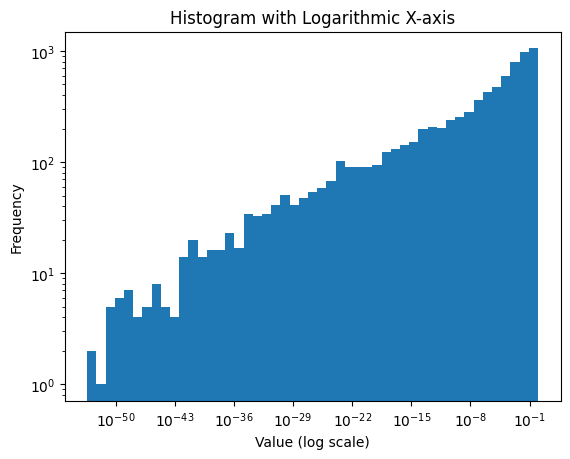

In [ ]:
# Define logarithmic bins
min_val = np.min(pvals_fdr[pvals_fdr > 0]) # Ensure positive values for log scale
max_val = np.max(pvals_fdr)
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

plt.hist(pvals_fdr, bins=log_bins, log = True)
plt.xscale('log')
plt.title("Histogram with Logarithmic X-axis")
plt.xlabel("Value (log scale)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
sig_features

Index(['chr1:600000', 'chr1:1000000', 'chr1:1120000', 'chr1:1280000',
       'chr1:1360000', 'chr1:1960000', 'chr1:2000000', 'chr1:2040000',
       'chr1:2120000', 'chr1:2200000',
       ...
       'chrX:137640000', 'chrX:141200000', 'chrX:146080000', 'chrX:149440000',
       'chrX:150520000', 'chrX:151680000', 'chrX:153360000', 'chrX:153400000',
       'chrX:153840000', 'chrX:154160000'],
      dtype='object', length=5065)

In [ ]:
delta = 0.5  # tune this

effect_mask = []
for col in sig_features:
    medians = X_train_canc_filtered.groupby(y_train_canc)[col].median()
    max_diff = medians.max() - medians.min()
    effect_mask.append(max_diff > delta)

effect_mask = np.array(effect_mask)


In [ ]:
effect_mask.sum()

np.int64(3610)

In [ ]:
sig_features_cancer = sig_features[effect_mask]

In [ ]:
sig_features_path = DATA / 'sig_features_cancer.csv'
pd.Series(sig_features_cancer, name='feature').to_csv(sig_features_path, index=False)

# Multi-Class Lasso

In [ ]:
X_train_postft_canc = X_train_canc[sig_features_cancer]
X_val_postft_canc = X_val_canc[sig_features_cancer]
X_test_postft_canc = X_test_canc[sig_features_cancer]
print(X_train_postft_canc.shape)
print(X_val_postft_canc.shape)
print(X_test_postft_canc.shape)

(502, 3610)
(167, 3610)
(168, 3610)


In [ ]:
X_train_postft_canc.to_csv(DATA / 'X_train_postft_canc.csv', index=False)
X_val_postft_canc.to_csv(DATA / 'X_val_postft_canc.csv', index=False)
X_test_postft_canc.to_csv(DATA / 'X_test_postft_canc.csv', index=False)

In [ ]:
y_train_enc = y_train_canc.astype("category").cat.codes
y_val_enc   = y_val_canc.astype("category").cat.codes
y_test_enc  = y_test_canc.astype("category").cat.codes

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

# Multiclass L1 Logistic Regression (one-vs-rest)
lasso_mc = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(
        penalty='l1',
        solver='saga',
        C=1.0,
        max_iter=10000,
        n_jobs=-1,
        multi_class='ovr'     # <-- required for multi-class L1
    )
)

lasso_mc.fit(X_train_postft_canc, y_train_enc)

# Predict probabilities
val_probs = lasso_mc.predict_proba(X_val_postft_canc)

# Compute one-vs-rest AUROC per class
aucs = {}
for k in np.unique(y_val_enc):
    y_true_binary = (y_val_enc == k).astype(int)
    aucs[k] = roc_auc_score(y_true_binary, val_probs[:, k])

print("Per-class AUROCs:", aucs)

# (Optional) Overall weighted AUROC
overall_auroc = roc_auc_score(y_val_enc, val_probs, multi_class="ovr")
print("Overall multiclass AUROC:", overall_auroc)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Per-class AUROCs: {np.int8(0): np.float64(0.9545322063538327), np.int8(1): np.float64(0.9859929078014185), np.int8(2): np.float64(0.9492635024549918)}
Overall multiclass AUROC: 0.9632628722034143


              precision    recall  f1-score   support

         CRC       0.88      0.94      0.91        94
        lung       0.89      0.85      0.87        47
       liver       0.82      0.69      0.75        26

    accuracy                           0.87       167
   macro avg       0.86      0.83      0.84       167
weighted avg       0.87      0.87      0.87       167

Confusion Matrix (raw counts):
[[88  4  2]
 [ 5 40  2]
 [ 7  1 18]]


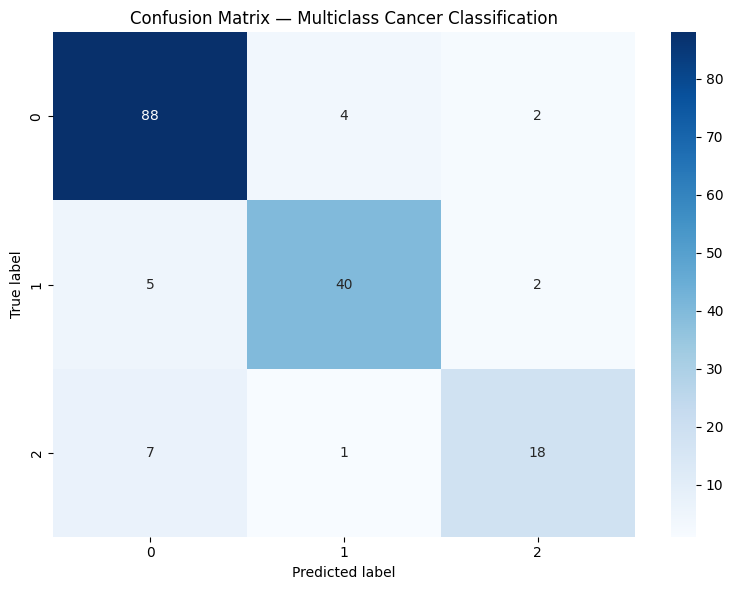

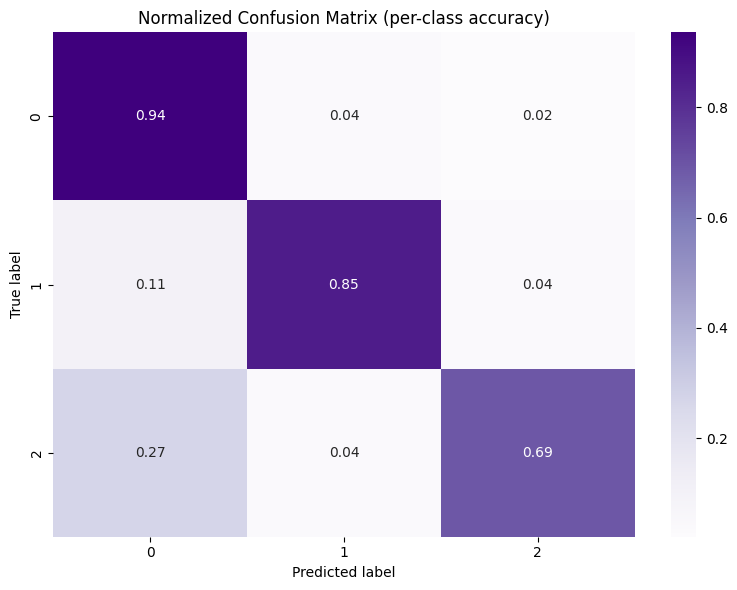

In [ ]:
y_val_pred = lasso_mc.predict(X_val_postft_canc)
class_names = ["CRC", "lung", 'liver']

print(classification_report(
    y_val_enc,
    y_val_pred,
    target_names=class_names
))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recover the class names (strings)
class_names = list(y_train_canc.astype("category").cat.categories)

# Compute confusion matrix
cm = confusion_matrix(y_val_enc, y_val_pred)

# Print raw numeric matrix
print("Confusion Matrix (raw counts):")
print(cm)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Multiclass Cancer Classification")
plt.tight_layout()
plt.show()


cm_norm = confusion_matrix(y_val_enc, y_val_pred, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (per-class accuracy)")
plt.tight_layout()
plt.show()


Per-class AUROCs: {np.int8(0): np.float64(0.9801559177888022), np.int8(1): np.float64(0.9959247648902821), np.int8(2): np.float64(0.9843356643356643)}
Overall multiclass AUROC: 0.9868054490049163
              precision    recall  f1-score   support

         CRC       0.91      0.96      0.94        85
        lung       1.00      0.93      0.96        58
       liver       0.88      0.84      0.86        25

    accuracy                           0.93       168
   macro avg       0.93      0.91      0.92       168
weighted avg       0.94      0.93      0.93       168

Confusion Matrix (raw counts):
[[82  0  3]
 [ 4 54  0]
 [ 4  0 21]]


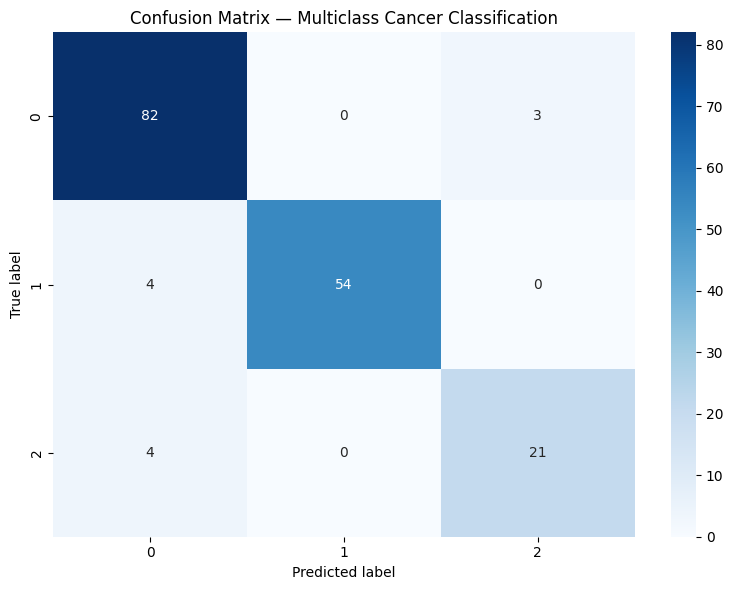

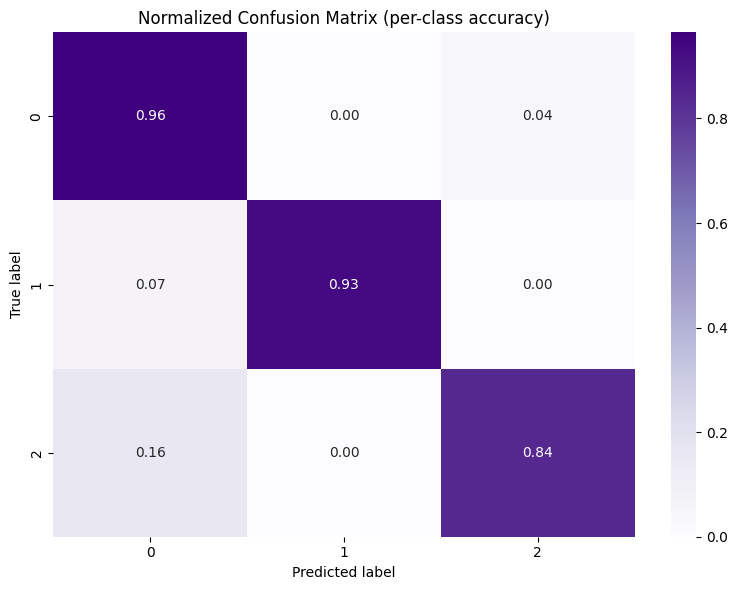

In [ ]:
# Predict probabilities
test_probs = lasso_mc.predict_proba(X_test_postft_canc)

# Compute one-vs-rest AUROC per class
aucs = {}
for k in np.unique(y_test_enc):
    y_true_binary = (y_test_enc == k).astype(int)
    aucs[k] = roc_auc_score(y_true_binary, test_probs[:, k])

print("Per-class AUROCs:", aucs)

# (Optional) Overall weighted AUROC
overall_auroc = roc_auc_score(y_test_enc, test_probs, multi_class="ovr")
print("Overall multiclass AUROC:", overall_auroc)


y_test_pred = lasso_mc.predict(X_test_postft_canc)
class_names = ["CRC", "lung", 'liver']

print(classification_report(
    y_test_enc,
    y_test_pred,
    target_names=class_names
))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recover the class names (strings)
class_names = list(y_train_canc.astype("category").cat.categories)

# Compute confusion matrix
cm = confusion_matrix(y_test_enc, y_test_pred)

# Print raw numeric matrix
print("Confusion Matrix (raw counts):")
print(cm)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Multiclass Cancer Classification")
plt.tight_layout()
plt.show()

cm_norm = confusion_matrix(y_test_enc, y_test_pred, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (per-class accuracy)")
plt.tight_layout()
plt.show()


In [ ]:
# === 1. Extract multiclass Lasso coefficients ===
lasso_model = lasso_mc.named_steps["logisticregression"]

coef_matrix = lasso_model.coef_  # shape (n_classes, n_features)

feature_importance = pd.Series(
    np.mean(np.abs(coef_matrix), axis=0),
    index=X_train_postft_canc.columns
).sort_values(ascending=False)

print("Top features:\n", feature_importance.head(10))

# === 2. Select top 10 ===
top_features = feature_importance.head(10).index
window_size = 40000

# === 3. Map each window → genes ===
for feature in top_features:
    try:
        chrom, start_str = feature.split(":")
        start = int(start_str)
    except:
        print(f"Skipping malformed feature name: {feature}")
        continue

    end = start + window_size

    # Look up overlapping genes
    overlaps = gene_df[
        (gene_df["chrom"].str.lower() == chrom.lower()) &
        (gene_df["start"] <= end) &
        (gene_df["end"] >= start)
    ]

    print(f"\nFeature: {feature} ({chrom}:{start}-{end})")

    if overlaps.empty:
        print("   No overlapping genes")
    else:
        print("   Overlapping genes:")
        for g in overlaps["gene_name"]:
            print("     ", g)

Top features:
 chr9:137520000    0.338158
chr17:1080000     0.249538
chr12:9160000     0.221977
chr20:49680000    0.194755
chr13:33640000    0.185150
chr6:32520000     0.182647
chr20:37200000    0.178135
chr6:55920000     0.177014
chr14:76000000    0.171925
chr7:141200000    0.167821
dtype: float64

Feature: chr9:137520000 (chr9:137520000-137560000)
   Overlapping genes:
      PNPLA7
      MRPL41
      DPH7

Feature: chr17:1080000 (chr17:1080000-1120000)
   Overlapping genes:
      ABR
      Metazoa_SRP

Feature: chr12:9160000 (chr12:9160000-9200000)
   Overlapping genes:
      PZP

Feature: chr20:49680000 (chr20:49680000-49720000)
   Overlapping genes:
      B4GALT5

Feature: chr13:33640000 (chr13:33640000-33680000)
   Overlapping genes:
      ENSG00000230490
      ENSG00000232986
      ENSG00000288767

Feature: chr6:32520000 (chr6:32520000-32560000)
   Overlapping genes:
      HLA-DRB5
      RNU1-61P
      HLA-DRB6

Feature: chr20:37200000 (chr20:37200000-37240000)
   Overlapping gen

# Multi-Class Data Load

In [ ]:
X_train_postlasso_canc = pd.read_csv(DATA / 'X_train_postlasso_canc.csv')
X_val_postlasso_canc = pd.read_csv(DATA / 'X_val_postlasso_canc.csv')
X_test_postlasso_canc = pd.read_csv(DATA / 'X_test_postlasso_canc.csv')
X_train_postft_canc = pd.read_csv(DATA / 'X_train_postft_canc.csv')
X_val_postft_canc = pd.read_csv(DATA / 'X_val_postft_canc.csv')
X_test_postft_canc = pd.read_csv(DATA / 'X_test_postft_canc.csv')
y_train_canc = pd.read_csv(DATA / 'y_train_canc.csv')
y_val_canc = pd.read_csv(DATA / 'y_val_canc.csv')
y_test_canc = pd.read_csv(DATA / 'y_test_canc.csv')

In [ ]:
gene_df_path = DATA / "gene_df.csv"

gene_df = pd.read_csv(gene_df_path)

In [ ]:
print(X_train_postlasso_canc.shape)
print(X_val_postlasso_canc.shape)
print(X_test_postlasso_canc.shape)

(502, 529)
(167, 529)
(168, 529)


# Multi-Class Random Forest Pre-Lasso

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import numpy as np

# ===========================
# Parameter grids
# ===========================
max_depth_grid = [5, 15, 45, None]
n_estimators_grid = [100, 500, 2500]

results = []

# Ensure labels are 1D integer arrays
y_train_mc = y_train_canc.astype(int)
y_val_mc   = y_val_canc.astype(int)

num_classes = y_train_mc.nunique()
print("Detected number of classes:", num_classes)

# ===========================
# Grid search
# ===========================
for max_depth in max_depth_grid:
    for n_estimators in n_estimators_grid:

        rf_pipeline = make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(with_mean=True, with_std=True),
            RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=42
            )
        )

        # Fit on cancer-only training set
        rf_pipeline.fit(X_train_postft_canc, y_train_mc)

        # Predict probabilities on validation
        y_val_proba = rf_pipeline.predict_proba(X_val_postft_canc)
        y_val_proba = np.asarray(y_val_proba)

        # Multiclass AUROC (OVO with fallback)
        try:
            val_auroc = roc_auc_score(
                y_val_mc,
                y_val_proba,
                multi_class="ovo",
                average="macro"
            )
        except Exception:
            val_auroc = roc_auc_score(
                y_val_mc,
                y_val_proba,
                multi_class="ovr",
                average="macro"
            )

        results.append({
            "max_depth": max_depth,
            "n_estimators": n_estimators,
            "val_auroc": val_auroc,
            "pipeline": rf_pipeline
        })

        print(
            f"Done: max_depth={max_depth}, "
            f"n_estimators={n_estimators}, "
            f"Val AUROC={val_auroc:.3f}"
        )

# ===========================
# Select best model
# ===========================
results_df = pd.DataFrame(results)
best_idx = results_df["val_auroc"].idxmax()
best_model = results_df.loc[best_idx, "pipeline"]

print("\nBest parameters:")
print(results_df.loc[best_idx, ["max_depth", "n_estimators", "val_auroc"]])

# ===========================
# Validation classification report
# ===========================
y_val_pred = best_model.predict(X_val_postft_canc)

print("\nClassification report (validation):")
print(classification_report(y_val_mc, y_val_pred))

# ===========================
# Feature importances
# ===========================
rf_model = best_model.named_steps["randomforestclassifier"]

feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train_postft_canc.columns
).sort_values(ascending=False)

print("\nTop 10 features by importance:")
print(feature_importances.head(10))


Detected number of classes: 3
Done: max_depth=5, n_estimators=100, Val AUROC=0.955
Done: max_depth=5, n_estimators=500, Val AUROC=0.960
Done: max_depth=5, n_estimators=2500, Val AUROC=0.960
Done: max_depth=15, n_estimators=100, Val AUROC=0.967
Done: max_depth=15, n_estimators=500, Val AUROC=0.970
Done: max_depth=15, n_estimators=2500, Val AUROC=0.971
Done: max_depth=45, n_estimators=100, Val AUROC=0.967
Done: max_depth=45, n_estimators=500, Val AUROC=0.970
Done: max_depth=45, n_estimators=2500, Val AUROC=0.971
Done: max_depth=None, n_estimators=100, Val AUROC=0.967
Done: max_depth=None, n_estimators=500, Val AUROC=0.970
Done: max_depth=None, n_estimators=2500, Val AUROC=0.971

Best parameters:
max_depth           15.0
n_estimators        2500
val_auroc       0.971427
Name: 5, dtype: object

Classification report (validation):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        94
           1       0.95      0.81      0.87        47

# Multi-Class Random Forest Post-Lasso

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import numpy as np

# ===========================
# Parameter grids
# ===========================
max_depth_grid = [5, 15, 45, None]
n_estimators_grid = [100, 500, 2500]

results = []

# Ensure labels are 1D integer arrays
y_train_mc = y_train_canc.astype(int)
y_val_mc   = y_val_canc.astype(int)

num_classes = y_train_mc.nunique()
print("Detected number of classes:", num_classes)

# ===========================
# Grid search
# ===========================
for max_depth in max_depth_grid:
    for n_estimators in n_estimators_grid:

        rf_pipeline = make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(with_mean=True, with_std=True),
            RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=42
            )
        )

        # Fit on cancer-only training set
        rf_pipeline.fit(X_train_postlasso_canc, y_train_mc)

        # Predict probabilities on validation
        y_val_proba = rf_pipeline.predict_proba(X_val_postlasso_canc)
        y_val_proba = np.asarray(y_val_proba)

        # Multiclass AUROC (OVO with fallback)
        try:
            val_auroc = roc_auc_score(
                y_val_mc,
                y_val_proba,
                multi_class="ovo",
                average="macro"
            )
        except Exception:
            val_auroc = roc_auc_score(
                y_val_mc,
                y_val_proba,
                multi_class="ovr",
                average="macro"
            )

        results.append({
            "max_depth": max_depth,
            "n_estimators": n_estimators,
            "val_auroc": val_auroc,
            "pipeline": rf_pipeline
        })

        print(
            f"Done: max_depth={max_depth}, "
            f"n_estimators={n_estimators}, "
            f"Val AUROC={val_auroc:.3f}"
        )

# ===========================
# Select best model
# ===========================
results_df = pd.DataFrame(results)
best_idx = results_df["val_auroc"].idxmax()
best_model = results_df.loc[best_idx, "pipeline"]

print("\nBest parameters:")
print(results_df.loc[best_idx, ["max_depth", "n_estimators", "val_auroc"]])

# ===========================
# Validation classification report
# ===========================
y_val_pred = best_model.predict(X_val_postlasso_canc)

print("\nClassification report (validation):")
print(classification_report(y_val_mc, y_val_pred))

# ===========================
# Feature importances
# ===========================
rf_model = best_model.named_steps["randomforestclassifier"]

feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train_postlasso_canc.columns
).sort_values(ascending=False)

print("\nTop 10 features by importance:")
print(feature_importances.head(10))


Detected number of classes: 3
Done: max_depth=5, n_estimators=100, Val AUROC=0.956
Done: max_depth=5, n_estimators=500, Val AUROC=0.956
Done: max_depth=5, n_estimators=2500, Val AUROC=0.959
Done: max_depth=15, n_estimators=100, Val AUROC=0.968
Done: max_depth=15, n_estimators=500, Val AUROC=0.970
Done: max_depth=15, n_estimators=2500, Val AUROC=0.971
Done: max_depth=45, n_estimators=100, Val AUROC=0.968
Done: max_depth=45, n_estimators=500, Val AUROC=0.970
Done: max_depth=45, n_estimators=2500, Val AUROC=0.971
Done: max_depth=None, n_estimators=100, Val AUROC=0.968
Done: max_depth=None, n_estimators=500, Val AUROC=0.970
Done: max_depth=None, n_estimators=2500, Val AUROC=0.971

Best parameters:
max_depth           15.0
n_estimators        2500
val_auroc       0.971351
Name: 5, dtype: object

Classification report (validation):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        94
           1       0.91      0.83      0.87        47

# Multi-Class GBT Pre-Lasso XGBosst

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import itertools

# ===========================
# 1. Clean up labels
# ===========================
# y_train_canc, y_val_canc, y_test_canc might be DataFrames; force to 1D Series
def to_1d(y):
    if isinstance(y, pd.DataFrame):
        return y.iloc[:, 0]   # take first column
    return y

y_train_canc_1d = to_1d(y_train_canc)
y_val_canc_1d   = to_1d(y_val_canc)
y_test_canc_1d  = to_1d(y_test_canc)

num_classes = int(pd.Series(y_train_canc_1d).nunique())
print("Detected number of classes:", num_classes)

# ===========================
# 2. Hyperparameter grid
# ===========================
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

results = []
print(f"\nRunning {len(grid)} hyperparameter combinations...\n")

# ===========================
# 3. Grid search loop
# ===========================
for n_est, lr, depth, subs, colsample in grid:

    xgb_pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        XGBClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            subsample=subs,
            colsample_bytree=colsample,
            objective="multi:softprob",
            num_class=num_classes,
            eval_metric="mlogloss",
            tree_method="hist",
            n_jobs=-1,
            random_state=42
        )
    )

    # Fit on train
    xgb_pipe.fit(X_train_postft_canc, y_train_canc_1d)

    # Predict prob matrix on val
    y_val_proba = xgb_pipe.predict_proba(X_val_postft_canc)
    y_val_proba = np.asarray(y_val_proba)   # ensure NumPy, no pandas ambiguity

    # Compute multiclass AUROC (try OVO, fall back to OVR if needed)
    try:
        val_auroc = roc_auc_score(
            y_val_canc_1d,
            y_val_proba,
            multi_class="ovo",
            average="macro"
        )
    except Exception as e:
        print(f"OVO AUROC failed ({e}), falling back to OVR...")
        val_auroc = roc_auc_score(
            y_val_canc_1d,
            y_val_proba,
            multi_class="ovr",
            average="macro"
        )

    results.append({
        "n_estimators": n_est,
        "learning_rate": lr,
        "max_depth": depth,
        "subsample": subs,
        "colsample_bytree": colsample,
        "val_auroc": val_auroc
    })

    print(
        f"n={n_est}, lr={lr}, depth={depth}, subs={subs}, colsample={colsample} "
        f"→ AUROC={val_auroc:.4f}"
    )

# ===========================
# 4. Pick best hyperparameters
# ===========================
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest multiclass XGBoost hyperparameters:")
print(best_row)

# ===========================
# 5. Refit best model
# ===========================
best_model = make_pipeline(
    SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=int(best_row["n_estimators"]),
        learning_rate=float(best_row["learning_rate"]),
        max_depth=int(best_row["max_depth"]),
        subsample=float(best_row["subsample"]),
        colsample_bytree=float(best_row["colsample_bytree"]),
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
)

best_model.fit(X_train_postft_canc, y_train_canc_1d)

# ===========================
# 6. Validation performance
# ===========================
y_val_pred = best_model.predict(X_val_postft_canc)

print("\nValidation Classification Report:")
print(classification_report(y_val_canc_1d, y_val_pred))

val_cm = confusion_matrix(y_val_canc_1d, y_val_pred, normalize="true")
print("\nNormalized Validation Confusion Matrix:\n", val_cm)

# ===========================
# 7. Test performance
# ===========================
y_test_proba = best_model.predict_proba(X_test_postft_canc)
y_test_proba = np.asarray(y_test_proba)
y_test_pred = best_model.predict(X_test_postft_canc)

# AUROC (again OVO with OVR fallback)
try:
    test_auroc = roc_auc_score(
        y_test_canc_1d,
        y_test_proba,
        multi_class="ovo",
        average="macro"
    )
except Exception as e:
    print(f"OVO AUROC on test failed ({e}), falling back to OVR...")
    test_auroc = roc_auc_score(
        y_test_canc_1d,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auroc, 3))
print("\nTest Classification Report:")
print(classification_report(y_test_canc_1d, y_test_pred))

test_cm = confusion_matrix(y_test_canc_1d, y_test_pred, normalize="true")
print("\nNormalized Test Confusion Matrix:\n", test_cm)

# ===========================
# 8. Feature importance
# ===========================
xgb_model = best_model.named_steps["xgbclassifier"]
feature_importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_postft_canc.columns
).sort_values(ascending=False)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))


Detected number of classes: 3

Running 48 hyperparameter combinations...

n=300, lr=0.05, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9669
n=300, lr=0.05, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9675
n=300, lr=0.05, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9659
n=300, lr=0.05, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9681
n=300, lr=0.05, depth=5, subs=0.8, colsample=0.8 → AUROC=0.9657
n=300, lr=0.05, depth=5, subs=0.8, colsample=1.0 → AUROC=0.9675
n=300, lr=0.05, depth=5, subs=1.0, colsample=0.8 → AUROC=0.9663
n=300, lr=0.05, depth=5, subs=1.0, colsample=1.0 → AUROC=0.9658
n=300, lr=0.1, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9678
n=300, lr=0.1, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9679
n=300, lr=0.1, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9684
n=300, lr=0.1, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9685
n=300, lr=0.1, depth=5, subs=0.8, colsample=0.8 → AUROC=0.9693
n=300, lr=0.1, depth=5, subs=0.8, colsample=1.0 → AUROC=0.9699
n=300, lr=0.1, depth=5, subs=1.0, co

# Multi-Class GBT Post-Lasso XGBosst

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import itertools

# ===========================
# 1. Clean up labels
# ===========================
# y_train_canc, y_val_canc, y_test_canc might be DataFrames; force to 1D Series
def to_1d(y):
    if isinstance(y, pd.DataFrame):
        return y.iloc[:, 0]   # take first column
    return y

y_train_canc_1d = to_1d(y_train_canc)
y_val_canc_1d   = to_1d(y_val_canc)
y_test_canc_1d  = to_1d(y_test_canc)

num_classes = int(pd.Series(y_train_canc_1d).nunique())
print("Detected number of classes:", num_classes)

# ===========================
# 2. Hyperparameter grid
# ===========================
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

results = []
print(f"\nRunning {len(grid)} hyperparameter combinations...\n")

# ===========================
# 3. Grid search loop
# ===========================
for n_est, lr, depth, subs, colsample in grid:

    xgb_pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        XGBClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=depth,
            subsample=subs,
            colsample_bytree=colsample,
            objective="multi:softprob",
            num_class=num_classes,
            eval_metric="mlogloss",
            tree_method="hist",
            n_jobs=-1,
            random_state=42
        )
    )

    # Fit on train
    xgb_pipe.fit(X_train_postlasso_canc, y_train_canc_1d)

    # Predict prob matrix on val
    y_val_proba = xgb_pipe.predict_proba(X_val_postlasso_canc)
    y_val_proba = np.asarray(y_val_proba)   # ensure NumPy, no pandas ambiguity

    # Compute multiclass AUROC (try OVO, fall back to OVR if needed)
    try:
        val_auroc = roc_auc_score(
            y_val_canc_1d,
            y_val_proba,
            multi_class="ovo",
            average="macro"
        )
    except Exception as e:
        print(f"OVO AUROC failed ({e}), falling back to OVR...")
        val_auroc = roc_auc_score(
            y_val_canc_1d,
            y_val_proba,
            multi_class="ovr",
            average="macro"
        )

    results.append({
        "n_estimators": n_est,
        "learning_rate": lr,
        "max_depth": depth,
        "subsample": subs,
        "colsample_bytree": colsample,
        "val_auroc": val_auroc
    })

    print(
        f"n={n_est}, lr={lr}, depth={depth}, subs={subs}, colsample={colsample} "
        f"→ AUROC={val_auroc:.4f}"
    )

# ===========================
# 4. Pick best hyperparameters
# ===========================
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest multiclass XGBoost hyperparameters:")
print(best_row)

# ===========================
# 5. Refit best model
# ===========================
best_model = make_pipeline(
    SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=int(best_row["n_estimators"]),
        learning_rate=float(best_row["learning_rate"]),
        max_depth=int(best_row["max_depth"]),
        subsample=float(best_row["subsample"]),
        colsample_bytree=float(best_row["colsample_bytree"]),
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
)

best_model.fit(X_train_postlasso_canc, y_train_canc_1d)

# ===========================
# 6. Validation performance
# ===========================
y_val_pred = best_model.predict(X_val_postlasso_canc)

print("\nValidation Classification Report:")
print(classification_report(y_val_canc_1d, y_val_pred))

val_cm = confusion_matrix(y_val_canc_1d, y_val_pred, normalize="true")
print("\nNormalized Validation Confusion Matrix:\n", val_cm)

# ===========================
# 7. Test performance
# ===========================
y_test_proba = best_model.predict_proba(X_test_postlasso_canc)
y_test_proba = np.asarray(y_test_proba)
y_test_pred = best_model.predict(X_test_postlasso_canc)

# AUROC (again OVO with OVR fallback)ft
try:
    test_auroc = roc_auc_score(
        y_test_canc_1d,
        y_test_proba,
        multi_class="ovo",
        average="macro"
    )
except Exception as e:
    print(f"OVO AUROC on test failed ({e}), falling back to OVR...")
    test_auroc = roc_auc_score(
        y_test_canc_1d,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auroc, 3))
print("\nTest Classification Report:")
print(classification_report(y_test_canc_1d, y_test_pred))

test_cm = confusion_matrix(y_test_canc_1d, y_test_pred, normalize="true")
print("\nNormalized Test Confusion Matrix:\n", test_cm)

# ===========================
# 8. Feature importance
# ===========================
xgb_model = best_model.named_steps["xgbclassifier"]
feature_importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_postlasso_canc.columns
).sort_values(ascending=False)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))


Detected number of classes: 3

Running 48 hyperparameter combinations...

n=300, lr=0.05, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9646
n=300, lr=0.05, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9667
n=300, lr=0.05, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9638
n=300, lr=0.05, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9650
n=300, lr=0.05, depth=5, subs=0.8, colsample=0.8 → AUROC=0.9649
n=300, lr=0.05, depth=5, subs=0.8, colsample=1.0 → AUROC=0.9659
n=300, lr=0.05, depth=5, subs=1.0, colsample=0.8 → AUROC=0.9603
n=300, lr=0.05, depth=5, subs=1.0, colsample=1.0 → AUROC=0.9593
n=300, lr=0.1, depth=3, subs=0.8, colsample=0.8 → AUROC=0.9662
n=300, lr=0.1, depth=3, subs=0.8, colsample=1.0 → AUROC=0.9640
n=300, lr=0.1, depth=3, subs=1.0, colsample=0.8 → AUROC=0.9634
n=300, lr=0.1, depth=3, subs=1.0, colsample=1.0 → AUROC=0.9634
n=300, lr=0.1, depth=5, subs=0.8, colsample=0.8 → AUROC=0.9655
n=300, lr=0.1, depth=5, subs=0.8, colsample=1.0 → AUROC=0.9666
n=300, lr=0.1, depth=5, subs=1.0, co

# **Multi-Class Focal Loss Pre-Lasso XGBosst**

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import itertools
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ===========================
# 1. Multiclass focal loss
# ===========================
def multiclass_focal_loss(alpha=1.0, gamma=2.0):
    def loss(preds, dtrain):
        y = dtrain.get_label().astype(int)
        n_samples = y.shape[0]
        n_classes = int(np.max(y)) + 1

        preds = preds.reshape(n_samples, n_classes)

        # Stable softmax
        preds_max = np.max(preds, axis=1, keepdims=True)
        exp_preds = np.exp(preds - preds_max)
        probs = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)

        y_onehot = np.zeros_like(probs)
        y_onehot[np.arange(n_samples), y] = 1.0

        pt = np.sum(probs * y_onehot, axis=1, keepdims=True)
        pt = np.clip(pt, 1e-9, 1.0)

        grad = alpha * (probs - y_onehot) * ((1 - pt) ** gamma)
        hess = alpha * probs * (1 - probs) * ((1 - pt) ** gamma)

        return grad.reshape(-1), hess.reshape(-1)

    return loss


# ===========================
# 2. Clean labels
# ===========================
def to_1d(y):
    if isinstance(y, pd.DataFrame):
        return y.iloc[:, 0]
    return y

y_train = to_1d(y_train_canc).values
y_val   = to_1d(y_val_canc).values
y_test  = to_1d(y_test_canc).values

num_classes = int(pd.Series(y_train).nunique())
print("Detected number of classes:", num_classes)


# ===========================
# 3. Median imputation
# ===========================
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_postft_canc)
X_val_imp   = imputer.transform(X_val_postft_canc)
X_test_imp  = imputer.transform(X_test_postft_canc)

dtrain = xgb.DMatrix(X_train_imp, label=y_train)
dval   = xgb.DMatrix(X_val_imp, label=y_val)
dtest  = xgb.DMatrix(X_test_imp, label=y_test)


# ===========================
# 4. Fixed XGBoost params
# ===========================
params = {
    "objective": "multi:softprob",
    "learning_rate": 0.1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "num_class": num_classes,
    "tree_method": "hist",
    "seed": 42,
    "disable_default_eval_metric": 1
}

num_boost_round = 500


# ===========================
# 5. Focal loss grid
# ===========================
focal_grid = {
    "alpha": [0.25, 0.5, 1.0, 2.0],
    "gamma": [0.0, 0.5, 1.0, 2.0, 3.0]
}

grid = list(itertools.product(
    focal_grid["alpha"],
    focal_grid["gamma"]
))

results = []
print(f"\nRunning {len(grid)} focal loss combinations...\n")


# ===========================
# 6. Grid search
# ===========================
for alpha, gamma in grid:

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        obj=multiclass_focal_loss(alpha=alpha, gamma=gamma),
        verbose_eval=False
    )

    # Predict probabilities
    y_val_proba = booster.predict(dval).reshape(-1, num_classes)

    try:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovo",
            average="macro"
        )
    except Exception:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovr",
            average="macro"
        )

    results.append({
        "focal_alpha": alpha,
        "focal_gamma": gamma,
        "val_auroc": val_auroc
    })

    print(f"alpha={alpha}, gamma={gamma} → AUROC={val_auroc:.4f}")


# ===========================
# 7. Best focal params
# ===========================
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest focal loss parameters:")
print(best_row)


# ===========================
# 8. Refit best model
# ===========================
best_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    obj=multiclass_focal_loss(
        alpha=float(best_row["focal_alpha"]),
        gamma=float(best_row["focal_gamma"])
    ),
    verbose_eval=False
)


# ===========================
# 9. Validation performance
# ===========================
y_val_proba = best_booster.predict(dval).reshape(-1, num_classes)
y_val_pred = np.argmax(y_val_proba, axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

val_cm = confusion_matrix(y_val, y_val_pred, normalize="true")
print("\nNormalized Validation Confusion Matrix:\n", val_cm)


# ===========================
# 10. Test performance
# ===========================
y_test_proba = best_booster.predict(dtest).reshape(-1, num_classes)
y_test_pred = np.argmax(y_test_proba, axis=1)

try:
    test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovo",
        average="macro"
    )
except Exception:
    test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auroc, 3))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred, normalize="true")
print("\nNormalized Test Confusion Matrix:\n", test_cm)


# ===========================
# 11. Feature importance
# ===========================
importance = best_booster.get_score(importance_type="gain")
feature_importances = (
    pd.Series(importance)
      .sort_values(ascending=False)
)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))


Detected number of classes: 3

Running 20 focal loss combinations...



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=0.0 → AUROC=0.9634


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=0.5 → AUROC=0.9667


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=1.0 → AUROC=0.9676


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=2.0 → AUROC=0.9547


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=3.0 → AUROC=0.9426


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=0.0 → AUROC=0.9710


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=0.5 → AUROC=0.9662


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=1.0 → AUROC=0.9687


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=2.0 → AUROC=0.9610


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=3.0 → AUROC=0.9613


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=0.0 → AUROC=0.9679


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=0.5 → AUROC=0.9711


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=1.0 → AUROC=0.9701


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=2.0 → AUROC=0.9650


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=3.0 → AUROC=0.9619


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=0.0 → AUROC=0.9695


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=0.5 → AUROC=0.9686


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=1.0 → AUROC=0.9614


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=2.0 → AUROC=0.9668


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=3.0 → AUROC=0.9667

Best focal loss parameters:
focal_alpha    1.000000
focal_gamma    0.500000
val_auroc      0.971115
Name: 11, dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(



Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        94
           1       0.93      0.83      0.88        47
           2       0.86      0.69      0.77        26

    accuracy                           0.89       167
   macro avg       0.89      0.83      0.85       167
weighted avg       0.89      0.89      0.88       167


Normalized Validation Confusion Matrix:
 [[0.96808511 0.0212766  0.0106383 ]
 [0.12765957 0.82978723 0.04255319]
 [0.26923077 0.03846154 0.69230769]]

Test AUROC: 0.992

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        85
           1       0.98      0.86      0.92        58
           2       0.92      0.88      0.90        25

    accuracy                           0.92       168
   macro avg       0.93      0.90      0.91       168
weighted avg       0.92      0.92      0.92       168


Nor

# Multi-Class Focal Loss Post-Lasso XGBosst

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import itertools
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ===========================
# 1. Multiclass focal loss
# ===========================
def multiclass_focal_loss(alpha=1.0, gamma=2.0):
    def loss(preds, dtrain):
        y = dtrain.get_label().astype(int)
        n_samples = y.shape[0]
        n_classes = int(np.max(y)) + 1

        preds = preds.reshape(n_samples, n_classes)

        # Stable softmax
        preds_max = np.max(preds, axis=1, keepdims=True)
        exp_preds = np.exp(preds - preds_max)
        probs = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)

        y_onehot = np.zeros_like(probs)
        y_onehot[np.arange(n_samples), y] = 1.0

        pt = np.sum(probs * y_onehot, axis=1, keepdims=True)
        pt = np.clip(pt, 1e-9, 1.0)

        grad = alpha * (probs - y_onehot) * ((1 - pt) ** gamma)
        hess = alpha * probs * (1 - probs) * ((1 - pt) ** gamma)

        return grad.reshape(-1), hess.reshape(-1)

    return loss


# ===========================
# 2. Clean labels
# ===========================
def to_1d(y):
    if isinstance(y, pd.DataFrame):
        return y.iloc[:, 0]
    return y

y_train = to_1d(y_train_canc).values
y_val   = to_1d(y_val_canc).values
y_test  = to_1d(y_test_canc).values

num_classes = int(pd.Series(y_train).nunique())
print("Detected number of classes:", num_classes)


# ===========================
# 3. Median imputationft
# ===========================
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_postlasso_canc)
X_val_imp   = imputer.transform(X_val_postlasso_canc)
X_test_imp  = imputer.transform(X_test_postlasso_canc)

dtrain = xgb.DMatrix(X_train_imp, label=y_train)
dval   = xgb.DMatrix(X_val_imp, label=y_val)
dtest  = xgb.DMatrix(X_test_imp, label=y_test)


# ===========================
# 4. Fixed XGBoost params
# ===========================
params = {
    "objective": "multi:softprob",
    "learning_rate": 0.1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "num_class": num_classes,
    "tree_method": "hist",
    "seed": 42,
    "disable_default_eval_metric": 1
}

num_boost_round = 500


# ===========================
# 5. Focal loss grid
# ===========================
focal_grid = {
    "alpha": [0.25, 0.5, 1.0, 2.0],
    "gamma": [0.0, 0.5, 1.0, 2.0, 3.0]
}

grid = list(itertools.product(
    focal_grid["alpha"],
    focal_grid["gamma"]
))

results = []
print(f"\nRunning {len(grid)} focal loss combinations...\n")


# ===========================
# 6. Grid search
# ===========================
for alpha, gamma in grid:

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        obj=multiclass_focal_loss(alpha=alpha, gamma=gamma),
        verbose_eval=False
    )

    # Predict probabilities
    y_val_proba = booster.predict(dval).reshape(-1, num_classes)

    try:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovo",
            average="macro"
        )
    except Exception:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovr",
            average="macro"
        )

    results.append({
        "focal_alpha": alpha,
        "focal_gamma": gamma,
        "val_auroc": val_auroc
    })

    print(f"alpha={alpha}, gamma={gamma} → AUROC={val_auroc:.4f}")


# ===========================
# 7. Best focal params
# ===========================
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest focal loss parameters:")
print(best_row)


# ===========================
# 8. Refit best model
# ===========================
best_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    obj=multiclass_focal_loss(
        alpha=float(best_row["focal_alpha"]),
        gamma=float(best_row["focal_gamma"])
    ),
    verbose_eval=False
)


# ===========================
# 9. Validation performance
# ===========================
y_val_proba = best_booster.predict(dval).reshape(-1, num_classes)
y_val_pred = np.argmax(y_val_proba, axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

val_cm = confusion_matrix(y_val, y_val_pred, normalize="true")
print("\nNormalized Validation Confusion Matrix:\n", val_cm)


# ===========================
# 10. Test performance
# ===========================
y_test_proba = best_booster.predict(dtest).reshape(-1, num_classes)
y_test_pred = np.argmax(y_test_proba, axis=1)

try:
    test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovo",
        average="macro"
    )
except Exception:
    test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auroc, 3))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred, normalize="true")
print("\nNormalized Test Confusion Matrix:\n", test_cm)


# ===========================
# 11. Feature importance
# ===========================
importance = best_booster.get_score(importance_type="gain")
feature_importances = (
    pd.Series(importance)
      .sort_values(ascending=False)
)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))

Detected number of classes: 3

Running 20 focal loss combinations...



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=0.0 → AUROC=0.9701


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=0.5 → AUROC=0.9674


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=1.0 → AUROC=0.9657


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=2.0 → AUROC=0.9574


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.25, gamma=3.0 → AUROC=0.9394


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=0.0 → AUROC=0.9687


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=0.5 → AUROC=0.9678


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=1.0 → AUROC=0.9720


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=2.0 → AUROC=0.9664


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=0.5, gamma=3.0 → AUROC=0.9618


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=0.0 → AUROC=0.9671


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=0.5 → AUROC=0.9656


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=1.0 → AUROC=0.9681


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=2.0 → AUROC=0.9694


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=1.0, gamma=3.0 → AUROC=0.9678


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=0.0 → AUROC=0.9619


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=0.5 → AUROC=0.9664


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=1.0 → AUROC=0.9659


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=2.0 → AUROC=0.9701


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


alpha=2.0, gamma=3.0 → AUROC=0.9645

Best focal loss parameters:
focal_alpha    0.500000
focal_gamma    1.000000
val_auroc      0.972042
Name: 7, dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(



Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        94
           1       0.91      0.85      0.88        47
           2       0.86      0.73      0.79        26

    accuracy                           0.89       167
   macro avg       0.88      0.84      0.86       167
weighted avg       0.89      0.89      0.88       167


Normalized Validation Confusion Matrix:
 [[0.94680851 0.04255319 0.0106383 ]
 [0.10638298 0.85106383 0.04255319]
 [0.26923077 0.         0.73076923]]

Test AUROC: 0.987

Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        85
           1       0.95      0.93      0.94        58
           2       0.88      0.88      0.88        25

    accuracy                           0.92       168
   macro avg       0.92      0.91      0.91       168
weighted avg       0.92      0.92      0.92       168


Nor

# Multi-Class smooth Loss Pre-Lasso XGBosst

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import itertools
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ===========================
# 1. Multiclass label smoothing loss
# ===========================
def multiclass_label_smoothing_loss(epsilon=0.1):
    def loss(preds, dtrain):
        y = dtrain.get_label().astype(int)
        n_samples = y.shape[0]
        n_classes = int(np.max(y)) + 1

        preds = preds.reshape(n_samples, n_classes)

        # Stable softmax
        preds_max = np.max(preds, axis=1, keepdims=True)
        exp_preds = np.exp(preds - preds_max)
        probs = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)

        y_smooth = np.full_like(probs, epsilon / (n_classes - 1))
        y_smooth[np.arange(n_samples), y] = 1.0 - epsilon

        grad = probs - y_smooth
        hess = probs * (1.0 - probs)

        return grad.reshape(-1), hess.reshape(-1)

    return loss


# ===========================
# 2. Clean labels
# ===========================
def to_1d(y):
    if isinstance(y, pd.DataFrame):
        return y.iloc[:, 0]
    return y

y_train = to_1d(y_train_canc).values
y_val   = to_1d(y_val_canc).values
y_test  = to_1d(y_test_canc).values

num_classes = int(pd.Series(y_train).nunique())
print("Detected number of classes:", num_classes)


# ===========================
# 3. Median imputation
# ===========================
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_postft_canc)
X_val_imp   = imputer.transform(X_val_postft_canc)
X_test_imp  = imputer.transform(X_test_postft_canc)

dtrain = xgb.DMatrix(X_train_imp, label=y_train)
dval   = xgb.DMatrix(X_val_imp, label=y_val)
dtest  = xgb.DMatrix(X_test_imp, label=y_test)


# ===========================
# 4. Fixed XGBoost params
# ===========================
params = {
    "objective": "multi:softprob",
    "learning_rate": 0.1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "num_class": num_classes,
    "tree_method": "hist",
    "seed": 42,
    "disable_default_eval_metric": 1
}

num_boost_round = 500


# ===========================
# 5. Label smoothing grid
# ===========================
smoothing_grid = {
    "epsilon": [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
}

grid = smoothing_grid["epsilon"]

results = []
print(f"\nRunning {len(grid)} label smoothing combinations...\n")


# ===========================
# 6. Grid search
# ===========================
for epsilon in grid:

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        obj=multiclass_label_smoothing_loss(epsilon=epsilon),
        verbose_eval=False
    )

    y_val_proba = booster.predict(dval)

    try:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovo",
            average="macro"
        )
    except Exception:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovr",
            average="macro"
        )

    results.append({
        "epsilon": epsilon,
        "val_auroc": val_auroc
    })

    print(f"epsilon={epsilon:.3f} → AUROC={val_auroc:.4f}")


# ===========================
# 7. Best epsilon
# ===========================
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest label smoothing parameter:")
print(best_row)


# ===========================
# 8. Refit best model
# ===========================
best_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    obj=multiclass_label_smoothing_loss(
        epsilon=float(best_row["epsilon"])
    ),
    verbose_eval=False
)


# ===========================
# 9. Validation performance
# ===========================
y_val_proba = best_booster.predict(dval)
y_val_pred = np.argmax(y_val_proba, axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

val_cm = confusion_matrix(y_val, y_val_pred, normalize="true")
print("\nNormalized Validation Confusion Matrix:\n", val_cm)


# ===========================
# 10. Test performance
# ===========================
y_test_proba = best_booster.predict(dtest)
y_test_pred = np.argmax(y_test_proba, axis=1)

try:
    test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovo",
        average="macro"
    )
except Exception:
        test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auroc, 3))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred, normalize="true")
print("\nNormalized Test Confusion Matrix:\n", test_cm)


# ===========================
# 11. Feature importance
# ===========================
importance = best_booster.get_score(importance_type="gain")
feature_importances = (
    pd.Series(importance)
      .sort_values(ascending=False)
)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))


Detected number of classes: 3

Running 12 label smoothing combinations...



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.000 → AUROC=0.9679


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.001 → AUROC=0.9656


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.002 → AUROC=0.9669


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.005 → AUROC=0.9690


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.010 → AUROC=0.9687


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.020 → AUROC=0.9705


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.050 → AUROC=0.9680


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.100 → AUROC=0.9712


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.200 → AUROC=0.9652


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.500 → AUROC=0.9670


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=1.000 → AUROC=0.0564


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=2.000 → AUROC=0.2780

Best label smoothing parameter:
epsilon      0.100000
val_auroc    0.971155
Name: 7, dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(



Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        94
           1       0.91      0.83      0.87        47
           2       0.88      0.58      0.70        26

    accuracy                           0.87       167
   macro avg       0.88      0.79      0.82       167
weighted avg       0.87      0.87      0.86       167


Normalized Validation Confusion Matrix:
 [[0.96808511 0.03191489 0.        ]
 [0.12765957 0.82978723 0.04255319]
 [0.38461538 0.03846154 0.57692308]]

Test AUROC: 0.983

Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        85
           1       0.96      0.90      0.93        58
           2       0.91      0.84      0.88        25

    accuracy                           0.92       168
   macro avg       0.92      0.90      0.91       168
weighted avg       0.92      0.92      0.92       168


Nor

# Multi-Class smooth Loss Post-Lasso XGBosst

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import itertools
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ===========================
# 1. Multiclass label smoothing loss
# ===========================
def multiclass_label_smoothing_loss(epsilon=0.1):
    def loss(preds, dtrain):
        y = dtrain.get_label().astype(int)
        n_samples = y.shape[0]
        n_classes = int(np.max(y)) + 1

        preds = preds.reshape(n_samples, n_classes)

        # Stable softmax
        preds_max = np.max(preds, axis=1, keepdims=True)
        exp_preds = np.exp(preds - preds_max)
        probs = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)

        y_smooth = np.full_like(probs, epsilon / (n_classes - 1))
        y_smooth[np.arange(n_samples), y] = 1.0 - epsilon

        grad = probs - y_smooth
        hess = probs * (1.0 - probs)

        return grad.reshape(-1), hess.reshape(-1)

    return loss


# ===========================
# 2. Clean labels
# ===========================
def to_1d(y):
    if isinstance(y, pd.DataFrame):
        return y.iloc[:, 0]
    return y

y_train = to_1d(y_train_canc).values
y_val   = to_1d(y_val_canc).values
y_test  = to_1d(y_test_canc).values

num_classes = int(pd.Series(y_train).nunique())
print("Detected number of classes:", num_classes)


# ===========================
# 3. Median imputation
# ===========================
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_postlasso_canc)
X_val_imp   = imputer.transform(X_val_postlasso_canc)
X_test_imp  = imputer.transform(X_test_postlasso_canc)

dtrain = xgb.DMatrix(X_train_imp, label=y_train)
dval   = xgb.DMatrix(X_val_imp, label=y_val)
dtest  = xgb.DMatrix(X_test_imp, label=y_test)


# ===========================
# 4. Fixed XGBoost params
# ===========================
params = {
    "objective": "multi:softprob",
    "learning_rate": 0.1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "num_class": num_classes,
    "tree_method": "hist",
    "seed": 42,
    "disable_default_eval_metric": 1
}

num_boost_round = 500


# ===========================
# 5. Label smoothing grid
# ===========================
smoothing_grid = {
    "epsilon": [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
}

grid = smoothing_grid["epsilon"]

results = []
print(f"\nRunning {len(grid)} label smoothing combinations...\n")


# ===========================
# 6. Grid search
# ===========================
for epsilon in grid:

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        obj=multiclass_label_smoothing_loss(epsilon=epsilon),
        verbose_eval=False
    )

    y_val_proba = booster.predict(dval)

    try:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovo",
            average="macro"
        )
    except Exception:
        val_auroc = roc_auc_score(
            y_val,
            y_val_proba,
            multi_class="ovr",
            average="macro"
        )

    results.append({
        "epsilon": epsilon,
        "val_auroc": val_auroc
    })

    print(f"epsilon={epsilon:.3f} → AUROC={val_auroc:.4f}")


# ===========================
# 7. Best epsilon
# ===========================
results_df = pd.DataFrame(results)
best_row = results_df.sort_values("val_auroc", ascending=False).iloc[0]

print("\nBest label smoothing parameter:")
print(best_row)


# ===========================
# 8. Refit best model
# ===========================
best_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    obj=multiclass_label_smoothing_loss(
        epsilon=float(best_row["epsilon"])
    ),
    verbose_eval=False
)


# ===========================
# 9. Validation performance
# ===========================
y_val_proba = best_booster.predict(dval)
y_val_pred = np.argmax(y_val_proba, axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

val_cm = confusion_matrix(y_val, y_val_pred, normalize="true")
print("\nNormalized Validation Confusion Matrix:\n", val_cm)


# ===========================
# 10. Test performance
# ===========================
y_test_proba = best_booster.predict(dtest)
y_test_pred = np.argmax(y_test_proba, axis=1)

try:
    test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovo",
        average="macro"
    )
except Exception:
        test_auroc = roc_auc_score(
        y_test,
        y_test_proba,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auroc, 3))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred, normalize="true")
print("\nNormalized Test Confusion Matrix:\n", test_cm)


# ===========================
# 11. Feature importance
# ===========================
importance = best_booster.get_score(importance_type="gain")
feature_importances = (
    pd.Series(importance)
      .sort_values(ascending=False)
)

print("\nTop 10 XGBoost Features:")
print(feature_importances.head(10))


Detected number of classes: 3

Running 12 label smoothing combinations...



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.000 → AUROC=0.9671


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.001 → AUROC=0.9682


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.002 → AUROC=0.9640


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.005 → AUROC=0.9649


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.010 → AUROC=0.9668


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.020 → AUROC=0.9686


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.050 → AUROC=0.9617


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.100 → AUROC=0.9612


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.200 → AUROC=0.9618


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=0.500 → AUROC=0.9625


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=1.000 → AUROC=0.0526


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


epsilon=2.000 → AUROC=0.2816

Best label smoothing parameter:
epsilon      0.020000
val_auroc    0.968567
Name: 5, dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(



Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92        94
           1       0.89      0.83      0.86        47
           2       0.89      0.62      0.73        26

    accuracy                           0.88       167
   macro avg       0.88      0.81      0.84       167
weighted avg       0.88      0.88      0.87       167


Normalized Validation Confusion Matrix:
 [[0.9787234  0.0212766  0.        ]
 [0.12765957 0.82978723 0.04255319]
 [0.26923077 0.11538462 0.61538462]]

Test AUROC: 0.984

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92        85
           1       0.98      0.90      0.94        58
           2       0.87      0.80      0.83        25

    accuracy                           0.91       168
   macro avg       0.91      0.88      0.90       168
weighted avg       0.91      0.91      0.91       168


Nor

# Multi-Class Neural Net Pre-Lasso

In [ ]:
import torch
from torch.utils.data import Dataset

class TabularDatasetMulti(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
import torch.nn as nn

class MLP_Multiclass(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, num_classes)  # logits
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train_postft_canc)
X_val_imp   = imputer.transform(X_val_postft_canc)
X_test_imp  = imputer.transform(X_test_postft_canc)

y_train_mc = y_train_canc.astype(int)
y_val_mc   = y_val_canc.astype(int)
y_test_mc  = y_test_canc.astype(int)

num_classes = int(y_train_mc.nunique())
print("Num classes:", num_classes)


Num classes: 3


In [ ]:
from torch.utils.data import DataLoader

batch_size = 256

train_ds = TabularDatasetMulti(X_train_imp, y_train_mc)
val_ds   = TabularDatasetMulti(X_val_imp, y_val_mc)
test_ds  = TabularDatasetMulti(X_test_imp, y_test_mc)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP_Multiclass(
    input_dim=X_train_imp.shape[1],
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-3
)

best_val_auc = 0.0
best_epoch = 0
patience = 5
epochs_no_improve = 0
n_epochs = 100

train_loss_hist = []
val_loss_hist = []
val_auc_hist = []

for epoch in range(n_epochs):
    # =====================
    # Train
    # =====================
    model.train()
    train_losses = []

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # =====================
    # Validation
    # =====================
    model.eval()
    val_logits = []
    val_targets = []
    val_losses = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)

            val_logits.append(logits.cpu())
            val_targets.append(yb.cpu())
            val_losses.append(loss.item())

    val_logits = torch.cat(val_logits).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_probs = np.exp(val_logits) / np.sum(np.exp(val_logits), axis=1, keepdims=True)

    val_loss = np.mean(val_losses)

    # Macro AUROC
    try:
        val_auc = roc_auc_score(
            val_targets,
            val_probs,
            multi_class="ovo",
            average="macro"
        )
    except Exception:
        val_auc = roc_auc_score(
            val_targets,
            val_probs,
            multi_class="ovr",
            average="macro"
        )

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    val_auc_hist.append(val_auc)

    print(
        f"Epoch {epoch:03d} | "
        f"Train loss={train_loss:.4f} | "
        f"Val loss={val_loss:.4f} | "
        f"Val AUROC={val_auc:.4f}"
    )

    # =====================
    # Early stopping
    # =====================
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 000 | Train loss=1.0481 | Val loss=0.7965 | Val AUROC=0.7784
Epoch 001 | Train loss=0.7692 | Val loss=0.7044 | Val AUROC=0.7457
Epoch 002 | Train loss=0.6491 | Val loss=0.6697 | Val AUROC=0.7541
Epoch 003 | Train loss=0.6333 | Val loss=0.6101 | Val AUROC=0.8016
Epoch 004 | Train loss=0.5508 | Val loss=0.5336 | Val AUROC=0.8476
Epoch 005 | Train loss=0.4921 | Val loss=0.4837 | Val AUROC=0.9250
Epoch 006 | Train loss=0.4471 | Val loss=0.4600 | Val AUROC=0.9520
Epoch 007 | Train loss=0.4090 | Val loss=0.4383 | Val AUROC=0.9525
Epoch 008 | Train loss=0.3842 | Val loss=0.4192 | Val AUROC=0.9502
Epoch 009 | Train loss=0.3439 | Val loss=0.4047 | Val AUROC=0.9489
Epoch 010 | Train loss=0.3361 | Val loss=0.3924 | Val AUROC=0.9518
Epoch 011 | Train loss=0.3082 | Val loss=0.3772 | Val AUROC=0.9533
Epoch 012 | Train loss=0.2779 | Val loss=0.3602 | Val AUROC=0.9531
Epoch 013 | Train loss=0.2806 | Val loss=0.3482 | Val AUROC=0.9524
Epoch 014 | Train loss=0.2439 | Val loss=0.3390 | Val AUROC=0.

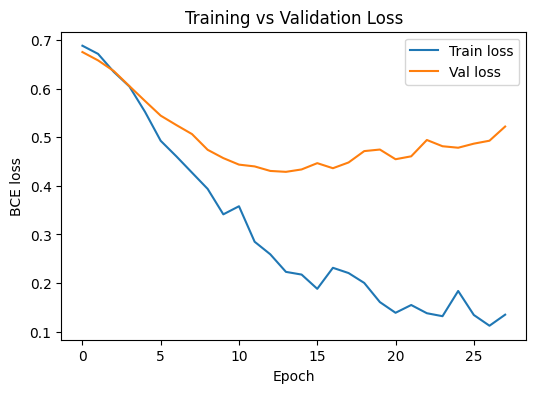

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_loss_history, label="Train loss")
plt.plot(val_loss_history, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.load_state_dict(best_state)
model.eval()

test_logits = []
test_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        test_logits.append(logits.cpu())
        test_targets.append(yb)

test_logits = torch.cat(test_logits).numpy()
test_targets = torch.cat(test_targets).numpy()

test_probs = np.exp(test_logits) / np.sum(np.exp(test_logits), axis=1, keepdims=True)
test_preds = np.argmax(test_probs, axis=1)

try:
    test_auc = roc_auc_score(
        test_targets,
        test_probs,
        multi_class="ovo",
        average="macro"
    )
except Exception:
    test_auc = roc_auc_score(
        test_targets,
        test_probs,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auc, 3))
print("\nClassification Report:")
print(classification_report(test_targets, test_preds))

print("\nNormalized Confusion Matrix:")
print(confusion_matrix(test_targets, test_preds, normalize="true"))



Test AUROC: 0.983

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        85
           1       0.98      0.97      0.97        58
           2       0.94      0.68      0.79        25

    accuracy                           0.93       168
   macro avg       0.94      0.87      0.90       168
weighted avg       0.93      0.93      0.93       168


Normalized Confusion Matrix:
[[0.97647059 0.01176471 0.01176471]
 [0.03448276 0.96551724 0.        ]
 [0.32       0.         0.68      ]]


# Multi-Class Neural Net Post-Lasso

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train_postlasso_canc)
X_val_imp   = imputer.transform(X_val_postlasso_canc)
X_test_imp  = imputer.transform(X_test_postlasso_canc)

y_train_mc = y_train_canc.astype(int)
y_val_mc   = y_val_canc.astype(int)
y_test_mc  = y_test_canc.astype(int)

num_classes = int(y_train_mc.nunique())
print("Num classes:", num_classes)


Num classes: 3


In [ ]:
from torch.utils.data import DataLoader

batch_size = 256

train_ds = TabularDatasetMulti(X_train_imp, y_train_mc)
val_ds   = TabularDatasetMulti(X_val_imp, y_val_mc)
test_ds  = TabularDatasetMulti(X_test_imp, y_test_mc)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP_Multiclass(
    input_dim=X_train_imp.shape[1],
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-3
)

best_val_auc = 0.0
best_epoch = 0
patience = 5
epochs_no_improve = 0
n_epochs = 100

train_loss_hist = []
val_loss_hist = []
val_auc_hist = []

for epoch in range(n_epochs):
    # =====================
    # Train
    # =====================
    model.train()
    train_losses = []

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # =====================
    # Validation
    # =====================
    model.eval()
    val_logits = []
    val_targets = []
    val_losses = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)

            val_logits.append(logits.cpu())
            val_targets.append(yb.cpu())
            val_losses.append(loss.item())

    val_logits = torch.cat(val_logits).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_probs = np.exp(val_logits) / np.sum(np.exp(val_logits), axis=1, keepdims=True)

    val_loss = np.mean(val_losses)

    # Macro AUROC
    try:
        val_auc = roc_auc_score(
            val_targets,
            val_probs,
            multi_class="ovo",
            average="macro"
        )
    except Exception:
        val_auc = roc_auc_score(
            val_targets,
            val_probs,
            multi_class="ovr",
            average="macro"
        )

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    val_auc_hist.append(val_auc)

    print(
        f"Epoch {epoch:03d} | "
        f"Train loss={train_loss:.4f} | "
        f"Val loss={val_loss:.4f} | "
        f"Val AUROC={val_auc:.4f}"
    )

    # =====================
    # Early stopping
    # =====================
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 000 | Train loss=0.9767 | Val loss=0.9242 | Val AUROC=0.6967
Epoch 001 | Train loss=0.8856 | Val loss=0.8452 | Val AUROC=0.6964
Epoch 002 | Train loss=0.7968 | Val loss=0.7796 | Val AUROC=0.7068
Epoch 003 | Train loss=0.7416 | Val loss=0.7277 | Val AUROC=0.7367
Epoch 004 | Train loss=0.6669 | Val loss=0.6805 | Val AUROC=0.8026
Epoch 005 | Train loss=0.6265 | Val loss=0.6358 | Val AUROC=0.8608
Epoch 006 | Train loss=0.5680 | Val loss=0.5954 | Val AUROC=0.8858
Epoch 007 | Train loss=0.5192 | Val loss=0.5575 | Val AUROC=0.9026
Epoch 008 | Train loss=0.4777 | Val loss=0.5212 | Val AUROC=0.9223
Epoch 009 | Train loss=0.4382 | Val loss=0.4887 | Val AUROC=0.9362
Epoch 010 | Train loss=0.4075 | Val loss=0.4600 | Val AUROC=0.9424
Epoch 011 | Train loss=0.3585 | Val loss=0.4372 | Val AUROC=0.9437
Epoch 012 | Train loss=0.3390 | Val loss=0.4158 | Val AUROC=0.9446
Epoch 013 | Train loss=0.3077 | Val loss=0.3975 | Val AUROC=0.9466
Epoch 014 | Train loss=0.3149 | Val loss=0.3808 | Val AUROC=0.

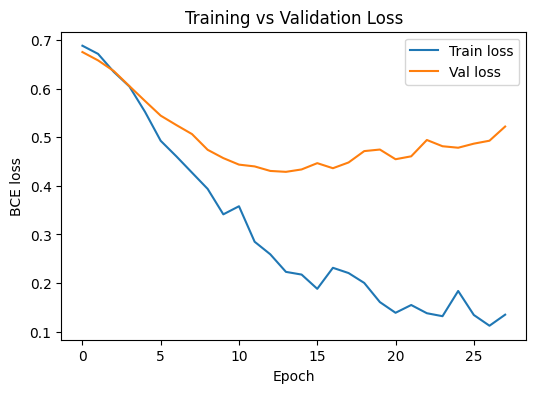

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_loss_history, label="Train loss")
plt.plot(val_loss_history, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.load_state_dict(best_state)
model.eval()

test_logits = []
test_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        test_logits.append(logits.cpu())
        test_targets.append(yb)

test_logits = torch.cat(test_logits).numpy()
test_targets = torch.cat(test_targets).numpy()

test_probs = np.exp(test_logits) / np.sum(np.exp(test_logits), axis=1, keepdims=True)
test_preds = np.argmax(test_probs, axis=1)

try:
    test_auc = roc_auc_score(
        test_targets,
        test_probs,
        multi_class="ovo",
        average="macro"
    )
except Exception:
    test_auc = roc_auc_score(
        test_targets,
        test_probs,
        multi_class="ovr",
        average="macro"
    )

print("\nTest AUROC:", round(test_auc, 3))
print("\nClassification Report:")
print(classification_report(test_targets, test_preds))

print("\nNormalized Confusion Matrix:")
print(confusion_matrix(test_targets, test_preds, normalize="true"))



Test AUROC: 0.992

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        85
           1       0.98      0.93      0.96        58
           2       0.92      0.88      0.90        25

    accuracy                           0.94       168
   macro avg       0.94      0.93      0.93       168
weighted avg       0.94      0.94      0.94       168


Normalized Confusion Matrix:
[[0.96470588 0.01176471 0.02352941]
 [0.06896552 0.93103448 0.        ]
 [0.12       0.         0.88      ]]


# Figure Creation

In [ ]:
import pandas as pd
import numpy as np

data = {
    "Pre-lasso": {
        "Lasso": 0.9632628722034143,
        "Neural Network": 0.9533,
        "Random Forest": 0.971427,
        "XGBoost": 0.969992,
        "XGBoost (Focal)": 0.971115,
        "XGBoost (LabelSmooth)": 0.971155,
    },
    "Post-lasso": {
        "Lasso": np.nan,
        "Neural Network": 0.9648,
        "Random Forest": 0.971351,
        "XGBoost": 0.966933,
        "XGBoost (Focal)": 0.972042,
        "XGBoost (LabelSmooth)": 0.968567,
    }
}

df = pd.DataFrame(data)


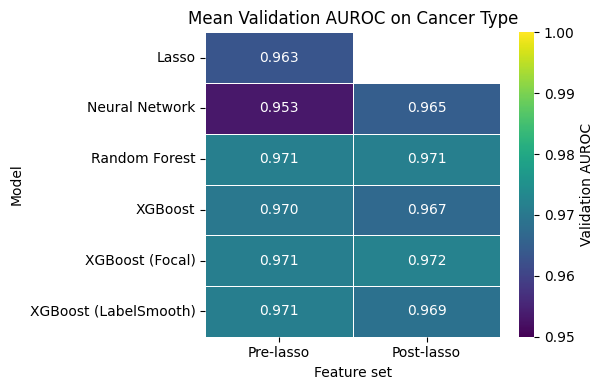

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

sns.heatmap(
    df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Validation AUROC"},
    vmin=0.95,
    vmax=1.0
)

plt.title("Mean Validation AUROC on Cancer Type", fontsize=12)
plt.ylabel("Model")
plt.xlabel("Feature set")

plt.tight_layout()
plt.savefig(DATA / "Figure5_multiclass_heatmap.png", dpi=300)
plt.show()


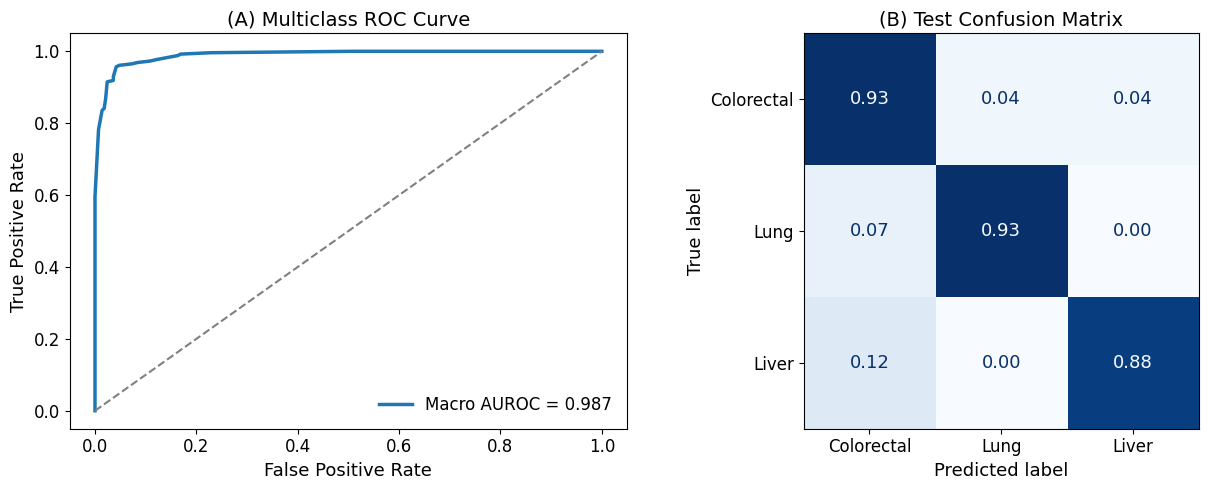

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# ===========================
# 1. Data + predictions
# ===========================
class_names = ["Colorectal", "Lung", "Liver"]
num_classes = len(class_names)

y_test_mc = y_test_canc.astype(int).values

# XGBoost multiclass probabilities
y_test_proba = best_booster.predict(dtest)
y_test_proba = y_test_proba.reshape(-1, num_classes)

y_test_pred = np.argmax(y_test_proba, axis=1)

# ===========================
# 2. Multiclass AUROC (macro)
# ===========================
y_test_bin = label_binarize(y_test_mc, classes=np.arange(num_classes))

test_auc = roc_auc_score(
    y_test_bin,
    y_test_proba,
    average="macro",
    multi_class="ovr"
)

# ===========================
# 3. Macro-average ROC curve
# ===========================
fpr = dict()
tpr = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])

# Macro-average ROC (force proper endpoints)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

# Explicitly add (0,0) and (1,1)
all_fpr = np.concatenate([[0.0], all_fpr, [1.0]])
mean_tpr = np.concatenate([[0.0], mean_tpr, [1.0]])

# ===========================
# 4. Confusion matrix
# ===========================
cm = confusion_matrix(
    y_test_mc,
    y_test_pred,
    normalize="true"
)

# ===========================
# 5. Plot Figure 6
# ===========================
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ---- (A) Multiclass ROC ----
axes[0].plot(
    all_fpr,
    mean_tpr,
    lw=2.5,
    label=f"Macro AUROC = {test_auc:.3f}"
)
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1.5)

axes[0].set_xlabel("False Positive Rate", fontsize=13)
axes[0].set_ylabel("True Positive Rate", fontsize=13)
axes[0].set_title("(A) Multiclass ROC Curve", fontsize=14)
#axes[0].set_aspect("equal", adjustable="box")
axes[0].tick_params(axis="both", labelsize=12)
axes[0].legend(loc="lower right", fontsize=12, frameon=False)

# ---- (B) Confusion matrix ----
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    ax=axes[1],
    cmap="Blues",
    colorbar=False,
    values_format=".2f"
)

axes[1].set_title("(B) Test Confusion Matrix", fontsize=14)
axes[1].set_xlabel("Predicted label", fontsize=13)
axes[1].set_ylabel("True label", fontsize=13)
axes[1].tick_params(axis="both", labelsize=12)

for text in axes[1].texts:
    text.set_fontsize(13)

plt.tight_layout()
plt.savefig(DATA / "Figure6_multiclass_deep_dive.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

data = {
    "Pre-lasso": {
        "Lasso": 0.8701214287824622,
        "Neural Network": 0.8843619818595444,
        "Random Forest": 0.905708,
        "XGBoost": 0.924129,
        "XGBoost (Focal)": 0.919668,
        "XGBoost (LabelSmooth)": 0.922711,
    },
    "Post-lasso": {
        "Lasso": np.nan,
        "Neural Network": 0.8968889414128283,
        "Random Forest": 0.903921,
        "XGBoost": 0.918752,
        "XGBoost (Focal)": 0.922445,
        "XGBoost (LabelSmooth)": 0.922002,
    }
}

df = pd.DataFrame(data)


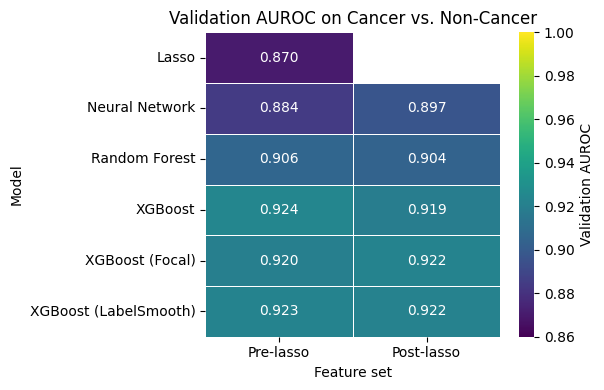

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

sns.heatmap(
    df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Validation AUROC"},
    vmin=0.86,
    vmax=1.0
)

plt.title("Validation AUROC on Cancer vs. Non-Cancer", fontsize=12)
plt.ylabel("Model")
plt.xlabel("Feature set")

plt.tight_layout()
plt.savefig(DATA / "Figure3_binary_heatmap.png", dpi=300)
plt.show()


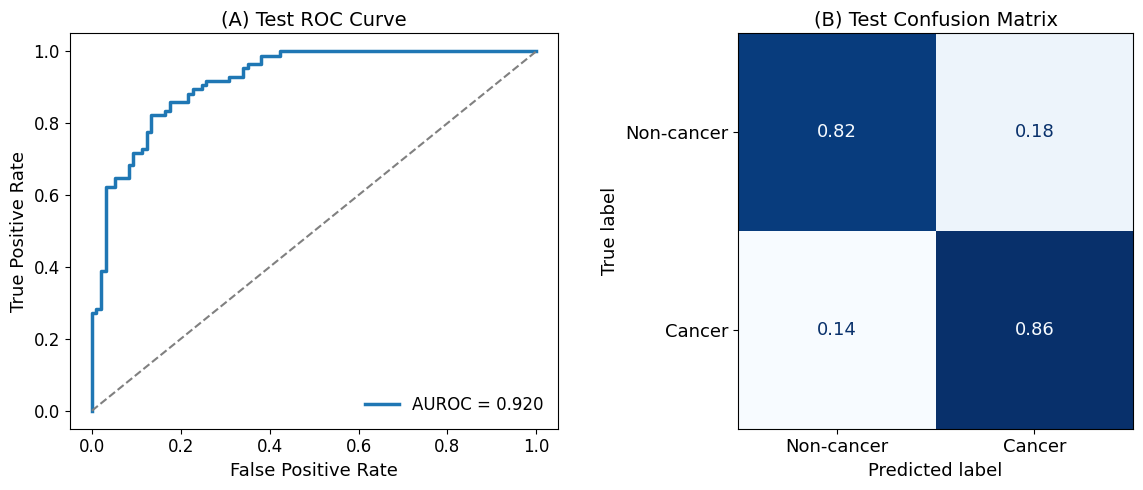

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ===========================
# 1. Test predictions
# ===========================
y_test_true = y_test["binary"].values
y_test_proba = best_model.predict_proba(X_test_postft)[:, 1]

test_auc = roc_auc_score(y_test_true, y_test_proba)

# ===========================
# 2. Threshold
# ===========================
threshold = 0.5
y_test_pred = (y_test_proba >= threshold).astype(int)

# ===========================
# 3. Figure 4
# ===========================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- (A) ROC curve ----
fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)

axes[0].plot(fpr, tpr, lw=2.5, label=f"AUROC = {test_auc:.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1.5)

axes[0].set_xlabel("False Positive Rate", fontsize=13)
axes[0].set_ylabel("True Positive Rate", fontsize=13)
axes[0].set_title("(A) Test ROC Curve", fontsize=14)

axes[0].tick_params(axis="both", labelsize=12)
axes[0].legend(loc="lower right", fontsize=12, frameon=False)

# ---- (B) Confusion matrix ----
cm = confusion_matrix(
    y_test_true,
    y_test_pred,
    normalize="true"
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-cancer", "Cancer"]
)

disp.plot(
    ax=axes[1],
    cmap="Blues",
    colorbar=False,
    values_format=".2f"
)

axes[1].set_title("(B) Test Confusion Matrix", fontsize=14)
axes[1].tick_params(axis="both", labelsize=13)
axes[1].set_xlabel("Predicted label", fontsize=13)
axes[1].set_ylabel("True label", fontsize=13)

# Increase annotation font size manually
for text in axes[1].texts:
    text.set_fontsize(13)

plt.tight_layout()
plt.savefig(DATA / "Figure4_binary_deep_dive.png", dpi=300, bbox_inches="tight")
plt.show()
